In [114]:
# pip install librosa

In [1]:
import serial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz , argrelextrema , spectrogram , welch
import biosppy
import biosppy.signals.eda as eda
import neurokit2 as nk
import ledapy
from numpy.lib.stride_tricks import as_strided
import librosa
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

In [2]:
# Global variables
Fs = 10

In [6]:
def Serial_configuration() :
    # Configure the serial port
    port = 'COM3'  # Replace with the appropriate COM port for your system
    baud_rate = 9600  # Set the baud rate to match your MC configuration
    data_bits = 8
    parity = serial.PARITY_NONE
    stop_bits = 1
    # Create a serial object
    global ser
    ser = serial.Serial(port, baud_rate, data_bits, parity, stop_bits)

In [7]:
def plot_discrete_data( my_signal , samples_num):
    F_sampling = samples_num  
    time = np.arange( 0 , F_sampling ) * (1/F_sampling) #Time  x-axis
    plt.stem(time , my_signal )  # Discrete


In [8]:
def save_data(a_df, data_list):
    data_to_append = []
    for data in data_list:
        new_panda_data = {
            "Data": data,
            "Data2": '1'
        }
        data_to_append.append(new_panda_data)

    # Concatenate the DataFrame with the new data
    a_df = pd.concat([a_df, pd.DataFrame(data_to_append)], ignore_index=True)
    # Save the DataFrame to an Excel file
    a_df.to_excel('serial_data.xlsx', index=False)

In [9]:
"""
The function take the signal and return the filtered signal
""" 
def apply_low_pass_filter_on_a_signal( order , normalized_cutoff , signal  ):
    fir_coefficients = firwin( order + 1, normalized_cutoff , window='hamming' ) # It return the FIR filter coefficients (bk)
    filtered_signal = np.convolve( signal , fir_coefficients, mode='same')  # 'same' to keep the output length the same
    return filtered_signal    

In [10]:
"""
Moving average filter
""" 
def Moving_avrage_filter( a_data_list , a_seconds , a_samplingFreq ):
    
    l_SCL = np.zeros(len(a_data_list)) # Save Tonic componanat
    l_SCR = np.zeros(len(a_data_list)) # Save phasic componant
    
    l_window = a_seconds * a_samplingFreq # Filter window
    
    for i in range( l_window , len(a_data_list) - l_window ):
        l_medium_filter_out = a_data_list[ i-l_window : i+l_window ]
        l_SCL[i] = np.median(l_medium_filter_out) # Make a medium filter
        l_SCR[i] = a_data_list[i] - l_SCL[i]
    return l_SCL , l_SCR


In [11]:
"""
Min_Max normalization
Perform Min-Max Normalization on a list of data.

Parameters:
- data (list): The input list of numerical values.

Returns:
- normalized_data (list): The list of normalized values.
"""
def min_max_normalization(a_data):

#     l_min_val = min(a_data)
#     l_max_val = max(a_data)

#     l_normalized_data = [(l_x - l_min_val) / (l_max_val - l_min_val) for l_x in a_data]
    a_data = [x / 100 for x in a_data]

    return a_data

In [9]:
def Processing_signal( a_signal ):
        processed_signal = apply_low_pass_filter_on_a_signal( 70 , 1/Fs , a_signal ) # Filtering signal
#         processed_signal = min_max_normalization(processed_signal)  # Normalization
#       processed_signal = eda.eda( a_signal , sampling_rate = Fs)
#       processed_signal = Moving_avrage_filter( a_signal , 4 )
#     onsets , peaks , amp = eda.kbk_scr( a_signal , Fs )
        return processed_signal

In [10]:
"""
  Read data from sensor 
""" 
def ReadDataFromSensor( a_time_sec ):
    
    # Create an empty DataFrame to store the received data
    panda_data = {
        "Data"  : [0],
        "Data2" : [0]
    }
    df = pd.DataFrame( panda_data )


    # Make the configuration
    Serial_configuration()
    counter = 0
    data_list = np.array([])
    counter = 0;


    print("start\n")
    # Read and store the serial data
    while True:
        if ser.in_waiting > 0:
            # Read Line
            temp =  ser.readline().decode().strip()
            counter = counter + 1

            if( temp == '' ):
                data = 0
            else :
                data = int( temp )

            if( counter >= a_time_sec*Fs ):
                ser.close()
                print('************************')
                data_list = np.append( arr = data_list , values = [data]  )

                # Plot signal
                plt.subplot(4,1,1)
                plt.title("Time domain")
                #plt.ylim(200 , 700)
                plt.plot( data_list )
                plt.subplot(4,1,2)
                plt.title("Freq domain")
                plt.plot(  np.real( ( np.fft.fft(data_list)[1:] ) ) )

#                 #Process signal
#                 process_data_list = Processing_signal( data_list )
#                 print('**********************************')
#                 plt.subplot(4,1,3)
#                 plt.title("After processing")
#                 plt.ylim(0.3 , 1)
#                 plt.plot( process_data_list , 'r')
#                 plt.subplot(4,1,4)
#                 plt.plot(  np.real( ( np.fft.fft(process_data_list)[1:] )  ) , 'r' )

                # Empty the list and counter
                counter = 0
                break
            else :
                data_list = np.append( arr = data_list , values = [data]  )
                print("Data={:d}".format(data))

    # Save the data 
    save_data( df , data_list )
    return data_list 
        
# GSR_Read_data = ReadDataFromSensor(60*20)


In [36]:
# Close serial connection
ser.close()

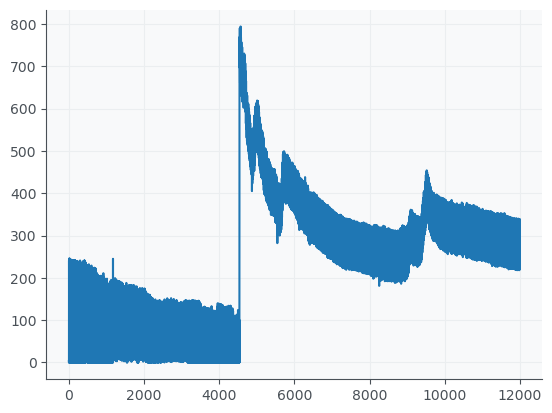

In [21]:
kkkk = GSR_Read_data[0:]
# kkkk = apply_low_pass_filter_on_a_signal( 50 , 1/Fs , kkkk ) # Filtering signal
plt.plot(kkkk[3:-3])

In [19]:
# Write_listInFile('MentalWorkLoad/.txt' , kkkk )

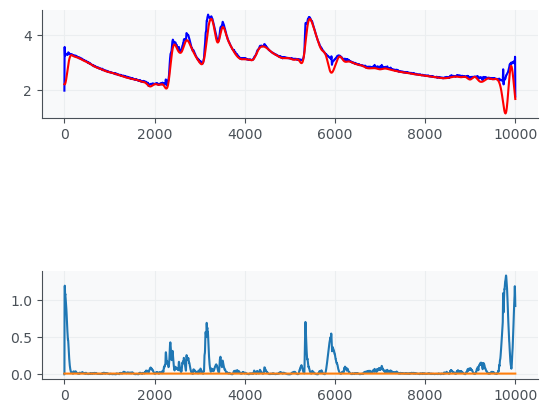

In [21]:
"""
                Not good to Extract onset and offset, so we didn't use it
                
  Make preprocessing       : Applaying FIR Low pass filter of order 50 at cutoff 1.5/Fs
                             Make Min_Max Normalization to the signal
  Extract Phasic and tonic : Using cvxEDA method from neurokit2 package                     
"""
def GSR_preprocessingAndExtractPhasicAndTonic( a_signal , a_plot=True ):
    
    a_signal = min_max_normalization(a_signal) #First make normalization to the signal
    a_signal = apply_low_pass_filter_on_a_signal( 50 , 1.5/Fs , a_signal ) # Make a Low pass filter



    l_eda_tonic_phasic = nk.eda_phasic( a_signal , sampling_rate=Fs , method="cvxEDA"  )


    l_eda_phasic = l_eda_tonic_phasic['EDA_Phasic'].tolist()
    l_eda_tonic = l_eda_tonic_phasic['EDA_Tonic'].tolist()
    
    
    if( a_plot == True ):
        plt.subplot(3,1,1)
        plt.plot(a_signal, 'b')
        plt.subplot(3,1,1)
        plt.plot( l_eda_tonic , 'r' )
        plt.subplot(3,1,3)
        plt.plot( l_eda_phasic )
        plt.subplot(3,1,3)
        plt.plot( [0.01]*len(a_signal) )
        
    return l_eda_tonic , l_eda_phasic   


Fs = 10
x = Get_dataFromTextFile('serial_data_1.txt')    
llvll,ggg = GSR_preprocessingAndExtractPhasicAndTonic(x,True)


In [22]:
"""
                      GSR_ExtractPhasicTonic_OnsetAndOffset
                      
  Make preprocessing       : Applaying FIR Low pass filter of order 50 at cutoff 1/Fs
                             Make Min_Max Normalization to the signal
 Extract Phasic and tonic  : Using neurokit method
 Extract onset and offset  : from pahsic componat of signal using threshold 0.01 of onset
                             and 0 of offset
 Extract peaks             : from cleaned data, it will extract peaks between each couple onset and offset                           
 return                    : It returns phasic, tonic, onset_offset couple and peaks
                            
"""
def GSR_ExtractPhasicTonic_OnsetAndOffset_Peaks( a_gsr_sig , a_plot=True ):
    
    l_sig =  apply_low_pass_filter_on_a_signal( 50 , 1/Fs , a_gsr_sig ) # Make a Low pass filter
    l_sig = min_max_normalization(l_sig) # Make Normalization

    # --- Get phasic and tonic componants ---
    l_process_sig , l_process_info = nk.eda_process(  l_sig , sampling_rate=Fs , method='neurokit' )
    l_tonic  = l_process_sig['EDA_Tonic'].tolist()   # Get tonic  componant and change it to a list
    l_phasic = l_process_sig['EDA_Phasic'].tolist()  # Get phasic componant and change it to a list
    
    # cvxEDA method gives a phasic compnant from 0 to 1, no offset in it, so we didn't use it
#     l_eda_tonic_phasic = nk.eda_phasic( l_sig , sampling_rate=Fs , method="cvxEDA"  )
#     l_phasic = l_eda_tonic_phasic['EDA_Phasic'].tolist()
#     l_tonic = l_eda_tonic_phasic['EDA_Tonic'].tolist()
    
    l_phasic = l_phasic[0:] # Slice phasic componant
    l_sig = l_sig[0:]

    # --- Calculate onsets and offsets ---
    l_onset_threshold = 0.01
    l_offset_threshold=0

    # Initialize onset and offset array
    l_onset  = np.zeros( len(l_phasic) )
    l_offset = np.zeros( len(l_phasic) )

    # Onset
    for i in range( len(l_phasic) ): # Get all points that is larger than onset threshold 
        if( l_phasic[i] > l_onset_threshold ):
            l_onset[i] = i
        else:
            l_onset[i] = 0

    # Offset
    for i in range( len(l_phasic) ): # Get all points that is smaller than offset threshold 
        if( l_phasic[i] <= l_offset_threshold ):
            l_offset[i] = i
        else:
            l_offset[i] = 0

    # The next step is to couple onset and offset with each other
    l_index = 0
    l_token = 1
    l_len = max( len(l_offset) , len(l_onset) )


    l_onset_offset_couple = []  # An array that will save the onset and offset couples

    for i in range( l_len-1 ):
        if( l_token == 1 ): 
            while( l_index < len(l_onset) and l_onset[l_index] == 0 ):
                l_index = l_index + 1
    
            # A start of an onset
            l_onset_index = l_index 
            l_token = 0

        if( l_token == 0 ):
            while( l_index < len(l_offset) and l_offset[l_index] == 0 ):
                l_index = l_index + 1
  
            # couple offset with it's onset
            l_offset_index = l_index
            l_token = 1
            # Cheack if it reaches end of list
            if( l_index >= l_len-1 ):
                break  
            else :
                 l_onset_offset_couple.append( [l_onset_index,l_offset_index] ) # append couple
    
    
   
            
    # Separate onset and offset points from each other to draw them
    l_draw_onset = []
    for i in range( len(l_onset_offset_couple) ):
        l_draw_onset.append( l_onset_offset_couple[i][0] )
        
    l_draw_offset = []
    for i in range( len(l_onset_offset_couple) ):
        l_draw_offset.append( l_onset_offset_couple[i][1] )    

    # X_axis of the onset and offsets    
    l_onset_x_axis  = [l_onset_threshold]*len(l_draw_offset) 
    l_offset_x_axis = [l_offset_threshold]*len(l_draw_offset)
        

    # --- Find peaks between each onset and offset ---
    l_interval = [] # Will contain values of samples between onset and offset
    l_peaks = [] # Will contains the peaks for each onset-offset pair
    for i in range( len(l_onset_offset_couple ) ):
        l_j=0
        l_temp = l_onset_offset_couple[i][0] # Get the index of onset point

        while( l_temp < l_onset_offset_couple[i][1] ): # Loop untill reaches the corresponding offset value
            l_interval.append( l_sig[ l_temp ] ) # append the raw signal value which is between onset and offset
            l_temp+=1
        # At this point we reaches the end of onset-offset interval
        l_max_value = max(l_interval) # peak value
        l_peaks.append( [  l_temp-len(l_interval)+l_interval.index(l_max_value) , l_max_value ] ) # append the peaks index and peak value
        l_interval.clear() # Clear the interval list
        
    # Separate index of peak points from peak value in two arrays
    l_draw_peak_index = []
    l_draw_peak_value = []
    for i in range( len(l_peaks) ):
        l_draw_peak_index.append( l_peaks[i][0] ) 
        l_draw_peak_value.append( l_peaks[i][1] ) 
        
    # Draw a histogram
    l_timeForEachSample = 100
    l_draw_histogram = np.zeros( int( len(l_phasic)/(Fs*l_timeForEachSample) ) + 1 )
    for i in range( len(l_draw_peak_index) ):
        l_his_index = int( l_draw_peak_index[i]/(Fs*l_timeForEachSample) ) # Get interval of each sample
        l_draw_histogram[ l_his_index ] += 1 # increment 
        
    # Plot
    if( a_plot == True ):
        plt.subplot(3,1,1)
        plt.title('phasic')
        plt.plot(l_phasic )
        plt.scatter( l_draw_onset , l_onset_x_axis , c='r' , label='onset'   )   # Draw onsets
        plt.scatter( l_draw_offset , l_offset_x_axis , c='g' , label='offset'   ) # Draw offsets
        plt.grid()
        plt.subplot(3,1,2)
        plt.title('Raw data')
        plt.plot(l_sig , label='cleaned signal')
        plt.scatter( l_draw_peak_index , l_draw_peak_value ,c='#FF5733' , marker='x' ) 
        plt.grid()
        plt.subplot(3,1,3 )
        plt.bar( np.arange(0,len(l_draw_histogram) ) , l_draw_histogram)
        plt.grid()

        
    return l_phasic , l_draw_histogram , l_tonic , l_onset_offset_couple , l_peaks     
    
    
    
# Fs = 10    
# x = Get_dataFromTextFile('serial_data_1.txt')    
# x= kkkk

# f , g , _ , _ , _ = GSR_ExtractPhasicTonic_OnsetAndOffset_Peaks(x)    
# g

In [23]:
"""
   This function takes the phasic, onset and peaks and plot them
"""
def Plot_Phasic_with_onset_and_peaks( a_phasic , a_onset , a_peak ):
    l_ts = np.linspace(0, (len(a_phasic)-1)/16,len(a_phasic),endpoint=False)
    plt.plot(l_ts,a_phasic , label='Signal 1')
    plt.scatter(l_ts[a_peak],a_phasic[a_peak],c='r',s=10 , label='Signal 1')
    plt.scatter(l_ts[a_onset],a_phasic[a_onset],c='y',s=10 , label='Signal 1')

def Plot_orign_with_onset_and_peaks( a_orign , a_tonic , a_onset , a_peak ):
    l_ts = np.linspace(0, (len(a_orign)-1)/16,len(a_orign),endpoint=False)
    plt.plot(l_ts,a_orign,c='b')
    plt.plot(l_ts,a_tonic,c='g')
    plt.scatter(l_ts[a_peak] ,a_orign[a_peak],c='r',s=20)
    plt.scatter(l_ts[a_onset] , a_orign[a_onset],c='y',s=10)
    

In [24]:
"""
   This function is used to plot data from Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks functio
"""

def Ledapy_plot( a_orign , a_phasic , a_tonic , a_onset , a_peak):
    plt.subplot(2,1,1)
    plt.grid()
    plt.title('Phasic')
    Plot_Phasic_with_onset_and_peaks( a_phasic , a_onset , a_peak )
    
    plt.subplot(2,1,2)
    plt.grid()
    plt.title('cleaned data')
    Plot_orign_with_onset_and_peaks(  a_orign , a_tonic , a_onset , a_peak )
    plt.grid()
    plt.show()
    plt.close()
    
    
"""
                      Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime
                      
  Make preprocessing       : Applaying FIR Low pass filter of order 50 at cutoff 1.5/Fs
                             Make Min_Max Normalization to the signal
 Extract Phasic and tonic  : Using ledapy method
 Extract onset and offset  : from pahsic componat of signal using threshold 0.1 
 
 Extract peaks             : from cleaned data, it will extract peaks                      
 return                    : It returns cleaned signal , phasic , tonic , onsets , peaks, raise_time
                            
"""
def Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( a_signal , a_min_amplitude , a_plot=True ):                
    l_scrs, l_amps, l_ZC, l_pks = [], [], [], []
    a_signal = min_max_normalization(a_signal) #First make normalization to the signal
    a_signal = apply_low_pass_filter_on_a_signal( 50 , 1/Fs , a_signal ) # Make a Low pass filter
    
    l_phasicData  = ledapy.runner.getResult( a_signal ,  'phasicdata' , sampling_rate =Fs , downsample=1 )
    l_pahsicDriver = ledapy.runner.getResult( a_signal , 'phasicdriver' , sampling_rate =Fs , downsample=1 )
    l_tonicData = a_signal - l_phasicData


    # Find zero crossings
    l_zeros = argrelextrema(l_phasicData,np.less)[0]

    l_zeros = np.insert(l_zeros,0,0) # Insert zereo at index zero
    l_zeros = np.insert(l_zeros,len(l_zeros) , len(l_phasicData)-1) # insert the last index in the array at end


    for i in range(0, len(l_zeros) - 1, 1):
        l_scrs += [ l_phasicData[l_zeros[i]:l_zeros[i + 1]+1] ]
        l_aux = l_scrs[-1].max()
        if l_aux > l_phasicData[l_zeros[i]] and l_aux > l_phasicData[l_zeros[i+1]]:
            l_amps += [l_aux-l_phasicData[l_zeros[i]]]
            l_ZC += [l_zeros[i]]
            l_ZC += [l_zeros[i + 1]]
            l_pks += [l_zeros[i] + np.argmax(l_phasicData[l_zeros[i]:l_zeros[i + 1]])]
        elif l_aux == l_phasicData[l_zeros[-1]]:
            l_amps += [l_aux-l_phasicData[l_zeros[-2]]]
            l_ZC += [l_zeros[-2]]
            l_ZC += [l_zeros[-1]]
            l_pks += [l_zeros[-1]]
    if l_amps == []:
        l_ZC += [np.argmin(l_phasicData)]
        l_amps += [np.max(l_phasicData[l_ZC[0]:])-l_phasicData[l_ZC[0]]]
        l_pks += [np.argmax(l_phasicData[l_ZC[0]:])]

    # Find the maximum length of arrays in the list
    l_max_length = max(len(l_scrs) for l_scrs in l_scrs)

    # Pad shorter arrays with zeros to make them the same length
    l_padded_scrs = [np.pad(l_scrs, (0, l_max_length - len(l_scrs)), 'constant') for l_scrs in l_scrs ]

    l_scrs = np.array(l_padded_scrs)
    l_amps = np.array(l_amps)
    l_ZC = np.array(l_ZC)
    l_pks = np.array(l_pks)
    l_onsets = l_ZC[::2]
    l_thr = a_min_amplitude * np.max(l_amps)
    l_arglow = np.where(l_amps<l_thr)
    l_amps = np.delete(l_amps,l_arglow)
    l_pks = np.delete(l_pks,l_arglow)
    l_onsets = np.delete(l_onsets,l_arglow)

    l_risingtimes = l_pks-l_onsets
    l_risingtimes = l_risingtimes/16

    l_pks = l_pks[l_risingtimes > 0.1]
    l_onsets = l_onsets[l_risingtimes > 0.1]
    l_amps = l_amps[l_risingtimes > 0.1]
    
    # Plot
    if( a_plot == True ):
        Ledapy_plot( a_signal , l_phasicData, l_tonicData , l_onsets , l_pks )

        
        
    l_rise_time = l_pks - l_onsets
    return  a_signal , l_phasicData , l_tonicData , l_onsets , l_pks , l_rise_time


# Fs = 10    
# # x = Get_dataFromTextFile('serial_data_1.txt')    
# x = kkkk
# clean_sig , ph , ton , onsets , ppk , raise_time = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime(  np.array(x) , 0.1 )

# print(ppk)
# print(onsets)
# ppk

In [25]:
"""
     Extract_frequency_Features
     
     This function Extracts some Freqency features from signal like FFT, PSD and Spectogram
     Return : FFT , PSD and Spectogram_Sxx

"""
def Extract_frequency_Features( a_signal , a_plot=True ):
    
    l_sig = a_signal
    l_sig =  apply_low_pass_filter_on_a_signal( 50 , 0.4/Fs , a_signal ) # Make a Low pass filter
    l_sig = min_max_normalization(l_sig) # Make Normalization
#     l_sig = l_sig[30:-60]

    # Compute Fast Forrirer Transform
    l_fft_sig = np.fft.fft( l_sig )[1:]
    # Compute power specturn denisty of signal
    l_freq, l_psd = welch( a_signal , fs=Fs , nperseg=len(a_signal) , window='hamming'   )
    # Compute spectrogram
    l_spectogram_freq , l_spectogram_times , l_spectogram_Sxx = spectrogram( np.array(a_signal) , fs=Fs  )
    
    
    # Get freqency from 0 to 0.25HZ, because the signal power is concentrated in this range
    l_fft_sig = l_fft_sig[0 : int(np.round( (0.25/Fs)*(len(l_fft_sig)) )) ]
    l_psd     = l_psd    [0 : int(np.round( (0.25/Fs)*(len(l_psd))     )) ]
    
    l_fft_sig        =  np.real(l_fft_sig)
    l_psd            =  np.real(l_psd)
    l_spectogram_Sxx =  np.real(l_spectogram_Sxx)
    
        
    if( a_plot == True ):
        # Plot FFT signal
        plt.figure(figsize=(10, 10))
        plt.subplot(3,1,1)
        plt.title('FFT')
        l_FFT_x_axis = np.linspace( 0 , 0.25 , len(l_fft_sig)  ) # Get x_axis of FFT graph from 0 to 0.4HZ 
        plt.plot( l_FFT_x_axis , l_fft_sig )

        # Plot PSD signal
        plt.subplot(3,1,2)
        plt.title('PSD')
        plt.plot( l_psd )

        # Plot spectogram
        plt.subplot(3,1,3)
        plt.title('Spectogram')
        plt.specgram( l_sig , Fs=Fs )
        plt.colorbar()
    
    
    return l_fft_sig.tolist() , l_psd.tolist() , l_spectogram_Sxx.tolist()


# Fs = 10    
# x = Get_dataFromTextFile('serial_data_1.txt')   
# # x = kkkk
# ff , kk , ll = Extract_frequency_Features(x) 


In [26]:
"""        
   This function takes the signal and split it into many windows to make process on each window
   a_arr     : is the my array
   a_window  : is the window size
   a_overlap : The overlab between ach window
   
   The function returns a two dimention array contains all windows
   Number of windows equal len(a_arr)/(window-overlab)
   Size of eah window equal a_window
   
   Taken from https://github.com/DebasmitaGhose/Stress-Modeling-with-GSR-and-Speech-Sensors/blob/master/GSR.py
"""
def windowed_view( a_arr, a_window_size , a_overlap):
    a_arr = np.asarray(a_arr)
    l_window_step = a_window_size - a_overlap
    l_new_shape = a_arr.shape[:-1] + ((a_arr.shape[-1] - a_overlap) // l_window_step, a_window_size)
    l_new_strides = (a_arr.strides[:-1] + (l_window_step * a_arr.strides[-1],) + a_arr.strides[-1:])
    
    return as_strided( a_arr, shape=l_new_shape, strides=l_new_strides)

In [2]:
"""
   Read a file
"""

def Get_dataFromTextFile( a_file_name ):
    # Open the file
    l_file_path = a_file_name  # Provide the path to your text file
    l_x = []

    with open(l_file_path, 'r') as file:
        # Read each line in the file
        for line in file:
            # Remove leading/trailing whitespaces and split if there are commas
            line_data = line.strip().split(',')

            # Convert each non-empty item in the line to a float and add to the data list
            for item in line_data:
                if item.strip():  # Check if the item is not an empty string
                    l_x.append(float(item))
    return l_x    

In [3]:
"""
  Get data from an Excel file
"""

def Get_dataFromExcel(a_file_path, a_column_name=None):
    try:
        # Read the Excel file
        l_df = pd.read_csv(a_file_path)
        
        # Extract the specified column
        if( a_column_name == None):
            l_column_temp = l_df.values.tolist()
            l_column_data = [item for sublist in l_column_temp for item in sublist]

        else:    
            l_column_data = l_df[a_column_name].tolist()
        
        return l_column_data
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

file_path = '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv' 
column_name = 'Trial 1:0back'  
column_data = Get_dataFromExcel(file_path, column_name)


In [4]:
"""
Write a list in a text file
"""
def Write_listInFile( a_file_name , a_list ):
    # Specify the file path where you want to save the data
    file_path = a_file_name
    # Open the file in write mode and write each number in the list to a separate line
    with open(file_path, 'w') as file:
        for number in a_list:
            file.write(str(number) + '\n')

# Write_listInFile( 'MentalWorkLoad/watching_an_AI_lecture.txt' , kkkk )

# Display some datasets

Mental work Load datasets

**************************************************************************
***************************** MWL 002 ************************************
**************************************************************************
PSD at resting = 2.4319900721828116e-05
sympathetic at resting = 1.2386151282395997e-06
sympatheticN at resting = 0.007434255482485177 

PSD at MWL trial1:0= 1.8723324828897755e-05
sympathetic = 9.510719845839799e-07
sympatheticN = 0.002367486948925955 

PSD at MWL trial2:2 = 3.3694316345984964e-05
sympathetic at trial2:2 = 2.4045380232120047e-06
sympatheticN at trial2:2 = 0.002899682904364551 

PSD at MWL trial3:3 = 3.268534297392658e-05
sympathetic at trial3:3 = 2.181244726258551e-06
sympatheticN at trial3:3 = 0.001744866520508894 

PSD at MWL trial4:2 = 2.3631004719575003e-05
sympathetic at trial4:2 = 1.1346405479583559e-06
sympatheticN at trial4:2 = 0.0012278177646444731 

PSD at MWL trial5:3 = 5.67360593265832e-05
sympathetic at trial5:3 = 3.4520054728703065e-

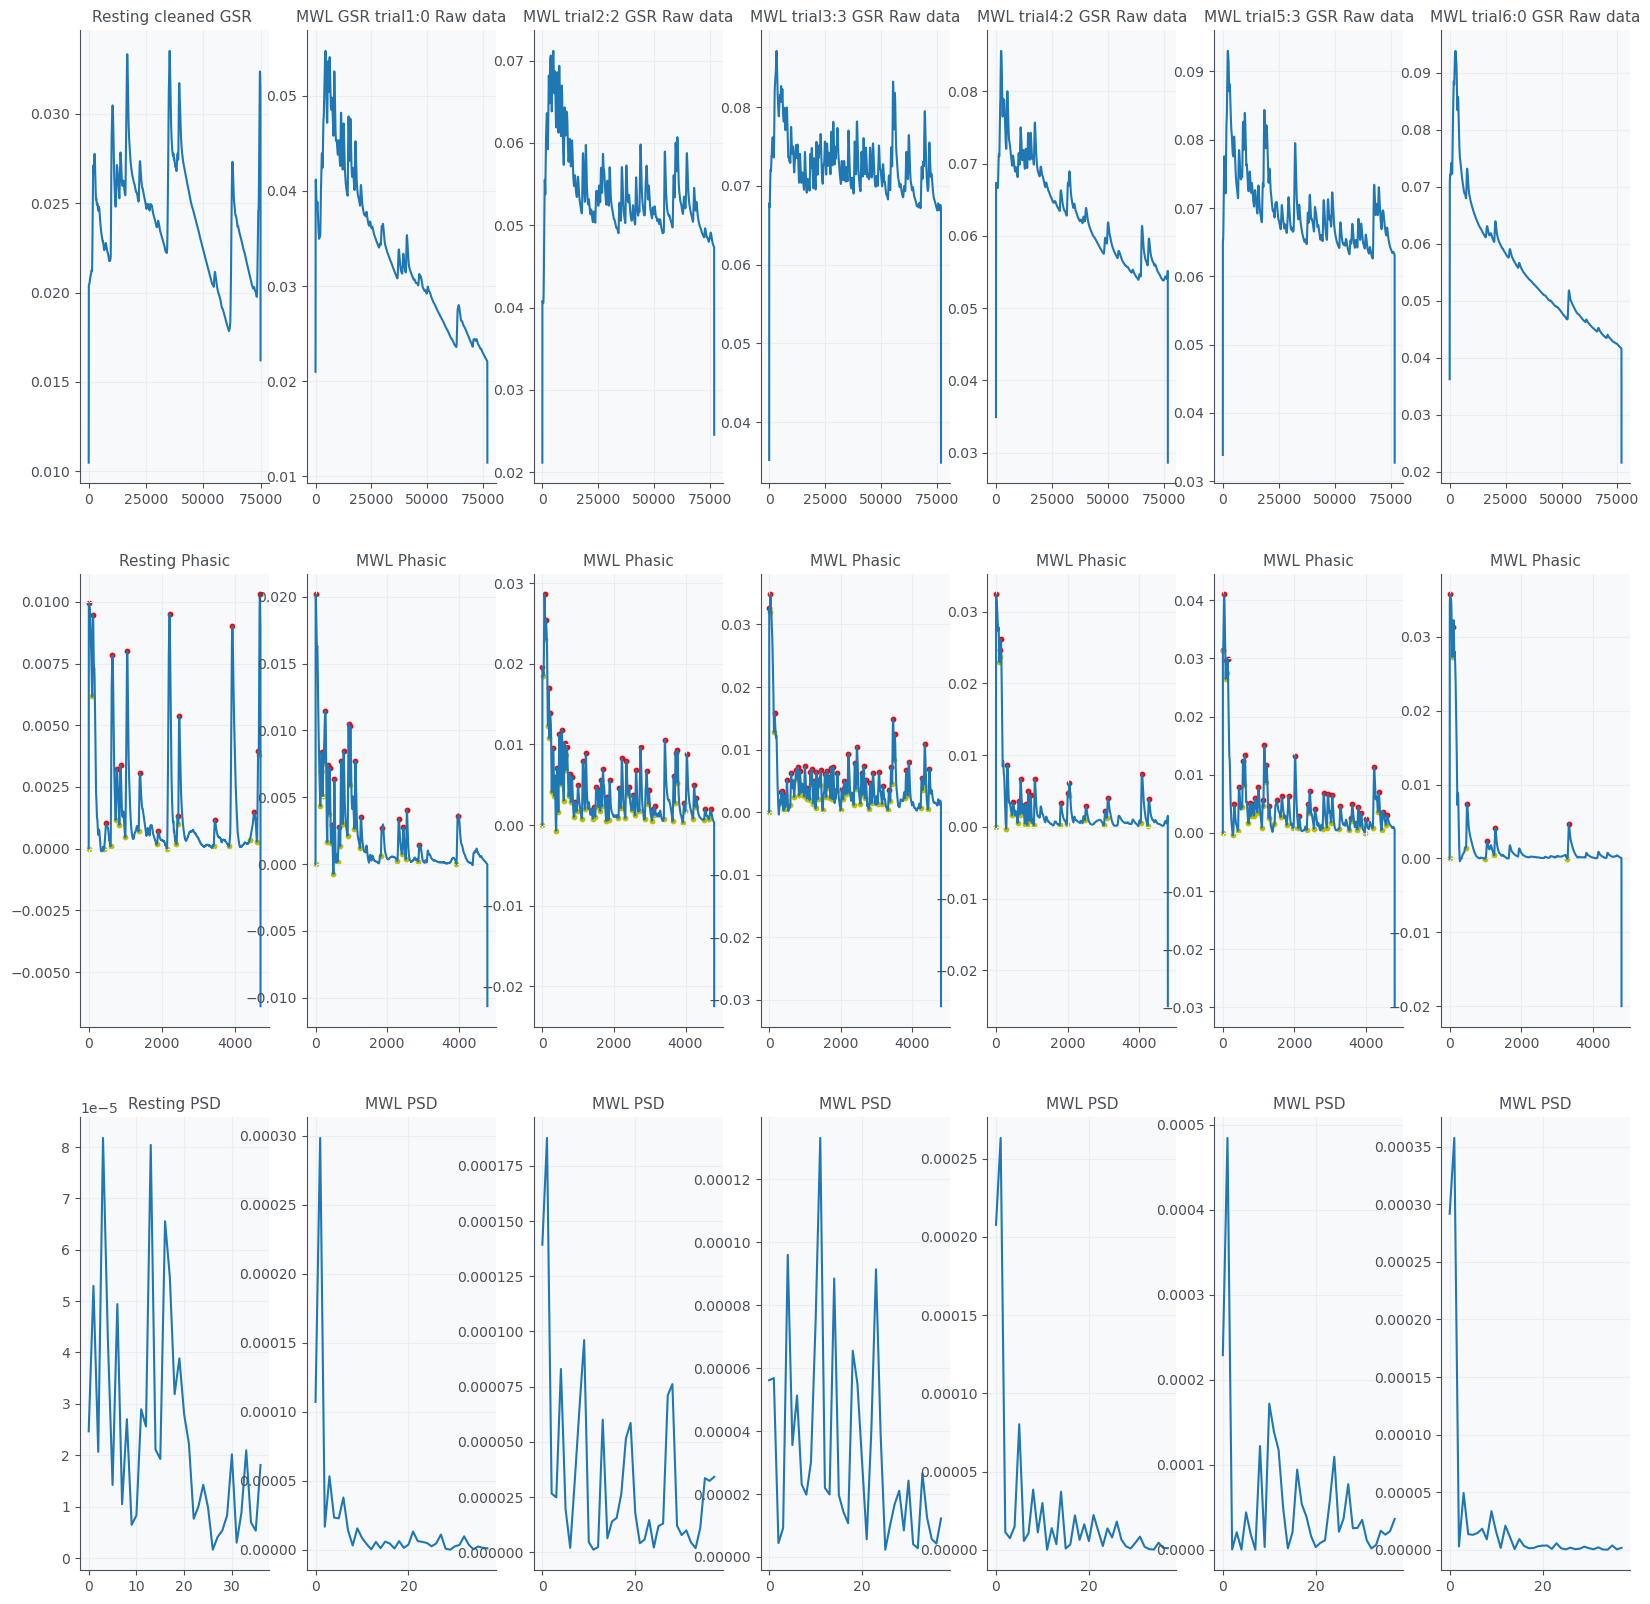

In [41]:


# Sampling freqency for this dataset is 100HZ for pixArt and 256HZ for inf

###############################################################################################################
###############################################################################################################
############################################# 002 #############################################################
###############################################################################################################
###############################################################################################################


Fs = 256
print('**************************************************************************')
print('***************************** MWL 002 ************************************')
print('**************************************************************************')
####################################### During resting 5min ###################################################
Resting2 = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_resting.csv','Resting_GSR')
# Clean and Extract some time domain features
r_clean_sig2 , r_Phasic2 , r_tonic2 , r_onset2 , r_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( Resting2 , 0.05 , a_plot=False )

plt.figure(figsize=(20, 20))
# Plot cleaned data
plt.subplot( 3 , 7 , 1  )
plt.title('Resting cleaned GSR ')
plt.plot(r_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 8 )
plt.title('Resting Phasic')
Plot_Phasic_with_onset_and_peaks( r_Phasic2 , r_onset2 , r_peaks2 )
# plot freqency componants
r_FFT2 , r_PSD2 , _ = Extract_frequency_Features( r_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 15 )
plt.title('Resting PSD')
plt.plot(r_PSD2)
print( f"PSD at resting = {np.mean(r_PSD2)}")
sympathetic =  nk.eda_sympathetic( r_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at resting = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( r_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN']
print( f'sympatheticN at resting = { sympatheticN } \n' )
 


####################################### During Mental work load Trial1 ###################################################
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv', 'Trial 1:0back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.05 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 2  )
plt.title('MWL GSR trial1:0 Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 9 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 16 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial1:0= {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN = { sympatheticN } \n' )


########## Trial2:2 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv', 'Trial 2:2back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.05 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 3  )
plt.title('MWL trial2:2 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 10 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 17 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial2:2 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial2:2 = { sympathetic }' )
sympatheticN =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial2:2 = { sympatheticN } \n' )


########## Trial3:3 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv', 'Trial 3:3back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.05 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 4  )
plt.title('MWL trial3:3 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 11 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 18 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial3:3 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial3:3 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial3:3 = { sympatheticN } \n' )


########## Trial4:2 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv', 'Trial 4:2back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.05 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 5  )
plt.title('MWL trial4:2 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 12 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 19 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial4:2 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial4:2 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial4:2 = { sympatheticN } \n' )


########## Trial5:3 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv', 'Trial 5:3back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.05 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 6  )
plt.title('MWL trial5:3 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 13 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 20 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial5:3 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial5:3 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN']
print( f'sympatheticN at trial5:3 = { sympatheticN } \n' )


########## Trial6:0 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv', 'Trial 6:0back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.05 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 7  )
plt.title('MWL trial6:0 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 14 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 21 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial6:0 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial6:0 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial6:0 = { sympatheticN } \n' )

**************************************************************************
***************************** MWL 004 ************************************
**************************************************************************
PSD at resting = 3.5394712198544606e-06
sympathetic at Reasting = 2.6913690479455382e-08
sympatheticN  = 0.0018229785588802117 

PSD at MWL = 1.9263283396732676e-06
sympathetic at trial1:0 = 2.630451985242926e-08
sympatheticN at trial1:0 = 0.0016591926422044807 

PSD at MWL trial2:2 = 9.265221982247342e-07
sympathetic at trial2:2 = 9.480948321363775e-09
sympatheticN at trial2:2 = 0.00021688073011955083 

PSD at MWL trial3:3 = 1.6550345282257416e-06
sympathetic at trial3:3 = 3.447991148271177e-08
sympatheticN at trial3:3 = 0.001373358094682585 

PSD at MWL trial4:2 = 1.8096462157365387e-05
sympathetic at trial4:2 = 1.5950978114834864e-07
sympatheticN at trial4:2 = 0.00387105309824655 

PSD at MWL trial5:3 = 1.3809885739324689e-06
sympathetic at trial5:3 = 3.43576492

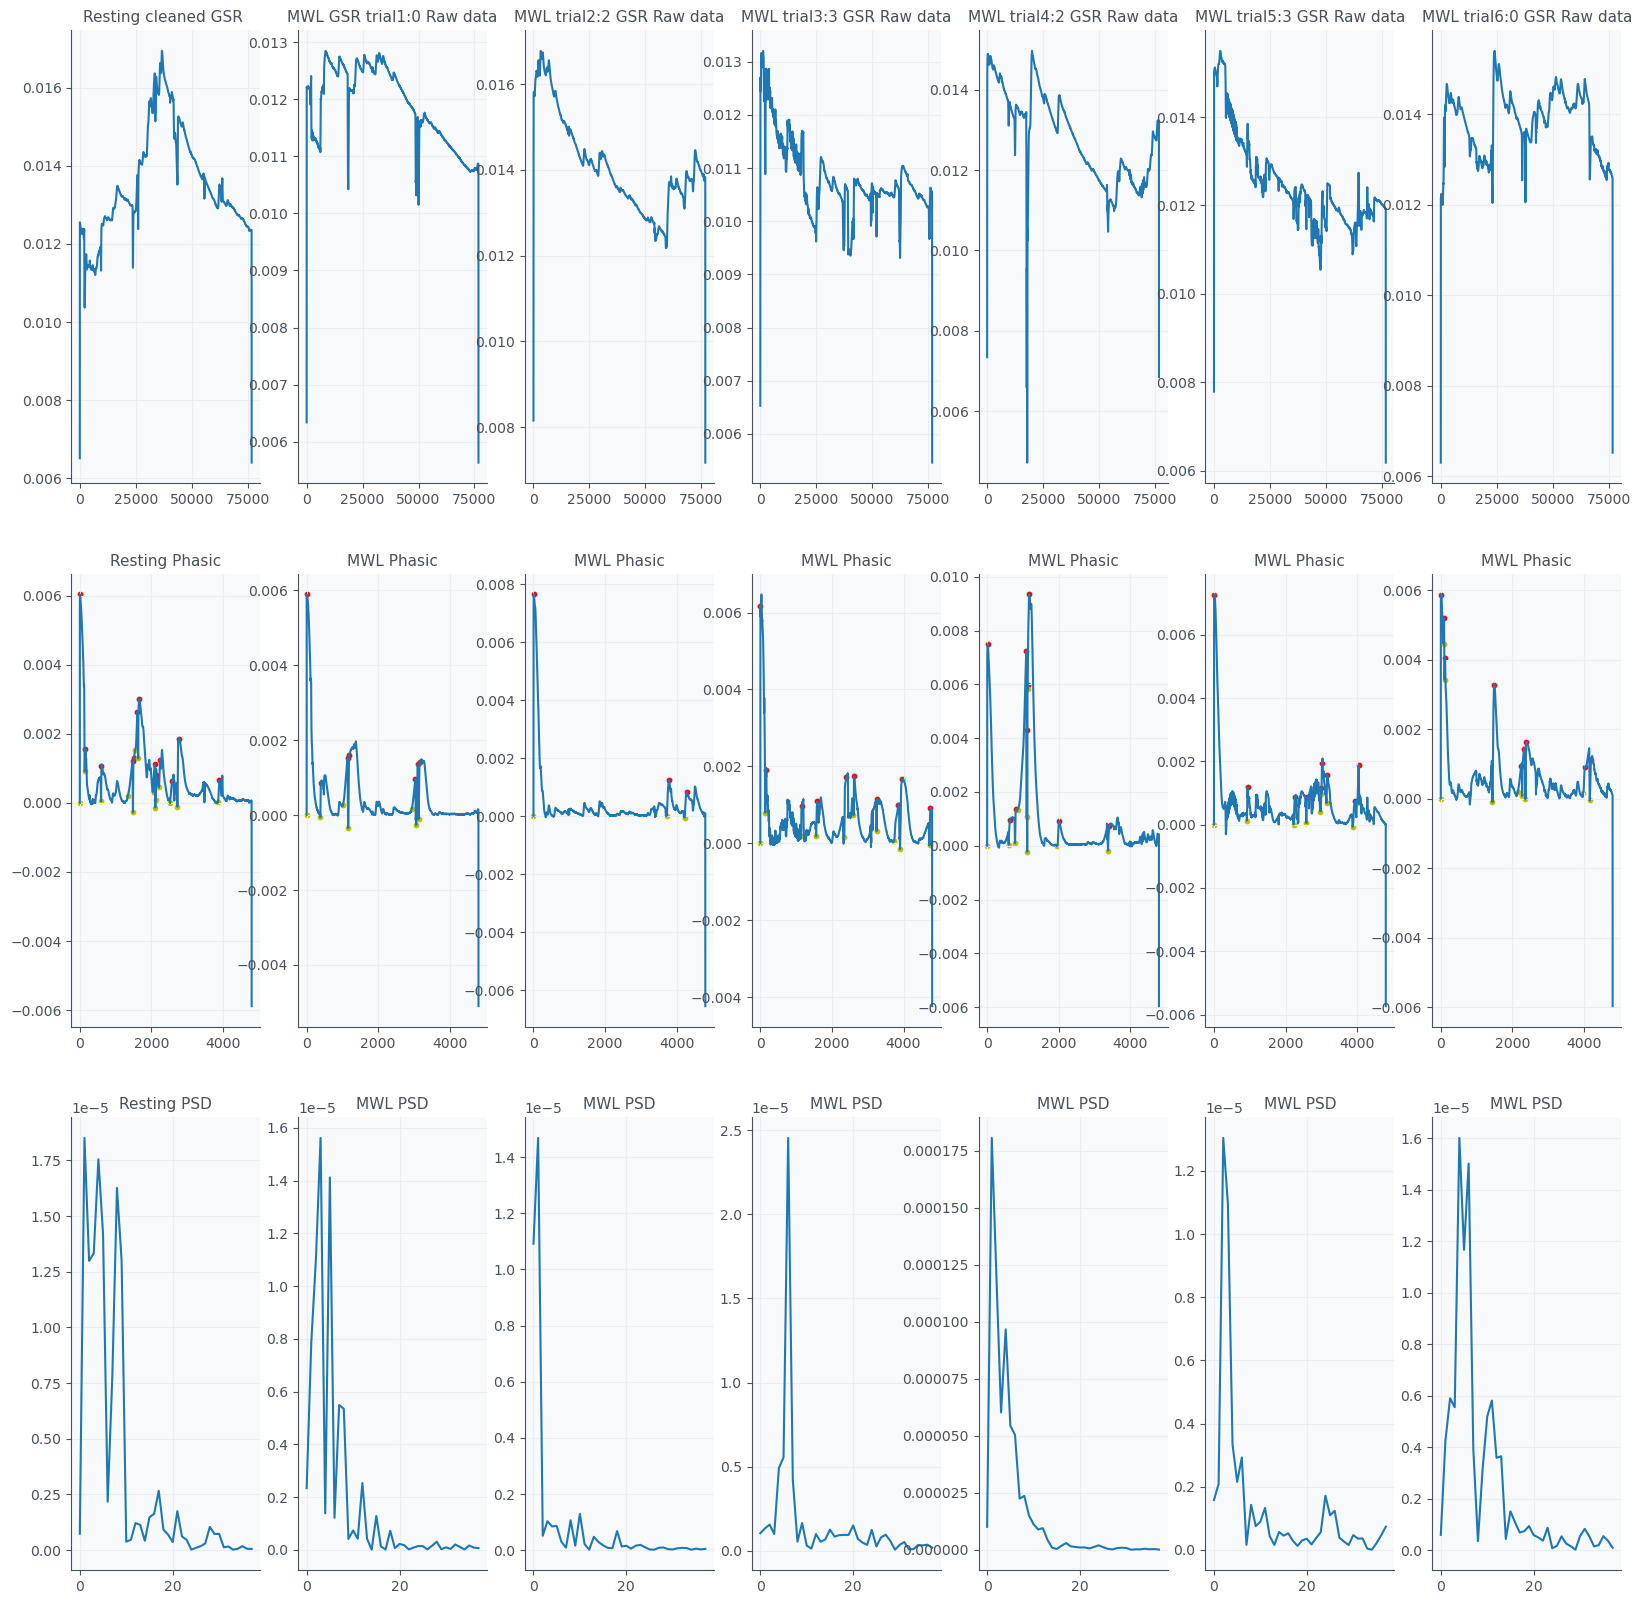

In [29]:
# Sampling freqency for this dataset is 100HZ for pixArt and 256HZ for inf

###############################################################################################################
###############################################################################################################
############################################  004 #############################################################
###############################################################################################################
###############################################################################################################


Fs = 256
print('**************************************************************************')
print('***************************** MWL 004 ************************************')
print('**************************************************************************')
####################################### During resting 5min ###################################################
Resting2 = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/004/inf_resting.csv','Resting_GSR')
# Clean and Extract some time domain features
r_clean_sig2 , r_Phasic2 , r_tonic2 , r_onset2 , r_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( Resting2 , 0.1 , a_plot=False )

plt.figure(figsize=(20, 20))
# Plot cleaned data
plt.subplot( 3 , 7 , 1  )
plt.title('Resting cleaned GSR ')
plt.plot(r_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 8 )
plt.title('Resting Phasic')
Plot_Phasic_with_onset_and_peaks( r_Phasic2 , r_onset2 , r_peaks2 )
# plot freqency componants
r_FFT2 , r_PSD2 , _ = Extract_frequency_Features( r_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 15 )
plt.title('Resting PSD')
plt.plot(r_PSD2)
print( f"PSD at resting = {np.mean(r_PSD2)}")
sympathetic =  nk.eda_sympathetic( r_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at Reasting = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( r_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN  = { sympatheticN } \n' )


####################################### During Mental work load Trial1 ###################################################
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/004/inf_gsr.csv', 'Trial 1:0back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 2  )
plt.title('MWL GSR trial1:0 Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 9 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 16 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial1:0 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial1:0 = { sympatheticN } \n' )


########## Trial2:2 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/004/inf_gsr.csv', 'Trial 2:2back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 3  )
plt.title('MWL trial2:2 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 10 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 17 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial2:2 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial2:2 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial2:2 = { sympatheticN } \n' )

########## Trial3:3 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/004/inf_gsr.csv', 'Trial 3:3back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 4  )
plt.title('MWL trial3:3 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 11 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 18 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial3:3 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial3:3 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial3:3 = { sympatheticN } \n' )


########## Trial4:2 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/004/inf_gsr.csv', 'Trial 4:2back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 5  )
plt.title('MWL trial4:2 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 12 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 19 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial4:2 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial4:2 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial4:2 = { sympatheticN } \n' )


########## Trial5:3 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/004/inf_gsr.csv', 'Trial 5:3back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 6  )
plt.title('MWL trial5:3 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 13 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 20 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial5:3 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial5:3 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial5:3 = { sympatheticN } \n' )


########## Trial6:0 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/004/inf_gsr.csv', 'Trial 6:0back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 7  )
plt.title('MWL trial6:0 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 14 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 21 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial6:0 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial6:0 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial6:0 = { sympatheticN } \n' )



**************************************************************************
***************************** MWL 008 ************************************
**************************************************************************
PSD at resting = 7.423754041956419e-10
sympathetic at resting = 1.871721741177282e-11
sympatheticN at resting = 0.0003878713967480731 

PSD at MWL = 1.7170568685307107e-09
sympathetic at trial1:0 = 1.8089624634343436e-11
sympatheticN at trial1:0 = 0.00014718026927529933 

PSD at MWL trial2:2 = 9.635092301318985e-09
sympathetic at trial2:2 = 3.9693402567894426e-11
sympatheticN at trial2:2 = 5.94634870869237e-05 

PSD at MWL trial3:3 = 2.6452150944390347e-08
sympathetic at trial3:3 = 3.051724780250078e-10
sympatheticN at trial3:3 = 0.00015495583778792424 

PSD at MWL trial4:2 = 6.956835478116464e-08
sympathetic at trial4:2 = 1.337429931865641e-09
sympatheticN at trial4:2 = 0.0003300010879815779 

PSD at MWL trial5:3 = 1.2395033330215548e-07
sympathetic at trial5:3 = 

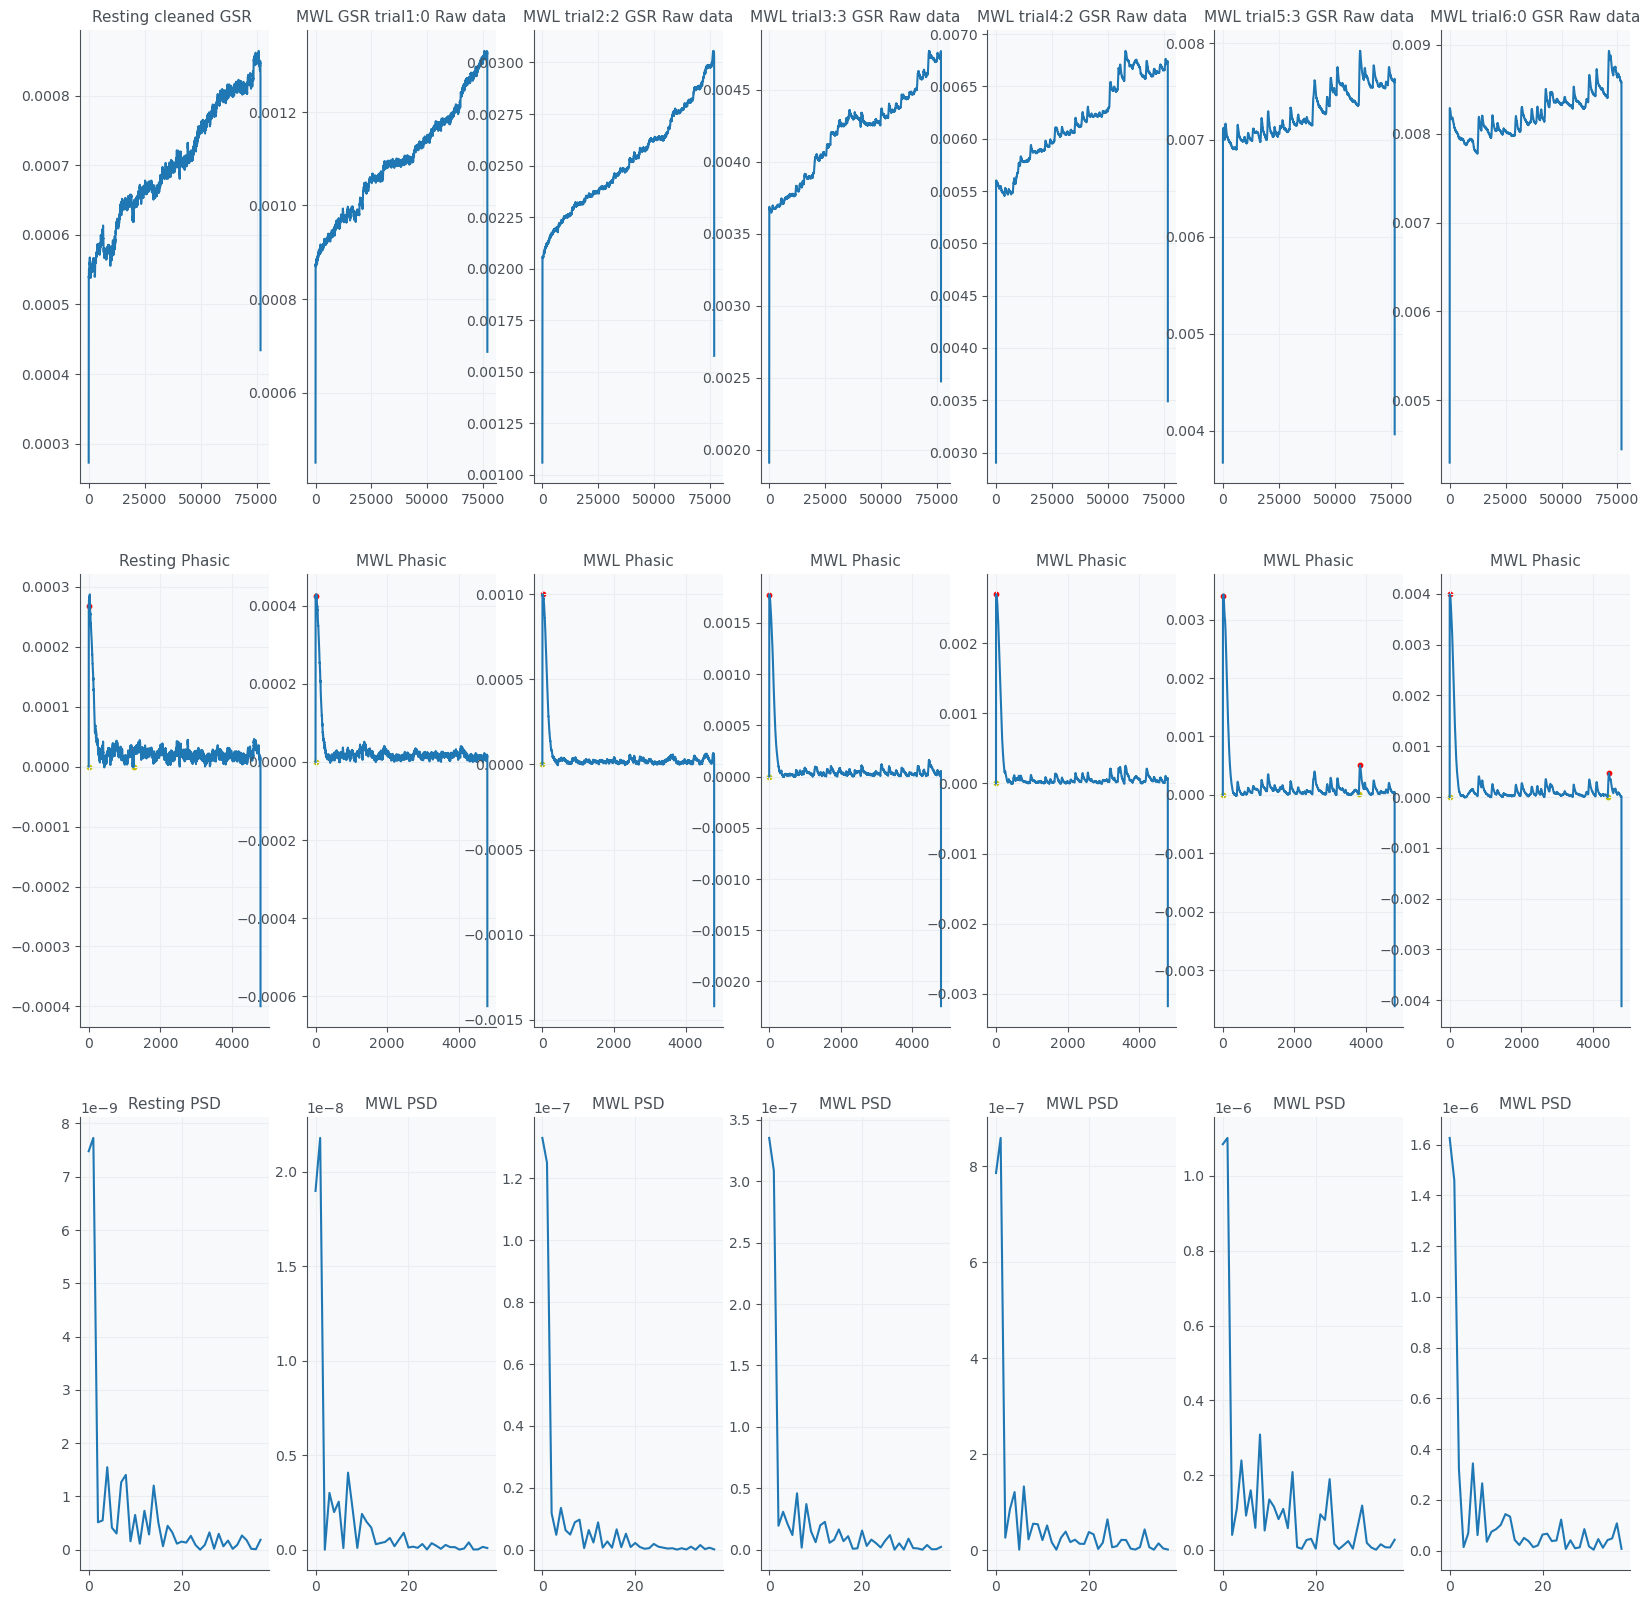

In [31]:


# Sampling freqency for this dataset is 100HZ for pixArt and 256HZ for inf

###############################################################################################################
###############################################################################################################
############################################  008 #############################################################
###############################################################################################################
###############################################################################################################


Fs = 256
print('**************************************************************************')
print('***************************** MWL 008 ************************************')
print('**************************************************************************')
####################################### During resting 5min ###################################################
Resting2 = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/008/inf_resting.csv','Resting_GSR')
# Clean and Extract some time domain features
r_clean_sig2 , r_Phasic2 , r_tonic2 , r_onset2 , r_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( Resting2 , 0.1 , a_plot=False )

plt.figure(figsize=(20, 20))
# Plot cleaned data
plt.subplot( 3 , 7 , 1  )
plt.title('Resting cleaned GSR ')
plt.plot(r_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 8 )
plt.title('Resting Phasic')
Plot_Phasic_with_onset_and_peaks( r_Phasic2 , r_onset2 , r_peaks2 )
# plot freqency componants
r_FFT2 , r_PSD2 , _ = Extract_frequency_Features( r_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 15 )
plt.title('Resting PSD')
plt.plot(r_PSD2)
print( f"PSD at resting = {np.mean(r_PSD2)}")
sympathetic =  nk.eda_sympathetic( r_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at resting = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( r_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at resting = { sympatheticN } \n' )


####################################### During Mental work load Trial1 ###################################################
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/008/inf_gsr.csv', 'Trial 1:0back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 2  )
plt.title('MWL GSR trial1:0 Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 9 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 16 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial1:0 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial1:0 = { sympatheticN } \n' )


########## Trial2:2 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/008/inf_gsr.csv', 'Trial 2:2back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 3  )
plt.title('MWL trial2:2 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 10 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 17 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial2:2 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial2:2 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial2:2 = { sympatheticN } \n' )


########## Trial3:3 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/008/inf_gsr.csv', 'Trial 3:3back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 4  )
plt.title('MWL trial3:3 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 11 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 18 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial3:3 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial3:3 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial3:3 = { sympatheticN } \n' )


########## Trial4:2 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/008/inf_gsr.csv', 'Trial 4:2back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 5  )
plt.title('MWL trial4:2 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 12 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 19 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial4:2 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial4:2 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial4:2 = { sympatheticN } \n' )


########## Trial5:3 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/008/inf_gsr.csv', 'Trial 5:3back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 6  )
plt.title('MWL trial5:3 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 13 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 20 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial5:3 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial5:3 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial5:3 = { sympatheticN } \n' )


########## Trial6:0 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/008/inf_gsr.csv', 'Trial 6:0back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 7  )
plt.title('MWL trial6:0 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 14 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 21 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial6:0 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial6:0 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial6:0 = { sympatheticN } \n' )


**************************************************************************
***************************** MWL 005 ************************************
**************************************************************************
PSD at resting = 2.395882854465264e-06
sympathetic at resting = 1.0153363299336606e-07
sympatheticN  = 0.003324546275216241 

PSD at MWL = 1.833008251688991e-05
sympathetic at trial1:0 = 1.8246036100944798e-06
sympatheticN at trial1:0 = 0.007052196881379588 

PSD at MWL trial2:2 = 4.0231759085683364e-05
sympathetic at trial2:2 = 3.0516063120372277e-06
sympatheticN at trial2:2 = 0.006211562305872976 

PSD at MWL trial3:3 = 3.700755200518272e-05
sympathetic at trial3:3 = 3.4820636697683287e-06
sympatheticN at trial3:3 = 0.00498676090133615 

PSD at MWL trial4:2 = 6.70342375856019e-05
sympathetic at trial4:2 = 4.06906372301921e-06
sympatheticN at trial4:2 = 0.007861689623194492 

PSD at MWL trial5:3 = 3.194011989986441e-05
sympathetic at trial5:3 = 2.6319719471152333e

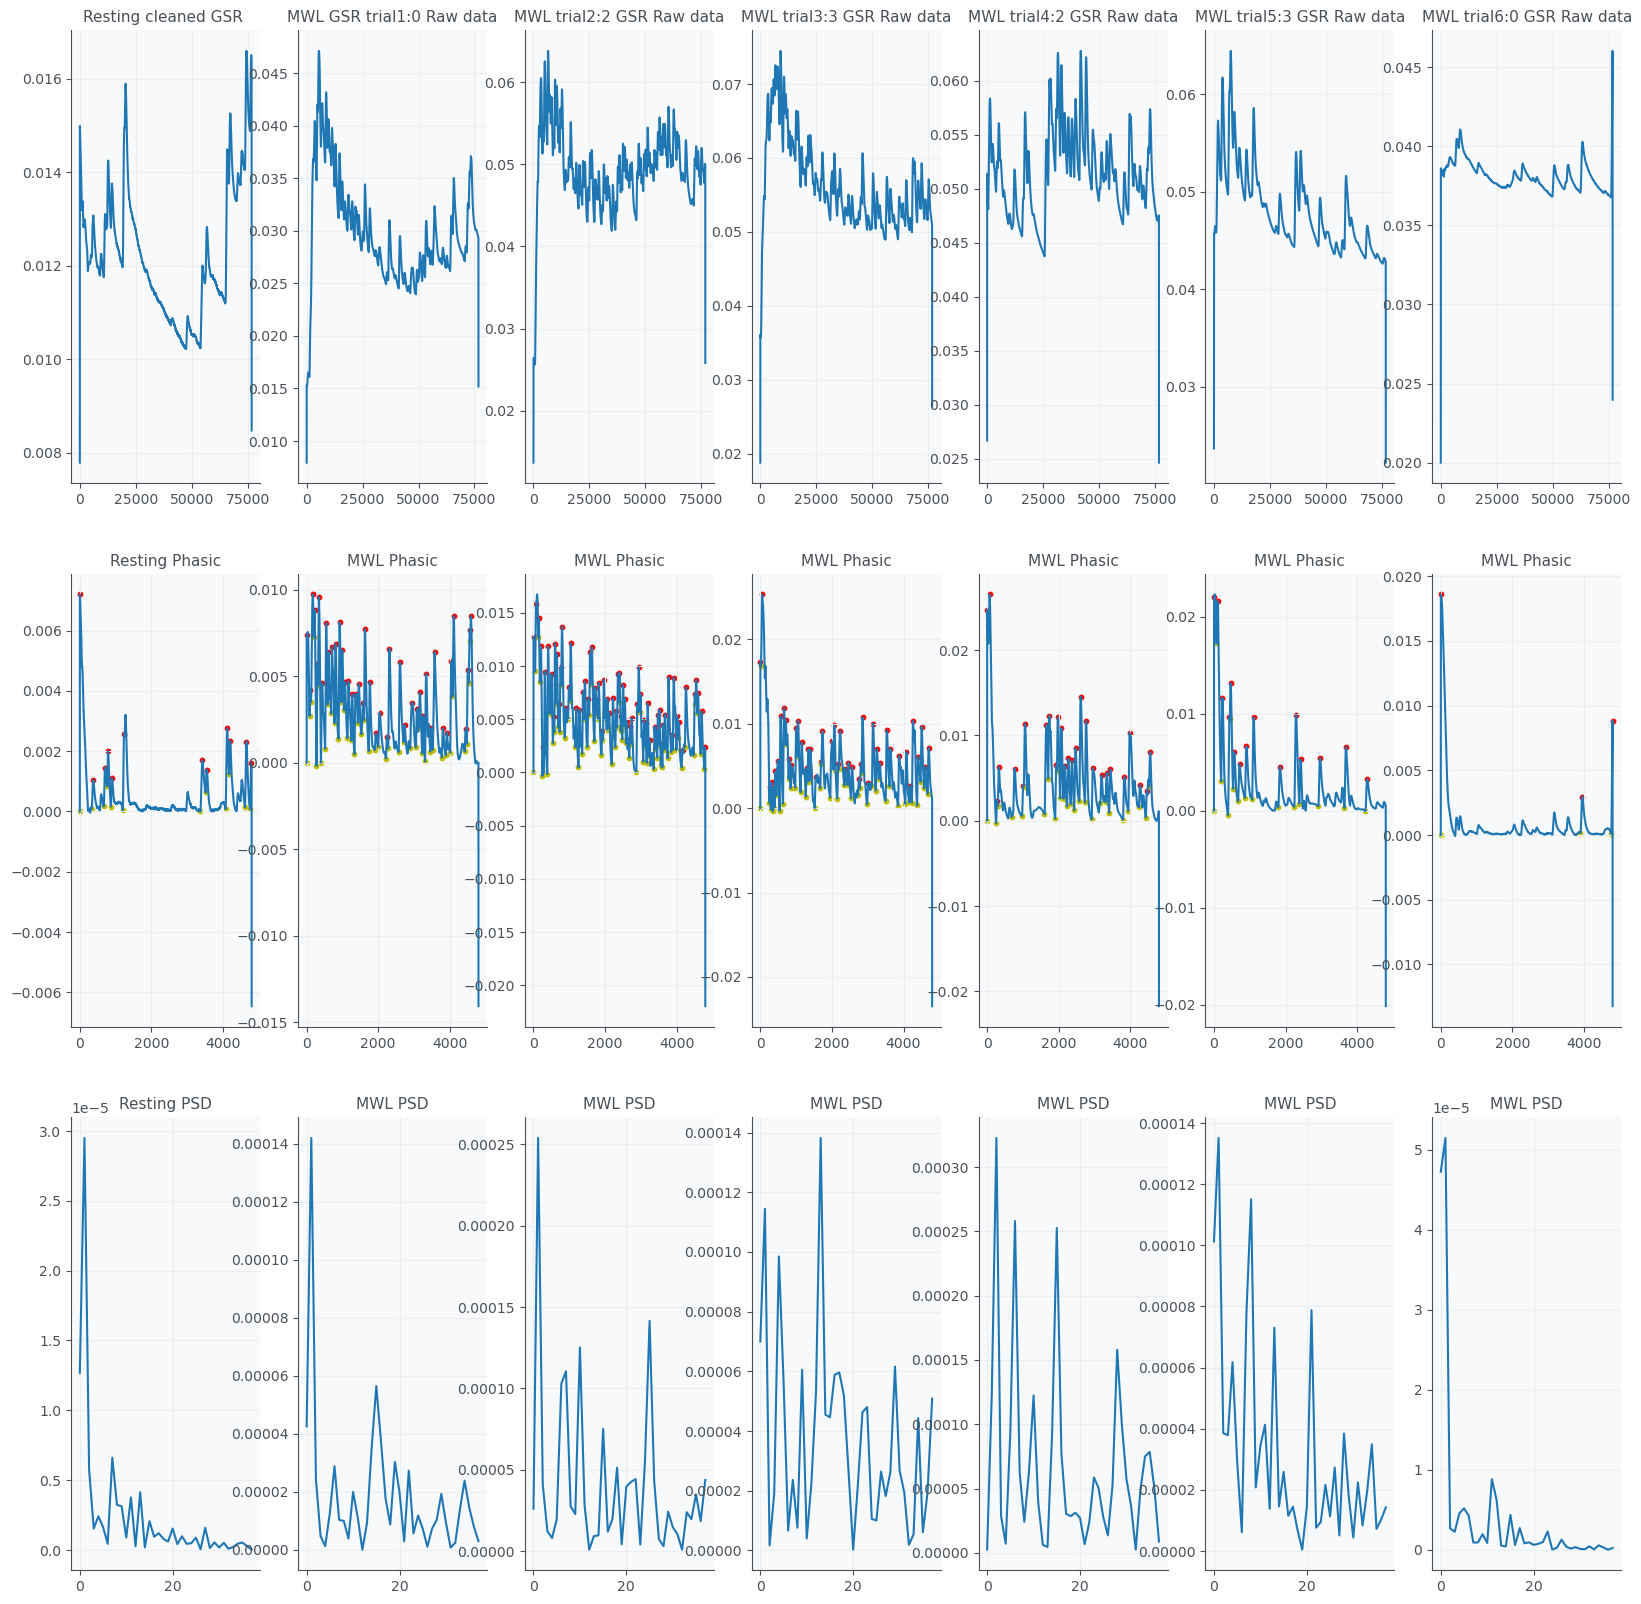

In [32]:


# Sampling freqency for this dataset is 100HZ for pixArt and 256HZ for inf

###############################################################################################################
###############################################################################################################
############################################  005 #############################################################
###############################################################################################################
###############################################################################################################


Fs = 256
print('**************************************************************************')
print('***************************** MWL 005 ************************************')
print('**************************************************************************')
####################################### During resting 5min ###################################################
Resting2 = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/005/inf_resting.csv','Resting_GSR')
# Clean and Extract some time domain features
r_clean_sig2 , r_Phasic2 , r_tonic2 , r_onset2 , r_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( Resting2 , 0.1 , a_plot=False )

plt.figure(figsize=(20, 20))
# Plot cleaned data
plt.subplot( 3 , 7 , 1  )
plt.title('Resting cleaned GSR ')
plt.plot(r_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 8 )
plt.title('Resting Phasic')
Plot_Phasic_with_onset_and_peaks( r_Phasic2 , r_onset2 , r_peaks2 )
# plot freqency componants
r_FFT2 , r_PSD2 , _ = Extract_frequency_Features( r_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 15 )
plt.title('Resting PSD')
plt.plot(r_PSD2)
print( f"PSD at resting = {np.mean(r_PSD2)}")
sympathetic =  nk.eda_sympathetic( r_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at resting = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( r_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN  = { sympatheticN } \n' )


####################################### During Mental work load Trial1 ###################################################
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/005/inf_gsr.csv', 'Trial 1:0back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 2  )
plt.title('MWL GSR trial1:0 Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 9 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 16 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial1:0 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial1:0 = { sympatheticN } \n' )


########## Trial2:2 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/005/inf_gsr.csv', 'Trial 2:2back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 3  )
plt.title('MWL trial2:2 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 10 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 17 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial2:2 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial2:2 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial2:2 = { sympatheticN } \n' )


########## Trial3:3 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/005/inf_gsr.csv', 'Trial 3:3back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 4  )
plt.title('MWL trial3:3 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 11 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 18 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial3:3 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial3:3 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial3:3 = { sympatheticN } \n' )


########## Trial4:2 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/005/inf_gsr.csv', 'Trial 4:2back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 5  )
plt.title('MWL trial4:2 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 12 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 19 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial4:2 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial4:2 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial4:2 = { sympatheticN } \n' )

########## Trial5:3 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/005/inf_gsr.csv', 'Trial 5:3back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 6  )
plt.title('MWL trial5:3 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 13 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 20 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial5:3 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial5:3 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial5:3 = { sympatheticN } \n' )


########## Trial6:0 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/005/inf_gsr.csv', 'Trial 6:0back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 7  )
plt.title('MWL trial6:0 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 14 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_Phasic2 , a_plot=False )
plt.subplot( 3 , 7 , 21 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial6:0 = {np.mean(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial6:0 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial6:0 = { sympatheticN } \n' )


**************************************************************************
***************************** MWL 010 ************************************
**************************************************************************
PSD at resting = 1.4634348084930862
sympathetic at resting = 4.8247684920911005e-06
sympatheticN  = 4.272102427043108e-05 

PSD at MWL = 0.02462201126002341
sympathetic at trial1:0 = 1.2494432525522643e-06
sympatheticN at trial1:0 = 2.0821256134173054e-05 

PSD at MWL trial2:2 = 1.7271674979963858
sympathetic at trial2:2 = 0.0004308718170567936
sympatheticN at trial2:2 = 0.0015668434747605298 

PSD at MWL trial3:3 = 3.1794029294310295
sympathetic at trial3:3 = 0.0004331123999266809
sympatheticN at trial3:3 = 0.00041432700830821407 

PSD at MWL trial4:2 = 2.9233397080495247
sympathetic at trial4:2 = 0.0017387944922624275
sympatheticN at trial4:2 = 0.0008789220996396692 

PSD at MWL trial5:3 = 4.01473835692906
sympathetic at trial5:3 = 0.004229732287976736
sympatheti

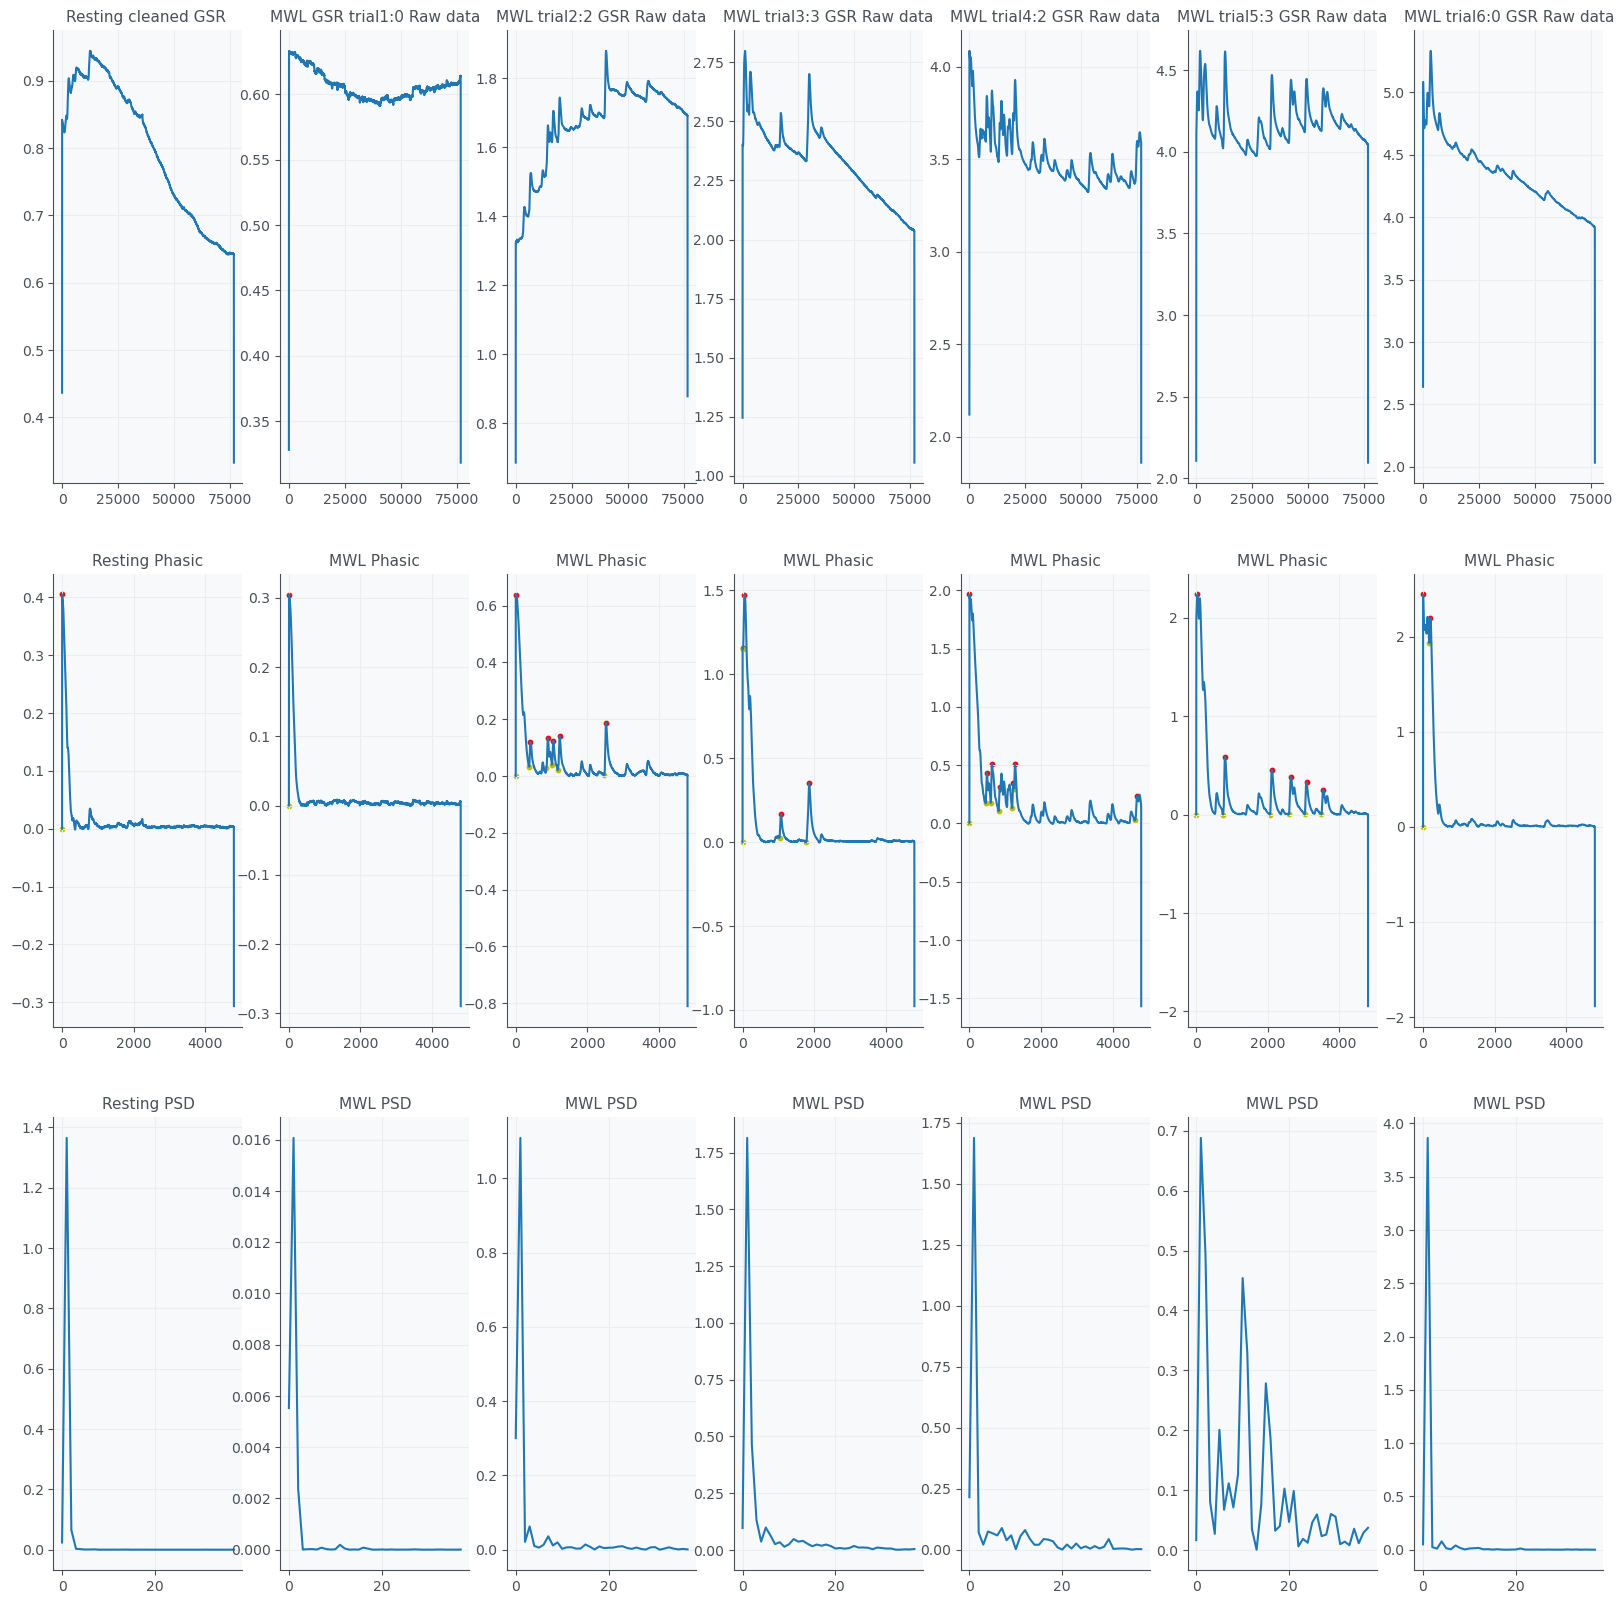

In [75]:
# Sampling freqency for this dataset is 100HZ for pixArt and 256HZ for inf

###############################################################################################################
###############################################################################################################
############################################  010 #############################################################
###############################################################################################################
###############################################################################################################


Fs = 256
print('**************************************************************************')
print('***************************** MWL 010 ************************************')
print('**************************************************************************')
####################################### During resting 5min ###################################################
Resting2 = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/010/inf_resting.csv','Resting_GSR')
# Clean and Extract some time domain features
r_clean_sig2 , r_Phasic2 , r_tonic2 , r_onset2 , r_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( Resting2 , 0.1 , a_plot=False )

plt.figure(figsize=(20, 20))
# Plot cleaned data
plt.subplot( 3 , 7 , 1  )
plt.title('Resting cleaned GSR ')
plt.plot(r_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 8 )
plt.title('Resting Phasic')
Plot_Phasic_with_onset_and_peaks( r_Phasic2 , r_onset2 , r_peaks2 )
# plot freqency componants
r_FFT2 , r_PSD2 , _ = Extract_frequency_Features( r_clean_sig2 , a_plot=False )
plt.subplot( 3 , 7 , 15 )
plt.title('Resting PSD')
plt.plot(r_PSD2)
print( f"PSD at resting = {sum(r_PSD2)}")
sympathetic =  nk.eda_sympathetic( r_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at resting = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( r_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN  = { sympatheticN } \n' )


####################################### During Mental work load Trial1 ###################################################
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/010/inf_gsr.csv', 'Trial 1:0back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 2  )
plt.title('MWL GSR trial1:0 Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 9 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_clean_sig2 , a_plot=False )
plt.subplot( 3 , 7 , 16 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL = {sum(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial1:0 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial1:0 = { sympatheticN } \n' )


########## Trial2:2 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/010/inf_gsr.csv', 'Trial 2:2back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 3  )
plt.title('MWL trial2:2 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 10 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_clean_sig2 , a_plot=False )
plt.subplot( 3 , 7 , 17 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial2:2 = {sum(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial2:2 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial2:2 = { sympatheticN } \n' )


########## Trial3:3 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/010/inf_gsr.csv', 'Trial 3:3back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 4  )
plt.title('MWL trial3:3 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 11 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_clean_sig2 , a_plot=False )
plt.subplot( 3 , 7 , 18 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial3:3 = {sum(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial3:3 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial3:3 = { sympatheticN } \n' )


########## Trial4:2 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/010/inf_gsr.csv', 'Trial 4:2back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 5  )
plt.title('MWL trial4:2 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 12 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_clean_sig2 , a_plot=False )
plt.subplot( 3 , 7 , 19 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial4:2 = {sum(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial4:2 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial4:2 = { sympatheticN } \n' )

########## Trial5:3 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/010/inf_gsr.csv', 'Trial 5:3back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 6  )
plt.title('MWL trial5:3 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 13 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_clean_sig2 , a_plot=False )
plt.subplot( 3 , 7 , 20 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial5:3 = {sum(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial5:3 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial5:3 = { sympatheticN } \n' )

########## Trial6:0 ##########
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/010/inf_gsr.csv', 'Trial 6:0back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 7 , 7  )
plt.title('MWL trial6:0 GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 7 , 14 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_clean_sig2 , a_plot=False )
plt.subplot( 3 , 7 , 21 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL trial6:0 = {sum(m_PSD2)}")
sympathetic =  nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_Sympathetic'] 
print( f'sympathetic at trial6:0 = { sympathetic }' )
sympatheticN = nk.eda_sympathetic( m_clean_sig2 , sampling_rate=Fs )['EDA_SympatheticN'] 
print( f'sympatheticN at trial6:0 = { sympatheticN } \n' )


**************************************************************************
************************** MWL 002 tial2:2 *******************************
**************************************************************************
PSD at MWL = 21.309611996519813


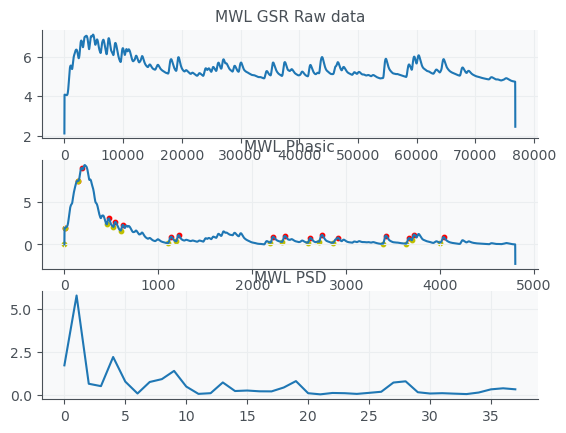

In [39]:


# Sampling freqency for this dataset is 100HZ for pixArt and 256HZ for inf

###############################################################################################################
###############################################################################################################
############################################  002 #############################################################
###############################################################################################################
###############################################################################################################


Fs = 256
print('**************************************************************************')
print('************************** MWL 002 tial2:2 *******************************')
print('**************************************************************************')

####################################### During Mental work load Trial1 ###################################################
MWL2  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv', 'Trial 2:2back')
m_clean_sig2 , m_Phasic2 , m_tonic2 , m_onset2 , m_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL2 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 1 , 1  )
plt.title('MWL GSR Raw data')
plt.plot(m_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 1 , 2 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic2 , m_onset2 , m_peaks2 )
# plot freqency componants
m_FFT2 , m_PSD2 , _ = Extract_frequency_Features( m_clean_sig2 , a_plot=False )
plt.subplot( 3 , 1 , 3 )
plt.title('MWL PSD')
plt.plot(m_PSD2)
print( f"PSD at MWL = {sum(m_PSD2)}")



**************************************************************************
***************************** MWL 004 ************************************
**************************************************************************
PSD at resting = 7.790694655692746
PSD at MWL = 0.9914959861310644


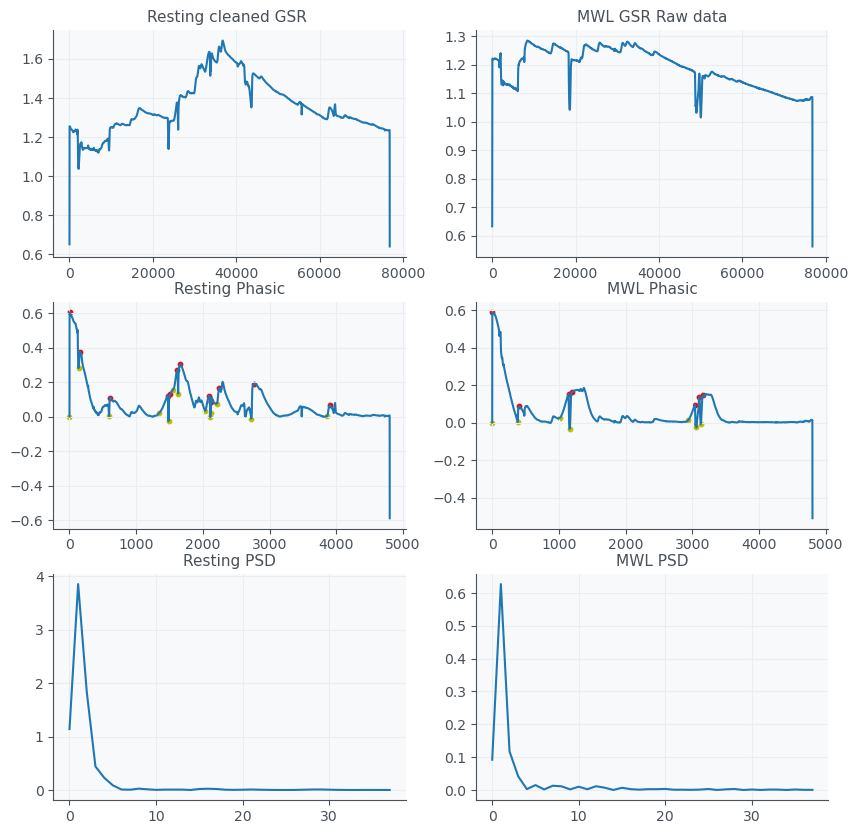

In [31]:
# Sampling freqency for this dataset is 100HZ for pixArt and 256HZ for inf

###############################################################################################################
###############################################################################################################
############################################  004 #############################################################
###############################################################################################################
###############################################################################################################

Fs = 256
print('**************************************************************************')
print('***************************** MWL 004 ************************************')
print('**************************************************************************')
####################################### During resting 5min ###################################################
Resting4 = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/004/inf_resting.csv','Resting_GSR')
# Clean and Extract some time domain features
r_clean_sig4 , r_Phasic4 , r_tonic4 , r_onset4 , r_peaks4 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( Resting4 , 0.1 , a_plot=False )

plt.figure(figsize=(10, 10))
# Plot cleaned data
plt.subplot( 3 , 2 , 1  )
plt.title('Resting cleaned GSR ')
plt.plot(r_clean_sig4)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 2 , 3 )
plt.title('Resting Phasic')
Plot_Phasic_with_onset_and_peaks( r_Phasic4 , r_onset4 , r_peaks4 )
# plot freqency componants
r_FFT4 , r_PSD4 , _ = Extract_frequency_Features( r_clean_sig4 , a_plot=False )
plt.subplot( 3 , 2 , 5 )
plt.title('Resting PSD')
plt.plot(r_PSD4)
print( f"PSD at resting = {sum(r_PSD4)}")



####################################### During Mental work load Trial1 ###################################################
MWL4  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/004/inf_gsr.csv', 'Trial 1:0back')
m_clean_sig4 , m_Phasic4 , m_tonic4 , m_onset4 , m_peaks4 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL4 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 2 , 2  )
plt.title('MWL GSR Raw data')
plt.plot(m_clean_sig4)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 2 , 4 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic4 , m_onset4 , m_peaks4 )
# plot freqency componants
m_FFT4 , m_PSD4 , _ = Extract_frequency_Features( m_clean_sig4 , a_plot=False )
plt.subplot( 3 , 2 , 6 )
plt.title('MWL PSD')
plt.plot(m_PSD4)
print( f"PSD at MWL = {sum(m_PSD4)}")



**************************************************************************
***************************** MWL 005 ************************************
**************************************************************************
PSD at resting = 0.000504201162860198
PSD at MWL = 0.002954894299029179


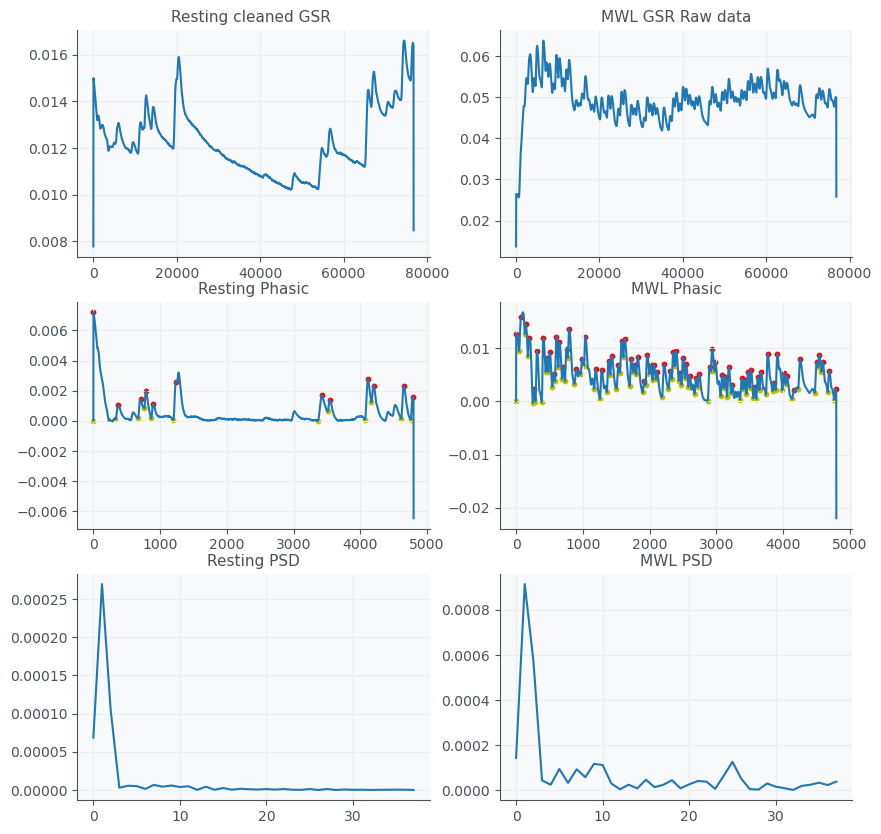

In [27]:
# Sampling freqency for this dataset is 100HZ for pixArt and 256HZ for inf

###############################################################################################################
###############################################################################################################
############################################  005 #############################################################
###############################################################################################################
###############################################################################################################

Fs = 256
print('**************************************************************************')
print('***************************** MWL 005 ************************************')
print('**************************************************************************')
####################################### During resting 5min ###################################################
Resting5 = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/005/inf_resting.csv','Resting_GSR')
# Clean and Extract some time domain features
r_clean_sig5 , r_Phasic5 , r_tonic5 , r_onset5 , r_peaks5 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( Resting5 , 0.1 , a_plot=False )

plt.figure(figsize=(10, 10))
# Plot cleaned data
plt.subplot( 3 , 2 , 1  )
plt.title('Resting cleaned GSR ')
plt.plot(r_clean_sig5)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 2 , 3 )
plt.title('Resting Phasic')
Plot_Phasic_with_onset_and_peaks( r_Phasic5 , r_onset5 , r_peaks5 )
# plot freqency componants
r_FFT5 , r_PSD5 , _ = Extract_frequency_Features( r_clean_sig5 , a_plot=False )
plt.subplot( 3 , 2 , 5 )
plt.title('Resting PSD')
plt.plot(r_PSD5)
print( f"PSD at resting = {sum(r_PSD5)}")



####################################### During Mental work load Trial1 ###################################################
MWL5  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/005/inf_gsr.csv', 'Trial 2:2back')
m_clean_sig5 , m_Phasic5 , m_tonic5 , m_onset5 , m_peaks5 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL5 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 2 , 2  )
plt.title('MWL GSR Raw data')
plt.plot(m_clean_sig5)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 2 , 4 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic5 , m_onset5 , m_peaks5 )
# plot freqency componants
m_FFT5 , m_PSD5 , _ = Extract_frequency_Features( m_clean_sig5 , a_plot=False )
plt.subplot( 3 , 2 , 6 )
plt.title('MWL PSD')
plt.plot(m_PSD5)
print( f"PSD at MWL = {sum(m_PSD5)}")



In [38]:
# # Sampling freqency for this dataset is 100HZ for pixArt and 256HZ for inf

# ###############################################################################################################
# ###############################################################################################################
# ############################################  005 #############################################################
# ###############################################################################################################
# ###############################################################################################################

# Fs = 256
# print('**************************************************************************')
# print('***************************** MWL 006 ************************************')
# print('**************************************************************************')
# ####################################### During resting 5min ###################################################
# Resting6 = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/006/inf_resting.csv','Resting_GSR')
# # Clean and Extract some time domain features
# r_clean_sig6 , r_Phasic6 , r_tonic6 , r_onset6 , r_peaks6 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( Resting6 , 0.1 , a_plot=False )

# plt.figure(figsize=(10, 10))
# # Plot cleaned data
# plt.subplot( 3 , 2 , 1  )
# plt.title('Resting cleaned GSR ')
# plt.plot(r_clean_sig6)
# # Plot Phasic componants with onsets and peaks
# plt.subplot( 3 , 2 , 3 )
# plt.title('Resting Phasic')
# Plot_Phasic_with_onset_and_peaks( r_Phasic6 , r_onset6 , r_peaks6 )
# # plot freqency componants
# r_FFT6 , r_PSD6 , _ = Extract_frequency_Features( r_clean_sig6 , a_plot=False )
# plt.subplot( 3 , 2 , 5 )
# plt.title('Resting PSD')
# plt.plot(r_PSD6)
# print( f"PSD at resting = {sum(r_PSD6)}")



# ####################################### During Mental work load Trial1 ###################################################
# MWL6  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/006/inf_gsr.csv', 'Trial 1:0back')
# m_clean_sig6 , m_Phasic6 , m_tonic6 , m_onset6 , m_peaks6 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL6 , 0.1 , a_plot=False )

# # Plot cleaned data
# plt.subplot( 3 , 2 , 2  )
# plt.title('MWL GSR Raw data')
# plt.plot(m_clean_sig6)
# # Plot Phasic componants with onsets and peaks
# plt.subplot( 3 , 2 , 4 )
# plt.title('MWL Phasic')
# Plot_Phasic_with_onset_and_peaks( m_Phasic6 , m_onset6 , m_peaks6 )
# # plot freqency componants
# m_FFT6 , m_PSD6 , _ = Extract_frequency_Features( m_clean_sig6 , a_plot=False )
# plt.subplot( 3 , 2 , 6 )
# plt.title('MWL PSD')
# plt.plot(m_PSD6)
# print( f"PSD at MWL = {sum(m_PSD6)}")



**************************************************************************
***************************** MWL 008 ************************************
**************************************************************************
PSD at resting = 0.0056882494752512796
PSD at MWL = 0.007980332873490065


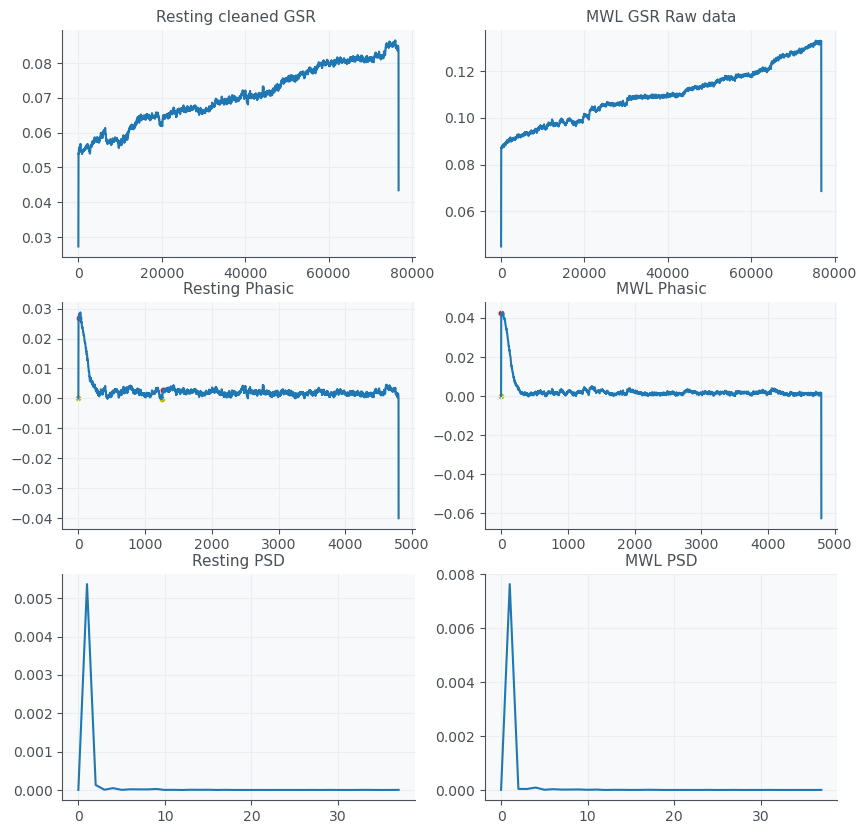

In [34]:
# Sampling freqency for this dataset is 100HZ for pixArt and 256HZ for inf

###############################################################################################################
###############################################################################################################
############################################  008 #############################################################
###############################################################################################################
###############################################################################################################

Fs = 256
print('**************************************************************************')
print('***************************** MWL 008 ************************************')
print('**************************************************************************')
####################################### During resting 5min ###################################################
Resting8 = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/008/inf_resting.csv','Resting_GSR')
# Clean and Extract some time domain features
r_clean_sig8 , r_Phasic8 , r_tonic8 , r_onset8 , r_peaks8 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( Resting8 , 0.1 , a_plot=False )

plt.figure(figsize=(10, 10))
# Plot cleaned data
plt.subplot( 3 , 2 , 1  )
plt.title('Resting cleaned GSR ')
plt.plot(r_clean_sig8)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 2 , 3 )
plt.title('Resting Phasic')
Plot_Phasic_with_onset_and_peaks( r_Phasic8 , r_onset8 , r_peaks8 )
# plot freqency componants
r_FFT8 , r_PSD8 , _ = Extract_frequency_Features( r_clean_sig8 , a_plot=False )
plt.subplot( 3 , 2 , 5 )
plt.title('Resting PSD')
plt.plot(r_PSD8)
print( f"PSD at resting = {sum(r_PSD8)}")



####################################### During Mental work load Trial1 ###################################################
MWL8  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/008/inf_gsr.csv', 'Trial 1:0back')
m_clean_sig8 , m_Phasic8 , m_tonic8 , m_onset8 , m_peaks8 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL8 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 2 , 2  )
plt.title('MWL GSR Raw data')
plt.plot(m_clean_sig8)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 2 , 4 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic8 , m_onset8 , m_peaks8 )
# plot freqency componants
m_FFT8 , m_PSD8 , _ = Extract_frequency_Features( m_clean_sig8 , a_plot=False )
plt.subplot( 3 , 2 , 6 )
plt.title('MWL PSD')
plt.plot(m_PSD8)
print( f"PSD at MWL = {sum(m_PSD8)}")



**************************************************************************
***************************** MWL 0010 ************************************
**************************************************************************
PSD at resting = 1.4634348084930862
PSD at MWL = 0.02462201126002341


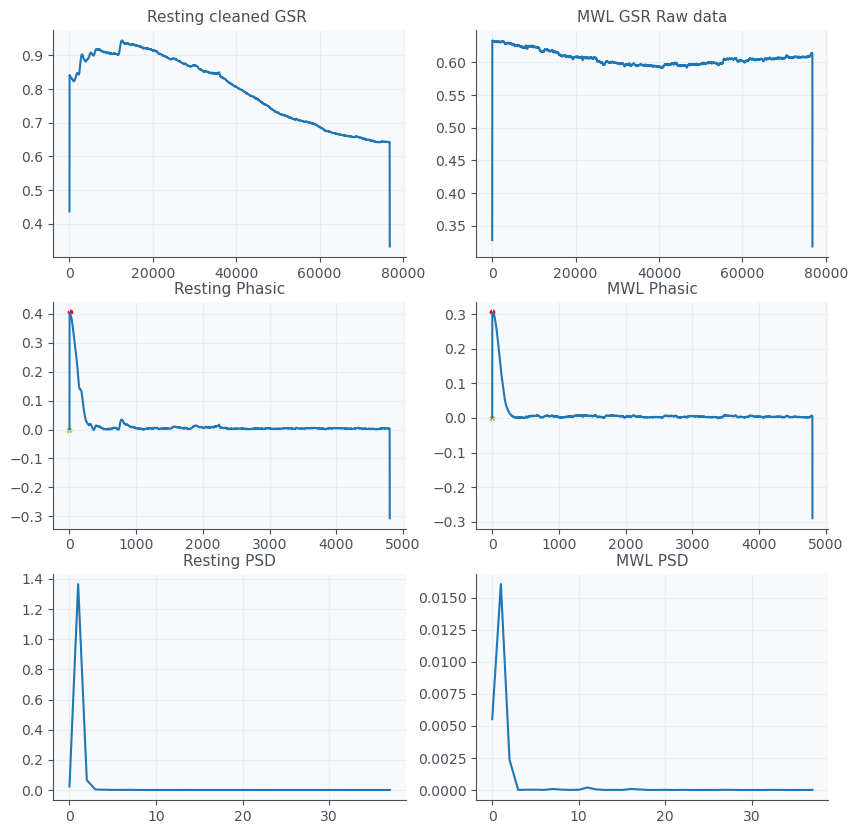

In [37]:
# Sampling freqency for this dataset is 100HZ for pixArt and 256HZ for inf

###############################################################################################################
###############################################################################################################
############################################  010 #############################################################
###############################################################################################################
###############################################################################################################

Fs = 256
print('**************************************************************************')
print('***************************** MWL 010 ************************************')
print('**************************************************************************')
####################################### During resting 5min ###################################################
Resting10 = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/010/inf_resting.csv','Resting_GSR')
# Clean and Extract some time domain features
r_clean_sig10 , r_Phasic10 , r_tonic10 , r_onset10 , r_peaks10 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( Resting10 , 0.1 , a_plot=False )

plt.figure(figsize=(10, 10))
# Plot cleaned data
plt.subplot( 3 , 2 , 1  )
plt.title('Resting cleaned GSR ')
plt.plot(r_clean_sig10)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 2 , 3 )
plt.title('Resting Phasic')
Plot_Phasic_with_onset_and_peaks( r_Phasic10 , r_onset10 , r_peaks10 )
# plot freqency componants
r_FFT10 , r_PSD10 , _ = Extract_frequency_Features( r_clean_sig10 , a_plot=False )
plt.subplot( 3 , 2 , 5 )
plt.title('Resting PSD')
plt.plot(r_PSD10)
print( f"PSD at resting = {sum(r_PSD10)}")



####################################### During Mental work load Trial1 ###################################################
MWL10  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/010/inf_gsr.csv', 'Trial 1:0back')
m_clean_sig10 , m_Phasic10 , m_tonic10 , m_onset10 , m_peaks10 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL10 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 2 , 2  )
plt.title('MWL GSR Raw data')
plt.plot(m_clean_sig10)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 2 , 4 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic10 , m_onset10 , m_peaks10 )
# plot freqency componants
m_FFT10 , m_PSD10 , _ = Extract_frequency_Features( m_clean_sig10 , a_plot=False )
plt.subplot( 3 , 2 , 6 )
plt.title('MWL PSD')
plt.plot(m_PSD10)
print( f"PSD at MWL = {sum(m_PSD10)}")



**************************************************************************
************************** MWL 0010 tial2:2 ******************************
**************************************************************************
PSD at MWL = 1.7271674979963858


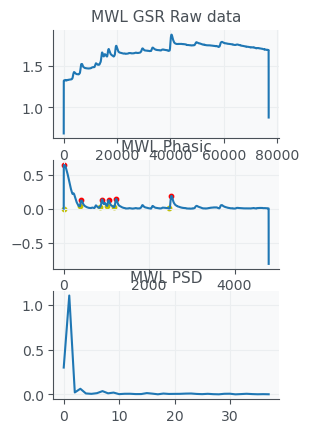

In [40]:
# Sampling freqency for this dataset is 100HZ for pixArt and 256HZ for inf

###############################################################################################################
###############################################################################################################
############################################  0010 #############################################################
###############################################################################################################
###############################################################################################################

Fs = 256
print('**************************************************************************')
print('************************** MWL 010 tial2:2 ******************************')
print('**************************************************************************')

####################################### During Mental work load Trial1 ###################################################
MWL10  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/010/inf_gsr.csv', 'Trial 2:2back')
m_clean_sig10 , m_Phasic10 , m_tonic10 , m_onset10 , m_peaks10 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( MWL10 , 0.1 , a_plot=False )

# Plot cleaned data
plt.subplot( 3 , 2 , 1  )
plt.title('MWL GSR Raw data')
plt.plot(m_clean_sig10)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 2 , 2 )
plt.title('MWL Phasic')
Plot_Phasic_with_onset_and_peaks( m_Phasic10 , m_onset10 , m_peaks10 )
# plot freqency componants
m_FFT10 , m_PSD10 , _ = Extract_frequency_Features( m_clean_sig10 , a_plot=False )
plt.subplot( 3 , 2 , 3 )
plt.title('MWL PSD')
plt.plot(m_PSD10)
print( f"PSD at MWL = {sum(m_PSD10)}")



Stress dataset

**************************************************************************
***************************** stress S1 ************************************
**************************************************************************
PSD  = 197.14046456353844


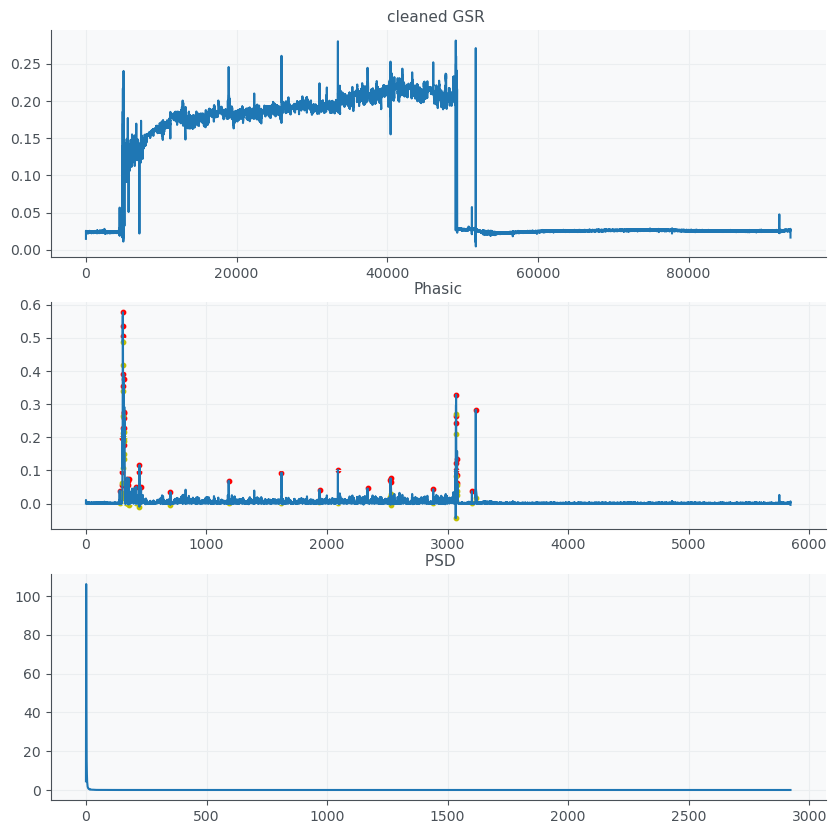

In [162]:
# Sampling freqency for this dataset is 4HZ

###############################################################################################################
###############################################################################################################
############################################ S1   #############################################################
###############################################################################################################
###############################################################################################################


print('**************************************************************************')
print('***************************** stress S1 ************************************')
print('**************************************************************************')


stress1 = Get_dataFromExcel( '../../../datasets/Stress/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data/S1/Final/EDA.csv')
Fs = int(stress1[0]) # Get sampling freqency
stress1 = stress1[60:]

# Clean and Extract some time domain features
s_clean_sig1 , s_Phasic1 , s_tonic1 , s_onset1 , s_peaks1 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( stress1 , 0.1 , a_plot=False )

plt.figure(figsize=(10, 10))
# Plot cleaned data
plt.subplot( 3 , 1 , 1  )
plt.title('cleaned GSR ')
plt.plot(s_clean_sig1)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 1 , 2 )
plt.title('Phasic')
Plot_Phasic_with_onset_and_peaks( s_Phasic1 , s_onset1 , s_peaks1 )
# plot freqency componants
s_FFT1 , s_PSD1 , _ = Extract_frequency_Features( s_clean_sig1 , a_plot=False )
plt.subplot( 3 , 1 , 3 )
plt.title(' PSD')
plt.plot(s_PSD1)
print( f"PSD  = {sum(s_PSD1)}")


**************************************************************************
***************************** stress S2 ************************************
**************************************************************************
PSD  = 219.83659117362473


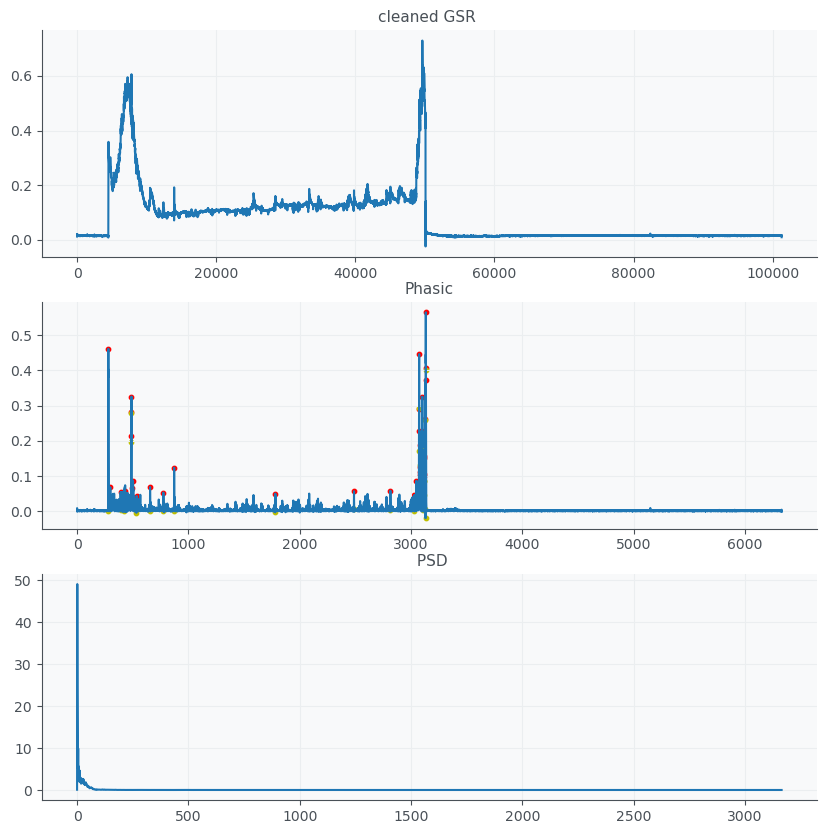

In [163]:
# Sampling freqency for this dataset is 4HZ

###############################################################################################################
###############################################################################################################
############################################ S2  ##############################################################
###############################################################################################################
###############################################################################################################


print('**************************************************************************')
print('***************************** stress S2 ************************************')
print('**************************************************************************')


stress2 = Get_dataFromExcel( '../../../datasets/Stress/a-wearable-exam-stress-dataset-for-predicting-cognitive-performance-in-real-world-settings-1.0.0/Data/S2/Final/EDA.csv')
Fs = int(stress2[0]) # Get sampling freqency
stress2 = stress2[60:]

# Clean and Extract some time domain features
s_clean_sig2 , s_Phasic2 , s_tonic2 , s_onset2 , s_peaks2 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( stress2 , 0.1 , a_plot=False )

plt.figure(figsize=(10, 10))
# Plot cleaned data
plt.subplot( 3 , 1 , 1  )
plt.title('cleaned GSR ')
plt.plot(s_clean_sig2)
# Plot Phasic componants with onsets and peaks
plt.subplot( 3 , 1 , 2 )
plt.title('Phasic')
Plot_Phasic_with_onset_and_peaks( s_Phasic2 , s_onset2 , s_peaks2 )
# plot freqency componants
s_FFT2 , s_PSD2 , _ = Extract_frequency_Features( s_clean_sig2 , a_plot=False )
plt.subplot( 3 , 1 , 3 )
plt.title(' PSD')
plt.plot(s_PSD2)
print( f"PSD  = {sum(s_PSD2)}")


In [72]:
tt = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv', 'Trial 1:0back')
c_tt , m_Phasic4 , m_tonic4 , m_onset4 , m_peaks4 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( tt , 0.1 , a_plot=False )
s_FFT2 , ll_psd , _ = Extract_frequency_Features( c_tt , a_plot=False )


sum(ll_psd)

3.9501448909321373

In [73]:
tt = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv', 'Trial 1:0back')
c_tt , m_Phasic4 , m_tonic4 , m_onset4 , m_peaks4 , _ = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime( tt , 0.1 , a_plot=False )
s_FFT2 , ll_psd , _ = Extract_frequency_Features( x , a_plot=False )


sum(ll_psd)

95237.79014906702

# Make windowing and split it

In [20]:
"""
   Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75
   
   This function takes signal, window size and overlab and make windowing on it
   
   It Extracts some features from GSR signal which are Mean, max, min
   slop, peak number, peak mean, peak 25% percentile, peak 50% percentile and
   peak 75% percentile then returns them 
   
"""

def WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( a_x , a_window_size , a_overlap , a_plot=True , a_plot2=True ):
    
#     plt.plot(a_x)
    # Change list to an array
    a_x = np.asarray(a_x)
    a_y = np.linspace(0, len(a_x)-1 , len(a_x) )
 
    
    # Get peaks of signal
    l_clean_sig , l_phasic , l_tonic , l_onset  , l_peak, l_rise_time = Ledapy_GSR_ExtractPhasicTonic_Onset_Peaks_risetime(  np.array(a_x) , 0.1 , False ) 

    
    # Make windowing on clean signal
    a_x = windowed_view( l_clean_sig , a_window_size , a_overlap )
    a_y = windowed_view( a_y , a_window_size , a_overlap )

    # Calculate mean, max and min
    l_mean  = np.mean( a_x , axis=-1 )   # Get mean of data
    l_max   = np.max ( a_x , axis=-1 )   # Get max  of data
    l_min   = np.min ( a_x , axis=-1 )   # Get min  of data
    
    # Calculate slop
    l_slope = ((a_x*a_y).mean(axis=-1) - a_x.mean()*a_y.mean(axis=-1)) / ((a_x**2).mean() - (a_y.mean())**2) # Linear regression slop
    
    # Calculate freqency features
    l_fft = []
    l_psd = []
    l_spectogram_sxx = []
    
    for i in range( len(l_mean) ): # Loop for each window
        l_temp_fft , l_temp_psd , l_temp_spectogram_sxx = Extract_frequency_Features( a_x[i] , a_plot=False )
        l_fft.append( l_temp_fft )
        l_psd.append( l_temp_psd )
        l_spectogram_sxx.append( l_temp_spectogram_sxx )
        
    
    l_peaks_numb = []
    l_peaks_mean = []
    l_peaks_25 = []
    l_peaks_50 = []
    l_peaks_75 = []
    l_sympathetic = []
    l_sympatheticN = []
    l_sum_of_peak_duration  = []  # Is the diffrence between two peaks
    l_sum_of_peak_magnitude = []  # Is the sum of magnitude of peaks
    l_sum_of_peak_area      = []  # Is the sum of peaks area (magnitude*duration)
    
    
    ####################### Extracting peaks features #####################
    
   
    for i in range( 0 , a_x.shape[0] ): # Loop number of windows times
        # First get peak for each window
        l_window_peaks = []  # Empty the peaks list
        for j in range( 0 , len(l_peak) ): # loop on peaks list to know peaks in this window
            if( l_peak[j] in a_y[i] ):
                l_window_peaks.append(l_peak[j])
   
        # After getting all the peaks for this window, we will calculate it's number, mean, Percentile
        if( len(l_window_peaks) > 0 ): # Check if there is a peak
            l_peaks_numb.append( len(l_window_peaks) )
            l_peaks_mean.append( np.mean( l_clean_sig[l_window_peaks] ) )# Mean of peaks ampitude 
            l_sum_of_peak_magnitude.append( np.sum( l_clean_sig[l_window_peaks] ) ) # Sum the magnitude of peaks
            l_peaks_25.append( np.percentile(l_window_peaks , 25 ) )  # At which value 25% of dataset fall
            l_peaks_50.append( np.percentile(l_window_peaks , 50 ) )  # At which value 50% of dataset fall
            l_peaks_75.append( np.percentile(l_window_peaks , 75 ) )  # At which value 75% of dataset fall
            # Geting peaks duration
            l_peaks_duration = []
            l_peaks_area = []
            for k in range( len(l_window_peaks) - 1 ):
                l_peaks_duration.append( l_window_peaks[k+1] - l_window_peaks[k] ) # Calculate duration by subtracting the time between two peaks
                l_peaks_area.append( l_peaks_duration[-1]*l_clean_sig[k+1] ) # Calculate the area of peaks by multipling duration by magnitude
            l_sum_of_peak_duration.append( np.mean(l_peaks_duration) )# Sum all the durations 
            l_sum_of_peak_area.append( np.mean(l_peaks_area) )     # Sum all the areas 
            
        else:   # No peaks in this window
            l_peaks_numb.append(0)
            l_peaks_mean.append (0)
            l_sum_of_peak_magnitude.append(0)
            l_peaks_25.append(0)
            l_peaks_50.append(0)
            l_peaks_75.append(0)
            l_sum_of_peak_duration.append(0)
            l_sum_of_peak_area.append(0)
            
            
    if( a_plot == True ):
        # Plot phasic
        l_w_size = len(l_mean)
        
        plt.figure(figsize=(10, 20))
        for i in range(l_w_size):
            l_phasic_start    = int(i*(len(l_phasic))/l_w_size)
            l_phasic_end      = int((i+1)*(len(l_phasic))/l_w_size)
            l_clean_sig_start = int(i*(len(l_clean_sig))/l_w_size)
            l_clean_sig_end   = int((i+1)*(len(l_clean_sig))/l_w_size)
            
            # Plot cleaned signal
            plt.subplot( l_w_size , 3 ,  i*3 + 1  )
            plt.title( f'Cleaned {i+1}' )
            plt.plot( l_clean_sig[ l_clean_sig_start : l_clean_sig_end ] , color='green' )
            
            # Plot phasic signal
            plt.subplot( l_w_size  , 3 , i*3 + 2  )
            plt.title( f'Phasic {i+1}' )
            plt.plot( l_phasic[ l_phasic_start : l_phasic_end ] , color='blue'  )
            
            
            plt.subplot( l_w_size , 3 ,  i*3 + 3   )
            plt.title( f'PSD {i+1} ' )
            plt.plot( l_psd[i] , color='black')
            print( f'PSD of window {i+1} = {sum(l_psd[i])*10} '  )
            l_sympathetic.append( nk.eda_sympathetic( l_clean_sig[ l_clean_sig_start : l_clean_sig_end ] , sampling_rate=Fs )['EDA_Sympathetic'] )
            print( f'sympathetic = { l_sympathetic[-1] }' )
            l_sympatheticN.append( nk.eda_sympathetic( l_clean_sig[ l_clean_sig_start : l_clean_sig_end ] , sampling_rate=Fs )['EDA_SympatheticN'] )
            print( f'sympatheticN = { l_sympatheticN[-1] } \n' )
            
    if( a_plot2 == True ):
        
        plt.figure(figsize=(10, 20))
        plt.subplot( 12 , 1 , 1 )
        plt.title(' Mean ')
        plt.plot( l_mean.tolist() )
        plt.subplot( 12 , 1 , 2 )
        plt.title(' Max ')
        plt.plot( l_max.tolist() )
        plt.subplot( 12 , 1 , 3 )
        plt.title(' Min ')
        plt.plot( l_min.tolist() )
        plt.subplot( 12 , 1 , 4 )
        plt.title(' Slope ')
        plt.plot( l_slope.tolist() )
        plt.subplot( 12 , 1 , 5 )
        plt.title(' Peak numbers ')
        plt.plot( l_peaks_numb )
        plt.subplot( 12 , 1 , 6 )
        plt.title(' Peak mean ')
        plt.plot( l_peaks_mean )
        plt.subplot( 12 , 1 , 7 )
        plt.title(' Peak 25 ')
        plt.plot( l_peaks_25 )
        plt.subplot( 12 , 1 , 8 )
        plt.title(' Peak 50 ')
        plt.plot( l_peaks_50 )
        plt.subplot( 12 , 1 , 9 )
        plt.title(' Peak 75 ')
        plt.plot( l_peaks_75 )
        plt.subplot( 12 , 1 , 10 )
        plt.title(' PSD ')
        plt.plot( np.sum( l_psd , axis=-1 )  )
        plt.subplot( 12 , 1 , 11 )
        plt.title(' sympathetic ')
        plt.plot( l_sympathetic   )
        plt.subplot( 12 , 1 , 12 )
        plt.title(' sympatheticN ')
        plt.plot( l_sympatheticN  )
        

    
    return l_mean.tolist() , l_max.tolist() , l_min.tolist() , l_slope.tolist() , l_peaks_numb , l_peaks_mean , l_peaks_25 , l_peaks_50 , l_peaks_75 , l_sympathetic , l_sympatheticN , l_sum_of_peak_duration , l_sum_of_peak_magnitude , l_sum_of_peak_area , np.mean( l_psd , axis=-1).tolist() 


In [167]:
Fs = 10
x  = Get_dataFromTextFile( 'MentalWorkLoad/watching_an_AI_lecture.txt')
x = apply_low_pass_filter_on_a_signal( 50 , 1/Fs , x ) # Filtering signal
mean , maxx , minn , slope , peaks_numb , peaks_mean , peaks_25 , peaks_50 , peaks_75,_,_,aa,bb,cc,dd = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*20 , 20 , False , False  )


PSD of window 1 = 0.0009708598567739665 
sympathetic = nan
sympatheticN = nan 

PSD of window 2 = 0.0010983805356229344 
sympathetic = nan
sympatheticN = nan 

PSD of window 3 = 0.000600842083009703 
sympathetic = nan
sympatheticN = nan 

PSD of window 4 = 2.275697929225858e-05 
sympathetic = nan
sympatheticN = nan 



C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\neurokit2\eda\eda_sympathetic.py:108: NeuroKitWarning: The 'posada2016' method requires a signal of length > 60 s. Try with `method='ghiasi2018'`. Returning NaN values for now.
  warn(


PSD of window 5 = 0.004760298800746869 
sympathetic = nan
sympatheticN = nan 

PSD of window 6 = 0.0003127260733123954 
sympathetic = nan
sympatheticN = nan 

PSD of window 7 = 0.0001049811361264853 
sympathetic = nan
sympatheticN = nan 

PSD of window 8 = 0.00010534823670645176 
sympathetic = nan
sympatheticN = nan 

PSD of window 9 = 0.00027613388452482054 
sympathetic = nan
sympatheticN = nan 



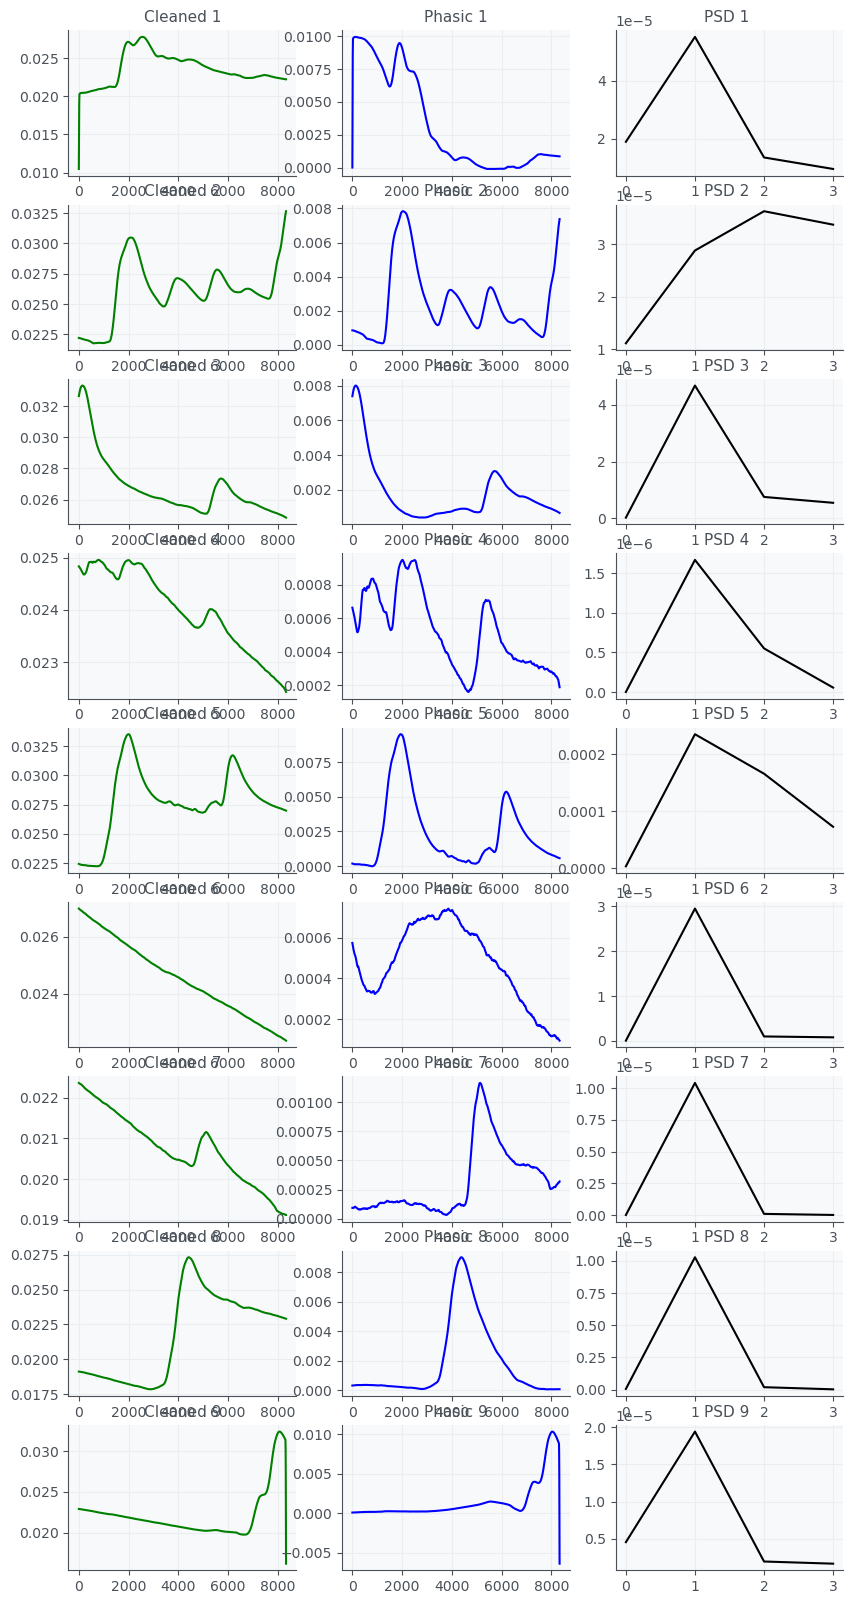

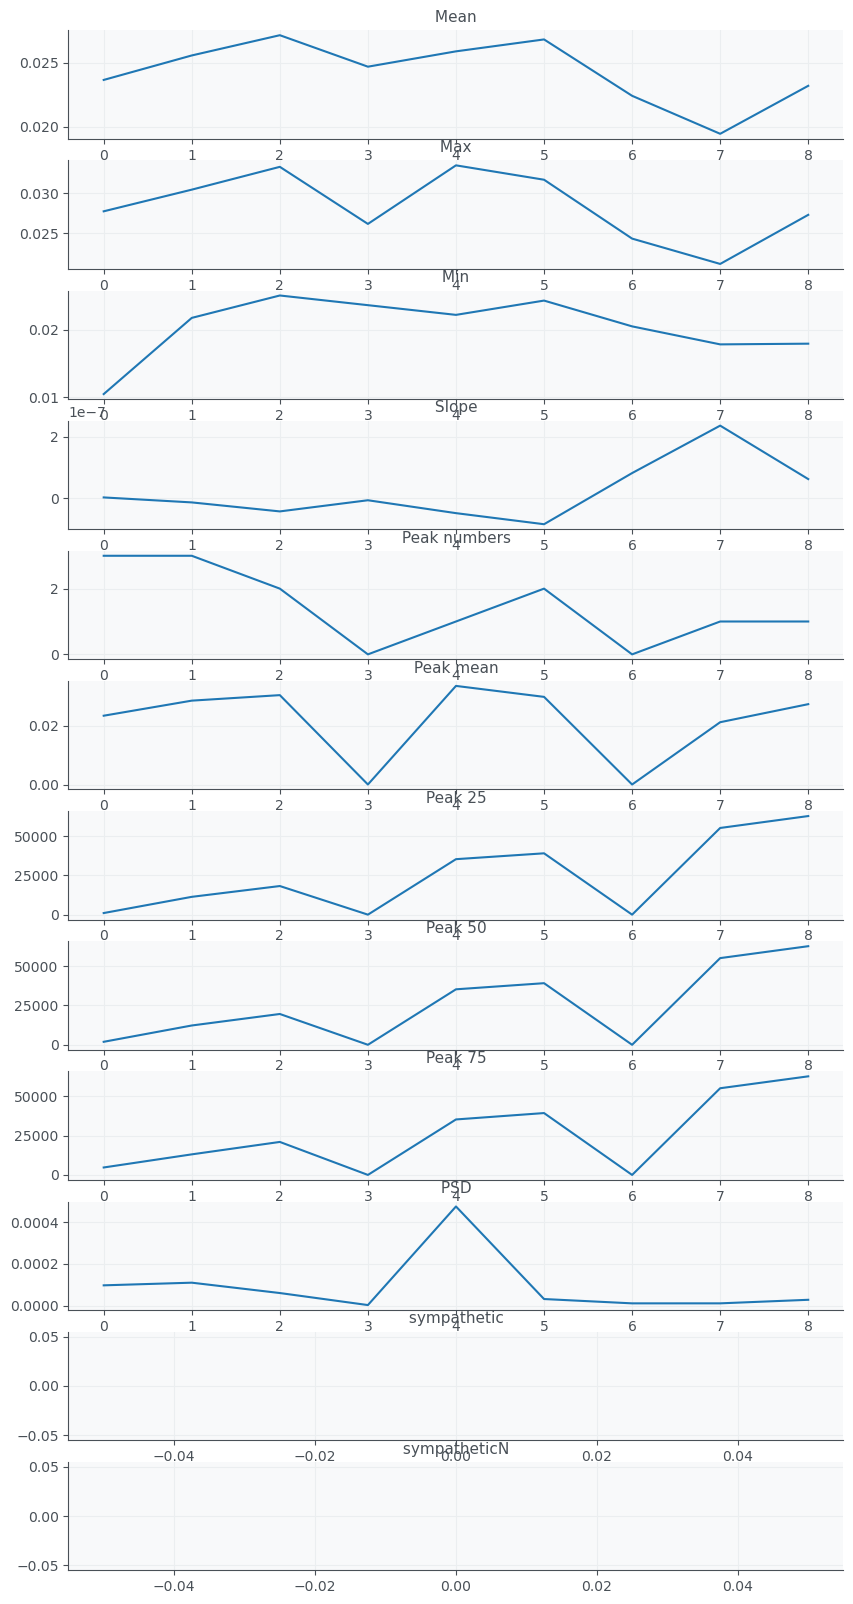

In [45]:
Fs = 256
x  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_resting.csv','Resting_GSR')

mean , maxx , minn , slope , peaks_numb , peaks_mean , peaks_25 , peaks_50 , peaks_75 ,_,_,_,_,_ = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*30 , 0 , True , True  )


PSD of window 1 = 0.009246496126059617 
sympathetic = nan
sympatheticN = nan 



C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\neurokit2\eda\eda_sympathetic.py:108: NeuroKitWarning: The 'posada2016' method requires a signal of length > 60 s. Try with `method='ghiasi2018'`. Returning NaN values for now.
  warn(


PSD of window 2 = 0.000414379736816874 
sympathetic = nan
sympatheticN = nan 

PSD of window 3 = 0.0007163444424695964 
sympathetic = nan
sympatheticN = nan 

PSD of window 4 = 0.00021475168859322024 
sympathetic = nan
sympatheticN = nan 

PSD of window 5 = 0.0002039501650610859 
sympathetic = nan
sympatheticN = nan 

PSD of window 6 = 0.0003749363557727626 
sympathetic = nan
sympatheticN = nan 

PSD of window 7 = 3.661650731534818e-05 
sympathetic = nan
sympatheticN = nan 

PSD of window 8 = 9.307558051370563e-05 
sympathetic = nan
sympatheticN = nan 

PSD of window 9 = 0.00045022359950905094 
sympathetic = nan
sympatheticN = nan 

PSD of window 10 = 8.297953490103635e-05 
sympathetic = nan
sympatheticN = nan 



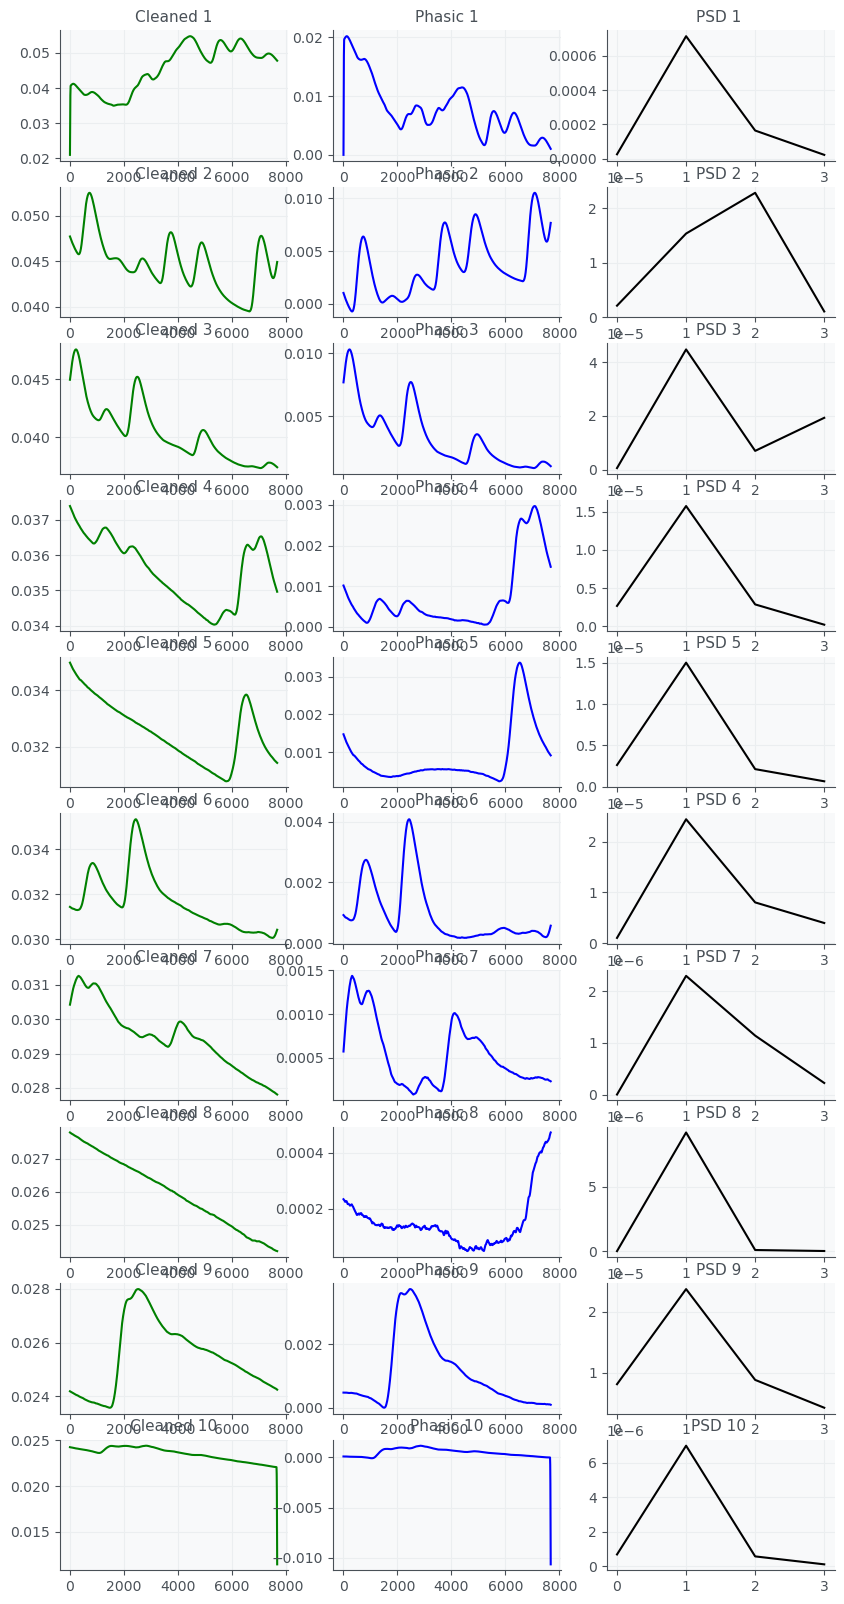

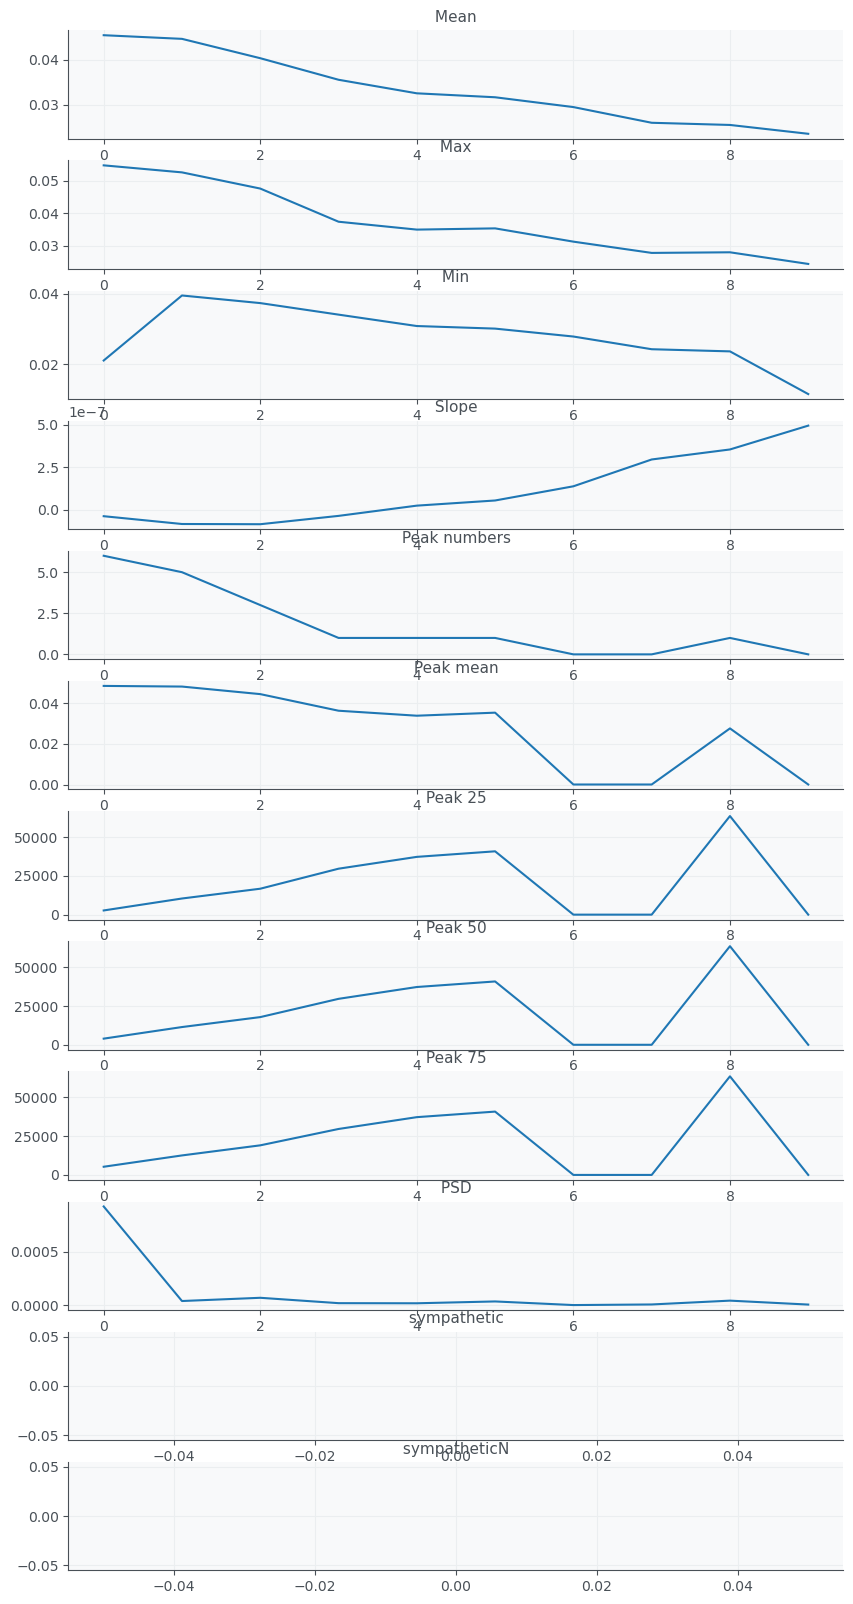

In [46]:
Fs = 256
x  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv','Trial 1:0back')

mean , maxx , minn , slope , peaks_numb , peaks_mean , peaks_25 , peaks_50 , peaks_75 ,_,_,_,_,_ = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*30 , 0 , True , True  )


PSD of window 1 = 0.00843684489817189 
sympathetic = nan
sympatheticN = nan 

PSD of window 2 = 0.0012302466436108508 
sympathetic = nan
sympatheticN = nan 

PSD of window 3 = 0.0011552037733952808 
sympathetic = nan
sympatheticN = nan 

PSD of window 4 = 0.0007952020297773319 
sympathetic = nan
sympatheticN = nan 

PSD of window 5 = 0.0009549557735662207 
sympathetic = nan
sympatheticN = nan 

PSD of window 6 = 0.0006889124057929867 
sympathetic = nan
sympatheticN = nan 



C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\neurokit2\eda\eda_sympathetic.py:108: NeuroKitWarning: The 'posada2016' method requires a signal of length > 60 s. Try with `method='ghiasi2018'`. Returning NaN values for now.
  warn(


PSD of window 7 = 0.00021214099915109423 
sympathetic = nan
sympatheticN = nan 

PSD of window 8 = 0.002381303472238327 
sympathetic = nan
sympatheticN = nan 

PSD of window 9 = 0.0012378126522632608 
sympathetic = nan
sympatheticN = nan 

PSD of window 10 = 5.684490121030976e-05 
sympathetic = nan
sympatheticN = nan 



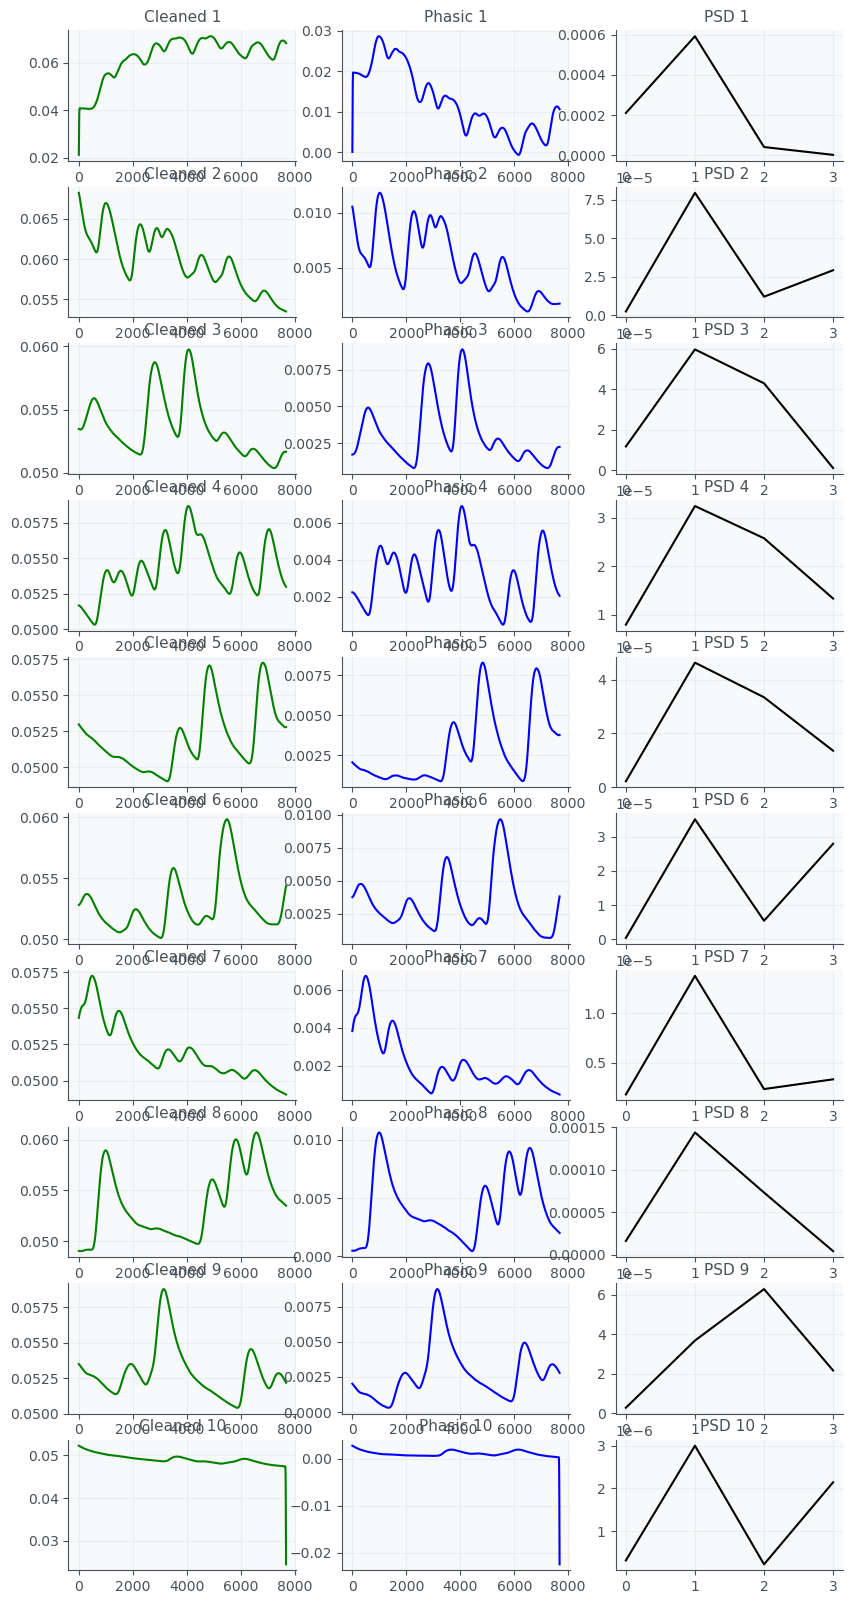

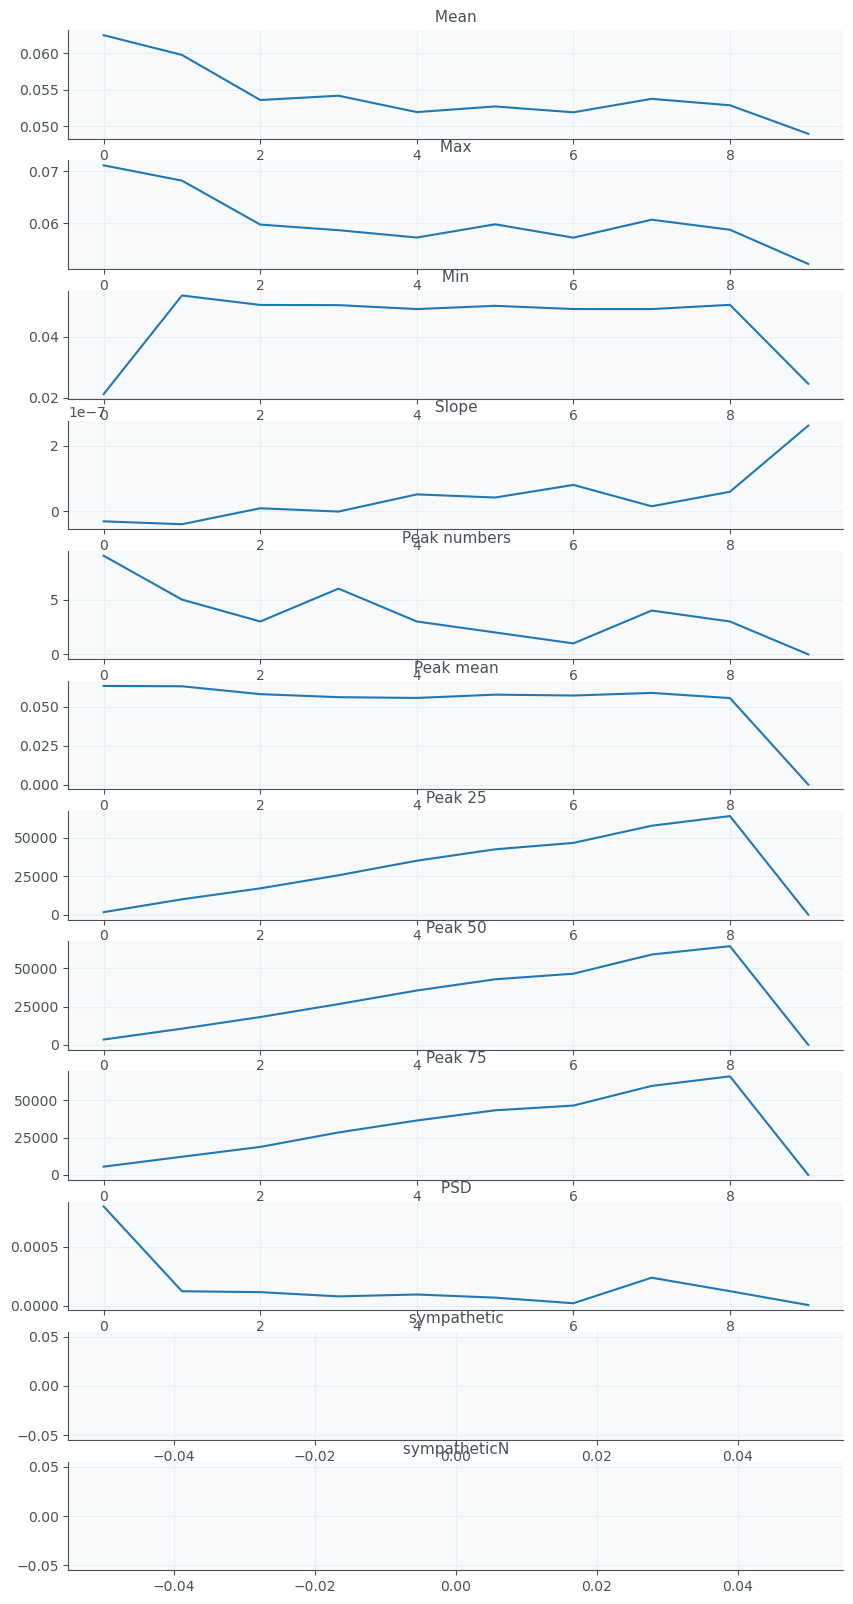

In [47]:
Fs = 256
x  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv','Trial 2:2back')

mean , maxx , minn , slope , peaks_numb , peaks_mean , peaks_25 , peaks_50 , peaks_75 ,_,_,_,_,_ = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*30 , 0 , True , True  )


# Traing SVM model

In [21]:
"""
  Resting : 2
"""
Fs = 256
x  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_resting.csv','Resting_GSR')
r_mean_2 , r_maxx_2 , r_minn_2 , r_slope_2 , r_peaks_numb_2 , r_peaks_mean_2 , r_peaks_25_2 , r_peaks_50_2 , r_peaks_75_2 ,_,_, r_sum_peaks_duration_2 , r_sum_of_peaks_magnitude_2 , r_sum_of_peaks_area_2 , r_psd_2 = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*20 , Fs*10 , False , False  )

C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [22]:
"""
  trial 2:2 --> 2
"""
x  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv','Trial 2:2back')
mean_2_2 , maxx_2_2 , minn_2_2 , slope_2_2 , peaks_numb_2_2 , peaks_mean_2_2 , peaks_25_2_2 , peaks_50_2_2 , peaks_75_2_2 ,_,_, sum_peaks_duration_2_2 , sum_of_peaks_magnitude_2_2 , sum_of_peaks_area_2_2 , psd_2_2 = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*20 , Fs*10 , False , False  )


C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [23]:
"""
  trial 3:3 --> 2
"""
x  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv','Trial 3:3back')
mean_2_3 , maxx_2_3 , minn_2_3 , slope_2_3 , peaks_numb_2_3 , peaks_mean_2_3 , peaks_25_2_3 , peaks_50_2_3 , peaks_75_2_3 ,_,_, sum_peaks_duration_2_3 , sum_of_peaks_magnitude_2_3 , sum_of_peaks_area_2_3 , psd_2_3 = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*20 , Fs*10 , False , False  )


C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [34]:
"""
  trial 4:2--> 2
"""
x  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv','Trial 4:2back')
mean_2_4 , maxx_2_4 , minn_2_4 , slope_2_4 , peaks_numb_2_4 , peaks_mean_2_4 , peaks_25_2_4 , peaks_50_2_4 , peaks_75_2_4 ,_,_, sum_peaks_duration_2_4 , sum_of_peaks_magnitude_2_4 , sum_of_peaks_area_2_4 , psd_2_4= WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*20 , Fs*10 , False , False  )


C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [35]:
"""
  trial 5:3--> 2
"""
x  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/002/inf_gsr.csv','Trial 5:3back')
mean_2_5 , maxx_2_5 , minn_2_5 , slope_2_5 , peaks_numb_2_5 , peaks_mean_2_5 , peaks_25_2_5 , peaks_50_2_5 , peaks_75_2_5 ,_,_, sum_peaks_duration_2_5 , sum_of_peaks_magnitude_2_5 , sum_of_peaks_area_2_5 , psd_2_5 = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*20 , Fs*10 , False , False  )


C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [36]:
"""
  Resting : 5
"""
Fs = 256
x  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/005/inf_resting.csv','Resting_GSR')
r_mean_5 , r_maxx_5 , r_minn_5 , r_slope_5 , r_peaks_numb_5 , r_peaks_mean_5 , r_peaks_25_5 , r_peaks_50_5 , r_peaks_75_5 ,_,_, r_sum_peaks_duration_5 , r_sum_of_peaks_magnitude_5 , r_sum_of_peaks_area_5 , r_psd_5 = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*20 , Fs*10 , False , False  )

C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [37]:
"""
  trial 2:2 --> 5
"""
x  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/005/inf_gsr.csv','Trial 2:2back')
mean_5_2 , maxx_5_2 , minn_5_2 , slope_5_2 , peaks_numb_5_2 , peaks_mean_5_2 , peaks_25_5_2 , peaks_50_5_2 , peaks_75_5_2 ,_,_, sum_peaks_duration_5_2 , sum_of_peaks_magnitude_5_2 , sum_of_peaks_area_5_2 , psd_5_2 = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*20 , Fs*10 , False , False  )


In [38]:
"""
  trial 3:3 --> 5
"""
x  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/005/inf_gsr.csv','Trial 3:3back')
mean_5_3 , maxx_5_3 , minn_5_3 , slope_5_3 , peaks_numb_5_3 , peaks_mean_5_3 , peaks_25_5_3 , peaks_50_5_3 , peaks_75_5_3 ,_,_, sum_peaks_duration_5_3 , sum_of_peaks_magnitude_5_3 , sum_of_peaks_area_5_3 , psd_5_3 = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*20 , Fs*10 , False , False  )


C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [39]:
"""
  trial 4:2--> 5
"""
x  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/005/inf_gsr.csv','Trial 4:2back')
mean_5_4 , maxx_5_4 , minn_5_4 , slope_5_4 , peaks_numb_5_4 , peaks_mean_5_4 , peaks_25_5_4 , peaks_50_5_4 , peaks_75_5_4 ,_,_, sum_peaks_duration_5_4 , sum_of_peaks_magnitude_5_4 , sum_of_peaks_area_5_4 , psd_5_4= WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*20 , Fs*10 , False , False  )


C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [40]:
"""
  trial 5:3--> 5
"""
x  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/005/inf_gsr.csv','Trial 5:3back')
mean_5_5 , maxx_5_5 , minn_5_5 , slope_5_5 , peaks_numb_5_5 , peaks_mean_5_5 , peaks_25_5_5 , peaks_50_5_5 , peaks_75_5_5 ,_,_, sum_peaks_duration_5_5 , sum_of_peaks_magnitude_5_5 , sum_of_peaks_area_5_5 , psd_5_5 = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*20 , Fs*10 , False , False  )


C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [26]:
"""
   2 --> resting halve
"""
# Get the relative mean to use it in the model
average_r_mean = np.mean(r_mean_2)
relative_mean_2 = [ (x-average_r_mean)/average_r_mean  for x in r_mean_2[ : int(len(r_mean_2)/2) ] ]
relative_mean_2

# Get the relative max to use it in the model
average_r_max = np.mean(r_maxx_2)
relative_max_2 = [ (x-average_r_max)/average_r_max  for x in r_maxx_2[ : int(len(r_mean_2)/2) ] ]
relative_max_2

# Get the relative min to use it in the model
average_r_min = np.mean(r_minn_2)
relative_min_2 = [ (x-average_r_min)/average_r_min  for x in r_minn_2[ : int(len(r_mean_2)/2) ] ]
relative_min_2

# Get the relative slope to use it in the model (Not good)
average_r_slope = np.mean(r_slope_2)
relative_slope_2  = [ (x-average_r_slope)/average_r_slope  for x in r_slope_2[ : int(len(r_mean_2)/2) ] ]
relative_slope_2 

# Get the peak num difference to use it in the model
average_r_peaks_numb = np.mean(r_peaks_numb_2)
relative_peaks_numb_2  = [ (x-average_r_peaks_numb)  for x in r_peaks_numb_2[ : int(len(r_mean_2)/2) ] ]
relative_peaks_numb_2 

# Get the relative peak mean to use it in the model
average_r_peaks_mean = np.mean(r_peaks_mean_2)
relative_peaks_mean_2  = [ (x-average_r_peaks_mean)/average_r_peaks_mean  for x in r_peaks_mean_2[ : int(len(r_mean_2)/2) ] ]
relative_peaks_mean_2 

"""
  Peaks 25,50 and 75 not good
"""
# Get the relative peak 25 to use it in the model
average_r_peaks_25 = np.mean(r_peaks_25_2)
relative_peaks_25_2  = [ (x-average_r_peaks_25)/average_r_peaks_25 for x in r_peaks_25_2[ : int(len(r_mean_2)/2) ] ]
relative_peaks_25_2 

# Get the relative peak 50 to use it in the model
average_r_peaks_50 = np.mean(r_peaks_50_2)
relative_peaks_50_2  = [ (x-average_r_peaks_50)/average_r_peaks_50 for x in r_peaks_50_2[ : int(len(r_mean_2)/2) ] ]
relative_peaks_50_2 

# Get the relative peak 75 to use it in the model
average_r_peaks_75 = np.mean(r_peaks_75_2)
relative_peaks_75_2  = [ (x-average_r_peaks_75)/average_r_peaks_75 for x in r_peaks_75_2[ : int(len(r_mean_2)/2) ] ]
relative_peaks_75_2 


# Get the relative peak duration to use it in the model
# First remove any nan values
r_sum_peaks_duration_2 = [x if not np.isnan(x) else 0 for x in r_sum_peaks_duration_2]
sum_peaks_duration_2 = [x if not np.isnan(x) else 0 for x in r_sum_peaks_duration_2[ : int(len(r_mean_2)/2) ] ]
average_r_peaks_duration_2  = np.mean(r_sum_peaks_duration_2)
relative_peaks_duration_2  = [ (x-average_r_peaks_duration_2 )/average_r_peaks_duration_2  for x in r_sum_peaks_duration_2[ : int(len(r_mean_2)/2) ]  ]
relative_peaks_duration_2 

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_magnitude_2 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_magnitude_2[ : int(len(r_mean_2)/2) ] ]
sum_peaks_magnitude_2  = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_magnitude_2[ : int(len(r_mean_2)/2) ] ]
average_r_peaks_magnitude_2  = np.mean(r_sum_of_peaks_magnitude_2)
relative_peaks_magnitude_2  = [ (x-average_r_peaks_magnitude_2 )/average_r_peaks_duration_2  for x in r_sum_of_peaks_magnitude_2[ : int(len(r_mean_2)/2) ]  ]
relative_peaks_magnitude_2 

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_area_2 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_area_2]
sum_of_peaks_area_2  = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_area_2[ : int(len(r_mean_2)/2) ] ]
average_r_peaks_area_2  = np.mean(r_sum_of_peaks_area_2)
relative_peaks_area_2  = [ (x-average_r_peaks_area_2 )/average_r_peaks_area_2  for x in r_sum_of_peaks_area_2[ : int(len(r_mean_2)/2) ]  ]
relative_peaks_area_2 

# Get the relative psd to use it in the model (not good)
average_r_psd_mean = np.mean(r_psd_2)
relative_psd_2  = [ (x-average_r_psd_mean)/average_r_psd_mean  for x in r_psd_2[ : int(len(r_mean_2)/2) ]  ]
relative_psd_2 

1

1

In [27]:
"""
   2 --> trial2:2
"""
# Get the relative mean to use it in the model
average_r_mean = np.mean(r_mean_2)
relative_mean_2_2 = [ (x-average_r_mean)/average_r_mean  for x in mean_2_2 ]
relative_mean_2_2

# Get the relative max to use it in the model
average_r_max = np.mean(r_maxx_2)
relative_max_2_2 = [ (x-average_r_max)/average_r_max  for x in maxx_2_2 ]
relative_max_2_2

# Get the relative min to use it in the model
average_r_min = np.mean(r_minn_2)
relative_min_2_2 = [ (x-average_r_min)/average_r_min  for x in minn_2_2 ]
relative_min_2_2

# Get the relative slope to use it in the model (Not good)
average_r_slope = np.mean(r_slope_2)
relative_slope_2_2 = [ (x-average_r_slope)/average_r_slope  for x in slope_2_2 ]
relative_slope_2_2

# Get the peak num difference to use it in the model
average_r_peaks_numb = np.mean(r_peaks_numb_2)
relative_peaks_numb_2_2 = [ (x-average_r_peaks_numb)  for x in peaks_numb_2_2 ]
relative_peaks_numb_2_2

# Get the relative peak mean to use it in the model
average_r_peaks_mean = np.mean(r_peaks_mean_2)
relative_peaks_mean_2_2 = [ (x-average_r_peaks_mean)/average_r_peaks_mean  for x in peaks_mean_2_2 ]
relative_peaks_mean_2_2

"""
  Peaks 25,50 and 75 not good
"""
# Get the relative peak 25 to use it in the model
average_r_peaks_25 = np.mean(r_peaks_25_2)
relative_peaks_25_2_2 = [ (x-average_r_peaks_25)/average_r_peaks_25 for x in peaks_25_2_2 ]
relative_peaks_25_2_2

# Get the relative peak 50 to use it in the model
average_r_peaks_50 = np.mean(r_peaks_50_2)
relative_peaks_50_2_2 = [ (x-average_r_peaks_50)/average_r_peaks_50 for x in peaks_50_2_2 ]
relative_peaks_50_2_2

# Get the relative peak 75 to use it in the model
average_r_peaks_75 = np.mean(r_peaks_75_2)
relative_peaks_75_2_2 = [ (x-average_r_peaks_75)/average_r_peaks_75 for x in peaks_75_2_2 ]
relative_peaks_75_2_2


# Get the relative peak duration to use it in the model
# First remove any nan values
r_sum_peaks_duration_2 = [x if not np.isnan(x) else 0 for x in r_sum_peaks_duration_2]
sum_peaks_duration_2_2 = [x if not np.isnan(x) else 0 for x in sum_peaks_duration_2_2]
average_r_peaks_duration_2_2 = np.mean(r_sum_peaks_duration_2)
relative_peaks_duration_2_2 = [ (x-average_r_peaks_duration_2_2)/average_r_peaks_duration_2_2 for x in sum_peaks_duration_2_2 ]
relative_peaks_duration_2_2

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_magnitude_2 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_magnitude_2]
sum_peaks_magnitude_2_2 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_magnitude_2_2]
average_r_peaks_magnitude_2_2 = np.mean(r_sum_of_peaks_magnitude_2)
relative_peaks_magnitude_2_2 = [ (x-average_r_peaks_magnitude_2_2)/average_r_peaks_duration_2_2 for x in sum_peaks_magnitude_2_2 ]
relative_peaks_magnitude_2_2

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_area_2 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_area_2]
sum_of_peaks_area_2_2 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_area_2_2]
average_r_peaks_area_2_2 = np.mean(r_sum_of_peaks_area_2)
relative_peaks_area_2_2 = [ (x-average_r_peaks_area_2_2)/average_r_peaks_area_2_2 for x in sum_of_peaks_area_2_2 ]
relative_peaks_area_2_2

# Get the relative psd to use it in the model (not good)
average_r_psd_mean = np.mean(r_psd_2)
relative_psd_2_2 = [ (x-average_r_psd_mean)/average_r_psd_mean  for x in psd_2_2 ]
relative_psd_2_2

1

1

In [28]:
"""
   2 --> trial3:3
"""
# Get the relative mean to use it in the model
average_r_mean = np.mean(r_mean_2)
relative_mean_2_3 = [ (x-average_r_mean)/average_r_mean  for x in mean_2_3 ]
len(relative_mean_2_3)

# Get the relative max to use it in the model
average_r_max = np.mean(r_maxx_2)
relative_max_2_3 = [ (x-average_r_max)/average_r_max  for x in maxx_2_3 ]
relative_max_2_3

# Get the relative min to use it in the model
average_r_min = np.mean(r_minn_2)
relative_min_2_3 = [ (x-average_r_min)/average_r_min  for x in minn_2_3 ]
relative_min_2_3

# Get the relative slope to use it in the model (Not good)
average_r_slope = np.mean(r_slope_2)
relative_slope_2_3 = [ (x-average_r_slope)/average_r_slope  for x in slope_2_3 ]
relative_slope_2_3

# Get the peak num difference to use it in the model
average_r_peaks_numb = np.mean(r_peaks_numb_2)
relative_peaks_numb_2_3 = [ (x-average_r_peaks_numb)  for x in peaks_numb_2_3 ]
relative_peaks_numb_2_3

# Get the relative peak mean to use it in the model
average_r_peaks_mean = np.mean(r_peaks_mean_2)
relative_peaks_mean_2_3 = [ (x-average_r_peaks_mean)/average_r_peaks_mean  for x in peaks_mean_2_3 ]
relative_peaks_mean_2_3

"""
  Peaks 25,50 and 75 not good
"""
# Get the relative peak 25 to use it in the model
average_r_peaks_25 = np.mean(r_peaks_25_2)
relative_peaks_25_2_3 = [ (x-average_r_peaks_25)/average_r_peaks_25 for x in peaks_25_2_3 ]
relative_peaks_25_2_3

# Get the relative peak 50 to use it in the model
average_r_peaks_50 = np.mean(r_peaks_50_2)
relative_peaks_50_2_3 = [ (x-average_r_peaks_50)/average_r_peaks_50 for x in peaks_50_2_3 ]
relative_peaks_50_2_3

# Get the relative peak 75 to use it in the model
average_r_peaks_75 = np.mean(r_peaks_75_2)
relative_peaks_75_2_3 = [ (x-average_r_peaks_75)/average_r_peaks_75 for x in peaks_75_2_3 ]
relative_peaks_75_2_3


# Get the relative peak duration to use it in the model
# First remove any nan values
r_sum_peaks_duration_2 = [x if not np.isnan(x) else 0 for x in r_sum_peaks_duration_2]
sum_peaks_duration_2_3 = [x if not np.isnan(x) else 0 for x in sum_peaks_duration_2_3]
average_r_peaks_duration_2_3 = np.mean(r_sum_peaks_duration_2)
relative_peaks_duration_2_3 = [ (x-average_r_peaks_duration_2_3)/average_r_peaks_duration_2_3 for x in sum_peaks_duration_2_3 ]
relative_peaks_duration_2_3

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_magnitude_2 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_magnitude_2]
sum_peaks_magnitude_2_3 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_magnitude_2_3]
average_r_peaks_magnitude_2_3 = np.mean(r_sum_of_peaks_magnitude_2)
relative_peaks_magnitude_2_3 = [ (x-average_r_peaks_magnitude_2_3)/average_r_peaks_duration_2_3 for x in sum_peaks_magnitude_2_3 ]
relative_peaks_magnitude_2_3

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_area_2 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_area_2]
sum_of_peaks_area_2_3 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_area_2_3]
average_r_peaks_area_2_3 = np.mean(r_sum_of_peaks_area_2)
relative_peaks_area_2_3 = [ (x-average_r_peaks_area_2_3)/average_r_peaks_area_2_3 for x in sum_of_peaks_area_2_3 ]
relative_peaks_area_2_3

# Get the relative psd to use it in the model (not good)
average_r_psd_mean = np.mean(r_psd_2)
relative_psd_2_3 = [ (x-average_r_psd_mean)/average_r_psd_mean  for x in psd_2_3 ]
relative_psd_2_3

1

1

In [29]:
"""
   2 --> trial4:2
"""
# Get the relative mean to use it in the model
average_r_mean = np.mean(r_mean_2)
relative_mean_2_4 = [ (x-average_r_mean)/average_r_mean  for x in mean_2_4 ]
relative_mean_2_4

# Get the relative max to use it in the model
average_r_max = np.mean(r_maxx_2)
relative_max_2_4 = [ (x-average_r_max)/average_r_max  for x in maxx_2_4 ]
relative_max_2_4

# Get the relative min to use it in the model
average_r_min = np.mean(r_minn_2)
relative_min_2_4 = [ (x-average_r_min)/average_r_min  for x in minn_2_4 ]
relative_min_2_4

# Get the relative slope to use it in the model (Not good)
average_r_slope = np.mean(r_slope_2)
relative_slope_2_4 = [ (x-average_r_slope)/average_r_slope  for x in slope_2_4 ]
relative_slope_2_4

# Get the peak num difference to use it in the model
average_r_peaks_numb = np.mean(r_peaks_numb_2)
relative_peaks_numb_2_4 = [ (x-average_r_peaks_numb)  for x in peaks_numb_2_4 ]
relative_peaks_numb_2_4

# Get the relative peak mean to use it in the model
average_r_peaks_mean = np.mean(r_peaks_mean_2)
relative_peaks_mean_2_4 = [ (x-average_r_peaks_mean)/average_r_peaks_mean  for x in peaks_mean_2_4 ]
relative_peaks_mean_2_4

"""
  Peaks 25,50 and 75 not good
"""
# Get the relative peak 25 to use it in the model
average_r_peaks_25 = np.mean(r_peaks_25_2)
relative_peaks_25_2_4 = [ (x-average_r_peaks_25)/average_r_peaks_25 for x in peaks_25_2_4 ]
relative_peaks_25_2_4

# Get the relative peak 50 to use it in the model
average_r_peaks_50 = np.mean(r_peaks_50_2)
relative_peaks_50_2_4 = [ (x-average_r_peaks_50)/average_r_peaks_50 for x in peaks_50_2_4 ]
relative_peaks_50_2_4

# Get the relative peak 75 to use it in the model
average_r_peaks_75 = np.mean(r_peaks_75_2)
relative_peaks_75_2_4 = [ (x-average_r_peaks_75)/average_r_peaks_75 for x in peaks_75_2_4 ]
relative_peaks_75_2_4


# Get the relative peak duration to use it in the model
# First remove any nan values
r_sum_peaks_duration_2 = [x if not np.isnan(x) else 0 for x in r_sum_peaks_duration_2]
sum_peaks_duration_2_4 = [x if not np.isnan(x) else 0 for x in sum_peaks_duration_2_4]
average_r_peaks_duration_2_4 = np.mean(r_sum_peaks_duration_2)
relative_peaks_duration_2_4 = [ (x-average_r_peaks_duration_2_4)/average_r_peaks_duration_2_4 for x in sum_peaks_duration_2_4 ]
relative_peaks_duration_2_4

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_magnitude_2 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_magnitude_2]
sum_peaks_magnitude_2_4 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_magnitude_2_4]
average_r_peaks_magnitude_2_4 = np.mean(r_sum_of_peaks_magnitude_2)
relative_peaks_magnitude_2_4 = [ (x-average_r_peaks_magnitude_2_4)/average_r_peaks_duration_2_4 for x in sum_peaks_magnitude_2_4 ]
relative_peaks_magnitude_2_4

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_area_2 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_area_2]
sum_of_peaks_area_2_4 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_area_2_4]
average_r_peaks_area_2_4 = np.mean(r_sum_of_peaks_area_2)
relative_peaks_area_2_4 = [ (x-average_r_peaks_area_2_4)/average_r_peaks_area_2_4 for x in sum_of_peaks_area_2_4 ]
relative_peaks_area_2_4

# Get the relative psd to use it in the model (not good)
average_r_psd_mean = np.mean(r_psd_2)
relative_psd_2_4 = [ (x-average_r_psd_mean)/average_r_psd_mean  for x in psd_2_4 ]
relative_psd_2_4

1

1

In [30]:
"""
   2 --> trial5:3
"""
# Get the relative mean to use it in the model
average_r_mean = np.mean(r_mean_2)
relative_mean_2_5 = [ (x-average_r_mean)/average_r_mean  for x in mean_2_5 ]
relative_mean_2_5

# Get the relative max to use it in the model
average_r_max = np.mean(r_maxx_2)
relative_max_2_5 = [ (x-average_r_max)/average_r_max  for x in maxx_2_5 ]
relative_max_2_5

# Get the relative min to use it in the model
average_r_min = np.mean(r_minn_2)
relative_min_2_5 = [ (x-average_r_min)/average_r_min  for x in minn_2_5 ]
relative_min_2_5

# Get the relative slope to use it in the model (Not good)
average_r_slope = np.mean(r_slope_2)
relative_slope_2_5 = [ (x-average_r_slope)/average_r_slope  for x in slope_2_5 ]
relative_slope_2_5

# Get the peak num difference to use it in the model
average_r_peaks_numb = np.mean(r_peaks_numb_2)
relative_peaks_numb_2_5 = [ (x-average_r_peaks_numb)  for x in peaks_numb_2_5 ]
relative_peaks_numb_2_5

# Get the relative peak mean to use it in the model
average_r_peaks_mean = np.mean(r_peaks_mean_2)
relative_peaks_mean_2_5 = [ (x-average_r_peaks_mean)/average_r_peaks_mean  for x in peaks_mean_2_5 ]
relative_peaks_mean_2_5

"""
  Peaks 25,50 and 75 not good
"""
# Get the relative peak 25 to use it in the model
average_r_peaks_25 = np.mean(r_peaks_25_2)
relative_peaks_25_2_5 = [ (x-average_r_peaks_25)/average_r_peaks_25 for x in peaks_25_2_5 ]
relative_peaks_25_2_5

# Get the relative peak 50 to use it in the model
average_r_peaks_50 = np.mean(r_peaks_50_2)
relative_peaks_50_2_5 = [ (x-average_r_peaks_50)/average_r_peaks_50 for x in peaks_50_2_5 ]
relative_peaks_50_2_5

# Get the relative peak 75 to use it in the model
average_r_peaks_75 = np.mean(r_peaks_75_2)
relative_peaks_75_2_5 = [ (x-average_r_peaks_75)/average_r_peaks_75 for x in peaks_75_2_5 ]
relative_peaks_75_2_5


# Get the relative peak duration to use it in the model
# First remove any nan values
r_sum_peaks_duration_2 = [x if not np.isnan(x) else 0 for x in r_sum_peaks_duration_2]
sum_peaks_duration_2_5 = [x if not np.isnan(x) else 0 for x in sum_peaks_duration_2_5]
average_r_peaks_duration_2_5 = np.mean(r_sum_peaks_duration_2)
relative_peaks_duration_2_5 = [ (x-average_r_peaks_duration_2_5)/average_r_peaks_duration_2_5 for x in sum_peaks_duration_2_5 ]
relative_peaks_duration_2_5

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_magnitude_2 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_magnitude_2]
sum_peaks_magnitude_2_5 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_magnitude_2_5]
average_r_peaks_magnitude_2_5 = np.mean(r_sum_of_peaks_magnitude_2)
relative_peaks_magnitude_2_5 = [ (x-average_r_peaks_magnitude_2_5)/average_r_peaks_duration_2_5 for x in sum_peaks_magnitude_2_5 ]
relative_peaks_magnitude_2_5

# Get the relative peak area to use it in the model
# First remove any nan values
r_sum_of_peaks_area_2 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_area_2]
sum_of_peaks_area_2_5 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_area_2_5]
average_r_peaks_area_2_5 = np.mean(r_sum_of_peaks_area_2)
relative_peaks_area_2_5 = [ (x-average_r_peaks_area_2_5)/average_r_peaks_area_2_5 for x in sum_of_peaks_area_2_5 ]
relative_peaks_area_2_5

# Get the relative psd to use it in the model (not good)
average_r_psd_mean = np.mean(r_psd_2)
relative_psd_2_5 = [ (x-average_r_psd_mean)/average_r_psd_mean  for x in psd_2_5 ]
relative_psd_2_5

1

1

In [45]:
"""
   5 --> resting halve
"""
# Get the relative mean to use it in the model
average_r_mean = np.mean(r_mean_5)
relative_mean_5 = [ (x-average_r_mean)/average_r_mean  for x in r_mean_5[ : int(len(r_mean_5)/5) ] ]
relative_mean_5

# Get the relative max to use it in the model
average_r_max = np.mean(r_maxx_5)
relative_max_5 = [ (x-average_r_max)/average_r_max  for x in r_maxx_5[ : int(len(r_mean_5)/5) ] ]
relative_max_5

# Get the relative min to use it in the model
average_r_min = np.mean(r_minn_5)
relative_min_5 = [ (x-average_r_min)/average_r_min  for x in r_minn_5[ : int(len(r_mean_5)/5) ] ]
relative_min_5

# Get the relative slope to use it in the model (Not good)
average_r_slope = np.mean(r_slope_5)
relative_slope_5  = [ (x-average_r_slope)/average_r_slope  for x in r_slope_5[ : int(len(r_mean_5)/5) ] ]
relative_slope_5 

# Get the peak num difference to use it in the model
average_r_peaks_numb = np.mean(r_peaks_numb_5)
relative_peaks_numb_5  = [ (x-average_r_peaks_numb)  for x in r_peaks_numb_5[ : int(len(r_mean_5)/5) ] ]
relative_peaks_numb_5 

# Get the relative peak mean to use it in the model
average_r_peaks_mean = np.mean(r_peaks_mean_5)
relative_peaks_mean_5  = [ (x-average_r_peaks_mean)/average_r_peaks_mean  for x in r_peaks_mean_5[ : int(len(r_mean_5)/5) ] ]
relative_peaks_mean_5 

"""
  Peaks 25,20 and 75 not good
"""
# Get the relative peak 25 to use it in the model
average_r_peaks_25 = np.mean(r_peaks_25_5)
relative_peaks_25_5  = [ (x-average_r_peaks_25)/average_r_peaks_25 for x in r_peaks_25_5[ : int(len(r_mean_5)/5) ] ]
relative_peaks_25_5 

# Get the relative peak 50 to use it in the model
average_r_peaks_50 = np.mean(r_peaks_50_5)
relative_peaks_50_5  = [ (x-average_r_peaks_50)/average_r_peaks_50 for x in r_peaks_50_5[ : int(len(r_mean_5)/5) ] ]
relative_peaks_50_5 

# Get the relative peak 75 to use it in the model
average_r_peaks_75 = np.mean(r_peaks_75_5)
relative_peaks_75_5  = [ (x-average_r_peaks_75)/average_r_peaks_75 for x in r_peaks_75_5[ : int(len(r_mean_5)/5) ] ]
relative_peaks_75_5 


# Get the relative peak duration to use it in the model
# First remove any nan values
r_sum_peaks_duration_5 = [x if not np.isnan(x) else 0 for x in r_sum_peaks_duration_5]
sum_peaks_duration_5 = [x if not np.isnan(x) else 0 for x in r_sum_peaks_duration_5[ : int(len(r_mean_5)/5) ] ]
average_r_peaks_duration_5  = np.mean(r_sum_peaks_duration_5)
relative_peaks_duration_5  = [ (x-average_r_peaks_duration_5 )/average_r_peaks_duration_5  for x in r_sum_peaks_duration_5[ : int(len(r_mean_5)/5) ]  ]
relative_peaks_duration_5 

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_magnitude_5 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_magnitude_5[ : int(len(r_mean_5)/5) ] ]
sum_peaks_magnitude_5  = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_magnitude_5[ : int(len(r_mean_5)/5) ] ]
average_r_peaks_magnitude_5  = np.mean(r_sum_of_peaks_magnitude_5)
relative_peaks_magnitude_5  = [ (x-average_r_peaks_magnitude_5 )/average_r_peaks_duration_5  for x in r_sum_of_peaks_magnitude_5[ : int(len(r_mean_5)/5) ]  ]
relative_peaks_magnitude_5 

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_area_5 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_area_5]
sum_of_peaks_area_5  = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_area_5[ : int(len(r_mean_5)/5) ] ]
average_r_peaks_area_5  = np.mean(r_sum_of_peaks_area_5)
relative_peaks_area_5  = [ (x-average_r_peaks_area_5 )/average_r_peaks_area_5  for x in r_sum_of_peaks_area_5[ : int(len(r_mean_5)/5) ]  ]
relative_peaks_area_5 

# Get the relative psd to use it in the model (not good)
average_r_psd_mean = np.mean(r_psd_5)
relative_psd_5  = [ (x-average_r_psd_mean)/average_r_psd_mean  for x in r_psd_5[ : int(len(r_mean_5)/5) ]  ]
relative_psd_5 

1

1

In [ ]:
"""
   2 --> trial3:3
"""
# Get the relative mean to use it in the model
average_r_mean = np.mean(r_mean_2)
relative_mean_2_3 = [ (x-average_r_mean)/average_r_mean  for x in mean_2_3 ]
len(relative_mean_2_3)

# Get the relative max to use it in the model
average_r_max = np.mean(r_maxx_2)
relative_max_2_3 = [ (x-average_r_max)/average_r_max  for x in maxx_2_3 ]
relative_max_2_3

# Get the relative min to use it in the model
average_r_min = np.mean(r_minn_2)
relative_min_2_3 = [ (x-average_r_min)/average_r_min  for x in minn_2_3 ]
relative_min_2_3

# Get the relative slope to use it in the model (Not good)
average_r_slope = np.mean(r_slope_2)
relative_slope_2_3 = [ (x-average_r_slope)/average_r_slope  for x in slope_2_3 ]
relative_slope_2_3

# Get the peak num difference to use it in the model
average_r_peaks_numb = np.mean(r_peaks_numb_2)
relative_peaks_numb_2_3 = [ (x-average_r_peaks_numb)  for x in peaks_numb_2_3 ]
relative_peaks_numb_2_3

# Get the relative peak mean to use it in the model
average_r_peaks_mean = np.mean(r_peaks_mean_2)
relative_peaks_mean_2_3 = [ (x-average_r_peaks_mean)/average_r_peaks_mean  for x in peaks_mean_2_3 ]
relative_peaks_mean_2_3

"""
  Peaks 25,50 and 75 not good
"""
# Get the relative peak 25 to use it in the model
average_r_peaks_25 = np.mean(r_peaks_25_2)
relative_peaks_25_2_3 = [ (x-average_r_peaks_25)/average_r_peaks_25 for x in peaks_25_2_3 ]
relative_peaks_25_2_3

# Get the relative peak 50 to use it in the model
average_r_peaks_50 = np.mean(r_peaks_50_2)
relative_peaks_50_2_3 = [ (x-average_r_peaks_50)/average_r_peaks_50 for x in peaks_50_2_3 ]
relative_peaks_50_2_3

# Get the relative peak 75 to use it in the model
average_r_peaks_75 = np.mean(r_peaks_75_2)
relative_peaks_75_2_3 = [ (x-average_r_peaks_75)/average_r_peaks_75 for x in peaks_75_2_3 ]
relative_peaks_75_2_3


# Get the relative peak duration to use it in the model
# First remove any nan values
r_sum_peaks_duration_2 = [x if not np.isnan(x) else 0 for x in r_sum_peaks_duration_2]
sum_peaks_duration_2_3 = [x if not np.isnan(x) else 0 for x in sum_peaks_duration_2_3]
average_r_peaks_duration_2_3 = np.mean(r_sum_peaks_duration_2)
relative_peaks_duration_2_3 = [ (x-average_r_peaks_duration_2_3)/average_r_peaks_duration_2_3 for x in sum_peaks_duration_2_3 ]
relative_peaks_duration_2_3

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_magnitude_2 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_magnitude_2]
sum_peaks_magnitude_2_3 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_magnitude_2_3]
average_r_peaks_magnitude_2_3 = np.mean(r_sum_of_peaks_magnitude_2)
relative_peaks_magnitude_2_3 = [ (x-average_r_peaks_magnitude_2_3)/average_r_peaks_duration_2_3 for x in sum_peaks_magnitude_2_3 ]
relative_peaks_magnitude_2_3

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_area_2 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_area_2]
sum_of_peaks_area_2_3 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_area_2_3]
average_r_peaks_area_2_3 = np.mean(r_sum_of_peaks_area_2)
relative_peaks_area_2_3 = [ (x-average_r_peaks_area_2_3)/average_r_peaks_area_2_3 for x in sum_of_peaks_area_2_3 ]
relative_peaks_area_2_3

# Get the relative psd to use it in the model (not good)
average_r_psd_mean = np.mean(r_psd_2)
relative_psd_2_3 = [ (x-average_r_psd_mean)/average_r_psd_mean  for x in psd_2_3 ]
relative_psd_2_3

1

In [51]:
"""
   5 --> trial2:2
"""
# Get the relative mean to use it in the model
average_r_mean = np.mean(r_mean_5)
relative_mean_5_2 = [ (x-average_r_mean)/average_r_mean  for x in mean_5_2 ]
(relative_mean_5_2)

# Get the relative max to use it in the model
average_r_max = np.mean(r_maxx_5)
relative_max_5_2 = [ (x-average_r_max)/average_r_max  for x in maxx_5_2 ]
relative_max_5_2

# Get the relative min to use it in the model
average_r_min = np.mean(r_minn_5)
relative_min_5_2 = [ (x-average_r_min)/average_r_min  for x in minn_5_2 ]
relative_min_5_2

# Get the relative slope to use it in the model (Not good)
average_r_slope = np.mean(r_slope_5)
relative_slope_5_2 = [ (x-average_r_slope)/average_r_slope  for x in slope_5_2 ]
relative_slope_5_2

# Get the peak num difference to use it in the model
average_r_peaks_numb = np.mean(r_peaks_numb_5)
relative_peaks_numb_5_2 = [ (x-average_r_peaks_numb)  for x in peaks_numb_5_2 ]
relative_peaks_numb_5_2

# Get the relative peak mean to use it in the model
average_r_peaks_mean = np.mean(r_peaks_mean_5)
relative_peaks_mean_5_2 = [ (x-average_r_peaks_mean)/average_r_peaks_mean  for x in peaks_mean_5_2 ]
relative_peaks_mean_5_2

"""
  Peaks 25,50 and 75 not good
"""
# Get the relative peak 25 to use it in the model
average_r_peaks_25 = np.mean(r_peaks_25_5)
relative_peaks_25_5_2 = [ (x-average_r_peaks_25)/average_r_peaks_25 for x in peaks_25_5_2 ]
relative_peaks_25_5_2

# Get the relative peak 50 to use it in the model
average_r_peaks_50 = np.mean(r_peaks_50_5)
relative_peaks_50_5_2 = [ (x-average_r_peaks_50)/average_r_peaks_50 for x in peaks_50_5_2 ]
relative_peaks_50_5_2

# Get the relative peak 75 to use it in the model
average_r_peaks_75 = np.mean(r_peaks_75_5)
relative_peaks_75_5_2 = [ (x-average_r_peaks_75)/average_r_peaks_75 for x in peaks_75_5_2 ]
relative_peaks_75_5_2


# Get the relative peak duration to use it in the model
# First remove any nan values
r_sum_peaks_duration_5 = [x if not np.isnan(x) else 0 for x in r_sum_peaks_duration_5]
sum_peaks_duration_5_2 = [x if not np.isnan(x) else 0 for x in sum_peaks_duration_5_2]
average_r_peaks_duration_5_2 = np.mean(r_sum_peaks_duration_5)
relative_peaks_duration_5_2 = [ (x-average_r_peaks_duration_5_2)/average_r_peaks_duration_5_2 for x in sum_peaks_duration_5_2 ]
relative_peaks_duration_5_2

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_magnitude_5 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_magnitude_5]
sum_peaks_magnitude_5_2 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_magnitude_5_2]
average_r_peaks_magnitude_5_2 = np.mean(r_sum_of_peaks_magnitude_5)
relative_peaks_magnitude_5_2 = [ (x-average_r_peaks_magnitude_5_2)/average_r_peaks_duration_5_2 for x in sum_peaks_magnitude_5_2 ]
relative_peaks_magnitude_5_2

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_area_5 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_area_5]
sum_of_peaks_area_5_2 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_area_5_2]
average_r_peaks_area_5_2 = np.mean(r_sum_of_peaks_area_5)
relative_peaks_area_5_2 = [ (x-average_r_peaks_area_5_2)/average_r_peaks_area_5_2 for x in sum_of_peaks_area_5_2 ]
relative_peaks_area_5_2

# Get the relative psd to use it in the model (not good)
average_r_psd_mean = np.mean(r_psd_5)
relative_psd_5_2 = [ (x-average_r_psd_mean)/average_r_psd_mean  for x in psd_5_2 ]
relative_psd_5_2

1

1

In [61]:
"""
   5 --> trial3:3
"""
# Get the relative mean to use it in the model
average_r_mean = np.mean(r_mean_5)
relative_mean_5_3 = [ (x-average_r_mean)/average_r_mean  for x in mean_5_3 ]
(relative_mean_5_3)

# Get the relative max to use it in the model
average_r_max = np.mean(r_maxx_5)
relative_max_5_3 = [ (x-average_r_max)/average_r_max  for x in maxx_5_3 ]
relative_max_5_3

# Get the relative min to use it in the model
average_r_min = np.mean(r_minn_5)
relative_min_5_3 = [ (x-average_r_min)/average_r_min  for x in minn_5_3 ]
relative_min_5_3

# Get the relative slope to use it in the model (Not good)
average_r_slope = np.mean(r_slope_5)
relative_slope_5_3 = [ (x-average_r_slope)/average_r_slope  for x in slope_5_3 ]
relative_slope_5_3

# Get the peak num difference to use it in the model
average_r_peaks_numb = np.mean(r_peaks_numb_5)
relative_peaks_numb_5_3 = [ (x-average_r_peaks_numb)  for x in peaks_numb_5_3 ]
relative_peaks_numb_5_3

# Get the relative peak mean to use it in the model
average_r_peaks_mean = np.mean(r_peaks_mean_5)
relative_peaks_mean_5_3 = [ (x-average_r_peaks_mean)/average_r_peaks_mean  for x in peaks_mean_5_3 ]
relative_peaks_mean_5_3

"""
  Peaks 25,50 and 75 not good
"""
# Get the relative peak 25 to use it in the model
average_r_peaks_25 = np.mean(r_peaks_25_5)
relative_peaks_25_5_3 = [ (x-average_r_peaks_25)/average_r_peaks_25 for x in peaks_25_5_3 ]
relative_peaks_25_5_3

# Get the relative peak 50 to use it in the model
average_r_peaks_50 = np.mean(r_peaks_50_5)
relative_peaks_50_5_3 = [ (x-average_r_peaks_50)/average_r_peaks_50 for x in peaks_50_5_3 ]
relative_peaks_50_5_3

# Get the relative peak 75 to use it in the model
average_r_peaks_75 = np.mean(r_peaks_75_5)
relative_peaks_75_5_3 = [ (x-average_r_peaks_75)/average_r_peaks_75 for x in peaks_75_5_3 ]
relative_peaks_75_5_3


# Get the relative peak duration to use it in the model
# First remove any nan values
r_sum_peaks_duration_5 = [x if not np.isnan(x) else 0 for x in r_sum_peaks_duration_5]
sum_peaks_duration_5_3 = [x if not np.isnan(x) else 0 for x in sum_peaks_duration_5_3]
average_r_peaks_duration_5_3 = np.mean(r_sum_peaks_duration_5)
relative_peaks_duration_5_3 = [ (x-average_r_peaks_duration_5_3)/average_r_peaks_duration_5_3 for x in sum_peaks_duration_5_3 ]
relative_peaks_duration_5_3

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_magnitude_5 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_magnitude_5]
sum_peaks_magnitude_5_3 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_magnitude_5_3]
average_r_peaks_magnitude_5_3 = np.mean(r_sum_of_peaks_magnitude_5)
relative_peaks_magnitude_5_3 = [ (x-average_r_peaks_magnitude_5_3)/average_r_peaks_duration_5_3 for x in sum_peaks_magnitude_5_3 ]
relative_peaks_magnitude_5_3

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_area_5 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_area_5]
sum_of_peaks_area_5_3 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_area_5_3]
average_r_peaks_area_5_3 = np.mean(r_sum_of_peaks_area_5)
relative_peaks_area_5_3 = [ (x-average_r_peaks_area_5_3)/average_r_peaks_area_5_3 for x in sum_of_peaks_area_5_3 ]
relative_peaks_area_5_3

# Get the relative psd to use it in the model (not good)
average_r_psd_mean = np.mean(r_psd_5)
relative_psd_5_3 = [ (x-average_r_psd_mean)/average_r_psd_mean  for x in psd_5_3 ]
relative_psd_5_3

1

1

In [68]:
"""
   5 --> trial4:4
"""
# Get the relative mean to use it in the model
average_r_mean = np.mean(r_mean_5)
relative_mean_5_4 = [ (x-average_r_mean)/average_r_mean  for x in mean_5_4 ]
(relative_mean_5_4)

# Get the relative max to use it in the model
average_r_max = np.mean(r_maxx_5)
relative_max_5_4 = [ (x-average_r_max)/average_r_max  for x in maxx_5_4 ]
relative_max_5_4

# Get the relative min to use it in the model
average_r_min = np.mean(r_minn_5)
relative_min_5_4 = [ (x-average_r_min)/average_r_min  for x in minn_5_4 ]
relative_min_5_4

# Get the relative slope to use it in the model (Not good)
average_r_slope = np.mean(r_slope_5)
relative_slope_5_4 = [ (x-average_r_slope)/average_r_slope  for x in slope_5_4 ]
relative_slope_5_4

# Get the peak num difference to use it in the model
average_r_peaks_numb = np.mean(r_peaks_numb_5)
relative_peaks_numb_5_4 = [ (x-average_r_peaks_numb)  for x in peaks_numb_5_4 ]
relative_peaks_numb_5_4

# Get the relative peak mean to use it in the model
average_r_peaks_mean = np.mean(r_peaks_mean_5)
relative_peaks_mean_5_4 = [ (x-average_r_peaks_mean)/average_r_peaks_mean  for x in peaks_mean_5_4 ]
relative_peaks_mean_5_4

"""
  Peaks 25,50 and 75 not good
"""
# Get the relative peak 25 to use it in the model
average_r_peaks_25 = np.mean(r_peaks_25_5)
relative_peaks_25_5_4 = [ (x-average_r_peaks_25)/average_r_peaks_25 for x in peaks_25_5_4 ]
relative_peaks_25_5_4

# Get the relative peak 50 to use it in the model
average_r_peaks_50 = np.mean(r_peaks_50_5)
relative_peaks_50_5_4 = [ (x-average_r_peaks_50)/average_r_peaks_50 for x in peaks_50_5_4 ]
relative_peaks_50_5_4

# Get the relative peak 75 to use it in the model
average_r_peaks_75 = np.mean(r_peaks_75_5)
relative_peaks_75_5_4 = [ (x-average_r_peaks_75)/average_r_peaks_75 for x in peaks_75_5_4 ]
relative_peaks_75_5_4


# Get the relative peak duration to use it in the model
# First remove any nan values
r_sum_peaks_duration_5 = [x if not np.isnan(x) else 0 for x in r_sum_peaks_duration_5]
sum_peaks_duration_5_4 = [x if not np.isnan(x) else 0 for x in sum_peaks_duration_5_4]
average_r_peaks_duration_5_4 = np.mean(r_sum_peaks_duration_5)
relative_peaks_duration_5_4 = [ (x-average_r_peaks_duration_5_4)/average_r_peaks_duration_5_4 for x in sum_peaks_duration_5_4 ]
relative_peaks_duration_5_4

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_magnitude_5 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_magnitude_5]
sum_peaks_magnitude_5_4 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_magnitude_5_4]
average_r_peaks_magnitude_5_4 = np.mean(r_sum_of_peaks_magnitude_5)
relative_peaks_magnitude_5_4 = [ (x-average_r_peaks_magnitude_5_4)/average_r_peaks_duration_5_4 for x in sum_peaks_magnitude_5_4 ]
relative_peaks_magnitude_5_4

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_area_5 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_area_5]
sum_of_peaks_area_5_4 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_area_5_4]
average_r_peaks_area_5_4 = np.mean(r_sum_of_peaks_area_5)
relative_peaks_area_5_4 = [ (x-average_r_peaks_area_5_4)/average_r_peaks_area_5_4 for x in sum_of_peaks_area_5_4 ]
relative_peaks_area_5_4

# Get the relative psd to use it in the model (not good)
average_r_psd_mean = np.mean(r_psd_5)
relative_psd_5_4 = [ (x-average_r_psd_mean)/average_r_psd_mean  for x in psd_5_4 ]
relative_psd_5_4

1

1

In [74]:
"""
   5 --> trial5:5
"""
# Get the relative mean to use it in the model
average_r_mean = np.mean(r_mean_5)
relative_mean_5_5 = [ (x-average_r_mean)/average_r_mean  for x in mean_5_5 ]
(relative_mean_5_5)

# Get the relative max to use it in the model
average_r_max = np.mean(r_maxx_5)
relative_max_5_5 = [ (x-average_r_max)/average_r_max  for x in maxx_5_5 ]
relative_max_5_5

# Get the relative min to use it in the model
average_r_min = np.mean(r_minn_5)
relative_min_5_5 = [ (x-average_r_min)/average_r_min  for x in minn_5_5 ]
relative_min_5_5

# Get the relative slope to use it in the model (Not good)
average_r_slope = np.mean(r_slope_5)
relative_slope_5_5 = [ (x-average_r_slope)/average_r_slope  for x in slope_5_5 ]
relative_slope_5_5

# Get the peak num difference to use it in the model
average_r_peaks_numb = np.mean(r_peaks_numb_5)
relative_peaks_numb_5_5 = [ (x-average_r_peaks_numb)  for x in peaks_numb_5_5 ]
relative_peaks_numb_5_5

# Get the relative peak mean to use it in the model
average_r_peaks_mean = np.mean(r_peaks_mean_5)
relative_peaks_mean_5_5 = [ (x-average_r_peaks_mean)/average_r_peaks_mean  for x in peaks_mean_5_5 ]
relative_peaks_mean_5_5

"""
  Peaks 25,50 and 75 not good
"""
# Get the relative peak 25 to use it in the model
average_r_peaks_25 = np.mean(r_peaks_25_5)
relative_peaks_25_5_5 = [ (x-average_r_peaks_25)/average_r_peaks_25 for x in peaks_25_5_5 ]
relative_peaks_25_5_5

# Get the relative peak 50 to use it in the model
average_r_peaks_50 = np.mean(r_peaks_50_5)
relative_peaks_50_5_5 = [ (x-average_r_peaks_50)/average_r_peaks_50 for x in peaks_50_5_5 ]
relative_peaks_50_5_5

# Get the relative peak 75 to use it in the model
average_r_peaks_75 = np.mean(r_peaks_75_5)
relative_peaks_75_5_5 = [ (x-average_r_peaks_75)/average_r_peaks_75 for x in peaks_75_5_5 ]
relative_peaks_75_5_5


# Get the relative peak duration to use it in the model
# First remove any nan values
r_sum_peaks_duration_5 = [x if not np.isnan(x) else 0 for x in r_sum_peaks_duration_5]
sum_peaks_duration_5_5 = [x if not np.isnan(x) else 0 for x in sum_peaks_duration_5_5]
average_r_peaks_duration_5_5 = np.mean(r_sum_peaks_duration_5)
relative_peaks_duration_5_5 = [ (x-average_r_peaks_duration_5_5)/average_r_peaks_duration_5_5 for x in sum_peaks_duration_5_5 ]
relative_peaks_duration_5_5

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_magnitude_5 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_magnitude_5]
sum_peaks_magnitude_5_5 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_magnitude_5_5]
average_r_peaks_magnitude_5_5 = np.mean(r_sum_of_peaks_magnitude_5)
relative_peaks_magnitude_5_5 = [ (x-average_r_peaks_magnitude_5_5)/average_r_peaks_duration_5_5 for x in sum_peaks_magnitude_5_5 ]
relative_peaks_magnitude_5_5

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_area_5 = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_area_5]
sum_of_peaks_area_5_5 = [x if not np.isnan(x) else 0 for x in sum_of_peaks_area_5_5]
average_r_peaks_area_5_5 = np.mean(r_sum_of_peaks_area_5)
relative_peaks_area_5_5 = [ (x-average_r_peaks_area_5_5)/average_r_peaks_area_5_5 for x in sum_of_peaks_area_5_5 ]
relative_peaks_area_5_5

# Get the relative psd to use it in the model (not good)
average_r_psd_mean = np.mean(r_psd_5)
relative_psd_5_5 = [ (x-average_r_psd_mean)/average_r_psd_mean  for x in psd_5_5 ]
relative_psd_5_5

1

1

In [87]:

"""
Concaenate all the lists with each other

"""
relative_mean = relative_mean_2 + relative_mean_5 + relative_mean_2_2 + relative_mean_2_3 + relative_mean_2_4 + relative_mean_2_5 + relative_mean_5_2 + relative_mean_5_3 + relative_mean_5_4 + relative_mean_5_5
relative_max  = relative_max_2 + relative_max_5   + relative_max_2_2  + relative_max_2_3  + relative_max_2_4  + relative_max_2_5  + relative_max_5_2  + relative_max_5_3  + relative_max_5_4  + relative_max_5_5 
relative_min  = relative_min_2 + relative_min_5   + relative_min_2_2  + relative_min_2_3  + relative_min_2_3  + relative_min_2_5  + relative_min_5_2  + relative_min_5_3  + relative_min_5_3  + relative_min_5_5
relative_peaks_numb = relative_peaks_numb_2 + relative_peaks_numb_5 + relative_peaks_numb_2_2 + relative_peaks_numb_2_3 + relative_peaks_numb_2_4 + relative_peaks_numb_2_5 + relative_peaks_numb_5_2 + relative_peaks_numb_5_3 + relative_peaks_numb_5_4 + relative_peaks_numb_5_5
relative_peaks_mean = relative_peaks_mean_2 + relative_peaks_mean_5 + relative_peaks_mean_2_2 + relative_peaks_mean_2_3 + relative_peaks_mean_2_4 + relative_peaks_mean_2_5 + relative_peaks_mean_5_2 + relative_peaks_mean_5_3 + relative_peaks_mean_5_4 + relative_peaks_mean_5_5
relative_peaks_duration = relative_peaks_duration_2 + relative_peaks_duration_5 + relative_peaks_duration_2_2 + relative_peaks_duration_2_3 + relative_peaks_duration_2_4 + relative_peaks_duration_2_5 + relative_peaks_duration_5_2 + relative_peaks_duration_5_3 + relative_peaks_duration_5_4 + relative_peaks_duration_5_5
relative_peaks_area = relative_peaks_area_2 + relative_peaks_area_5 + relative_peaks_area_2_2 + relative_peaks_area_2_3 + relative_peaks_area_2_4 + relative_peaks_area_2_5 + relative_peaks_area_5_2 + relative_peaks_area_5_3 + relative_peaks_area_5_4 + relative_peaks_area_5_5

X = np.column_stack((relative_mean , relative_max , relative_min , relative_peaks_numb , relative_peaks_mean  ))
print(X.shape)

# Number of false and true in the my data
false_number = len(relative_mean_2) + len(relative_mean_5)
true_number  = X.shape[0] - false_number

Y = [0]*( false_number ) + [1]*(true_number)


(251, 5)


In [90]:
# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y , test_size=0.2, random_state=42)

# Step 4: Import SVM model
svm_model = SVC(kernel='rbf')  # You can choose the appropriate kernel and other parameters

# Step 5: Train the SVM model
svm_model.fit(X_train, y_train)

# Step 6: Evaluate the model
accuracy = svm_model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [92]:
features_array = np.array( [[0.3]*5] )

predictions = svm_model.predict( features_array )
predictions

array([0])

# Perdict a signal

In [157]:
Fs = 10
predict  = Get_dataFromTextFile( 'MentalWorkLoad/Studing_control_and_solving_problems_5min_resting First.txt')
# x  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/010/inf_resting.csv','Resting_GSR')
# predict  = Get_dataFromExcel( '../../../datasets/Mental_workLoad/MAUS/MAUS/Data/Raw_data/010/inf_gsr.csv','Trial 3:3back')

# predict = apply_low_pass_filter_on_a_signal( 50 , 1/Fs , predict ) # Filtering signal

x = predict[  0 : 5*60*Fs ]
r_mean , r_maxx , r_minn , r_slope , r_peaks_numb , r_peaks_mean , r_peaks_25 , r_peaks_50 , r_peaks_75,_,_,r_sum_peaks_duration,r_sum_of_peaks_magnitude,r_sum_of_peaks_area,r_psd = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*20 , Fs*10 , False , False )

x = predict
mean , maxx , minn , slope , peaks_numb , peaks_mean , peaks_25 , peaks_50 , peaks_75,_,_,sum_peaks_duration , sum_of_peaks_magnitude , sum_of_peaks_area , psd = WindowGSR_Data_And_Extract_MeanMaxMinSlopPeakNumPeakMeanPeak25Peak50Peak75( x  , Fs*20 , Fs*10 , False , False )



C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mohammedhamdy32\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [158]:
"""
   Get feartures
"""
# Get the relative mean to use it in the model
average_r_mean = np.mean(r_mean)
relative_mean   = [ (x-average_r_mean)/average_r_mean  for x in mean   ]
len(relative_mean  )

# Get the relative max to use it in the model
average_r_max = np.mean(r_maxx  )
relative_max   = [ (x-average_r_max)/average_r_max  for x in maxx   ]
relative_max  

# Get the relative min to use it in the model
average_r_min = np.mean(r_minn  )
relative_min   = [ (x-average_r_min)/average_r_min  for x in minn   ]
relative_min  

# Get the relative slope to use it in the model (Not good)
average_r_slope = np.mean(r_slope  )
relative_slope   = [ (x-average_r_slope)/average_r_slope  for x in slope   ]
relative_slope  

# Get the peak num difference to use it in the model
average_r_peaks_numb = np.mean(r_peaks_numb  )
relative_peaks_numb   = [ (x-average_r_peaks_numb)  for x in peaks_numb   ]
relative_peaks_numb  

# Get the relative peak mean to use it in the model
average_r_peaks_mean = np.mean(r_peaks_mean  )
relative_peaks_mean   = [ (x-average_r_peaks_mean)/average_r_peaks_mean  for x in peaks_mean   ]
relative_peaks_mean  
# Get the relative peak duration to use it in the model
# First remove any nan values
r_sum_peaks_duration   = [x if not np.isnan(x) else 0 for x in r_sum_peaks_duration  ]
sum_peaks_duration   = [x if not np.isnan(x) else 0 for x in sum_peaks_duration  ]
average_r_peaks_duration   = np.mean(r_sum_peaks_duration  )
relative_peaks_duration   = [ (x-average_r_peaks_duration  )/average_r_peaks_duration   for x in sum_peaks_duration   ]
relative_peaks_duration  

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_magnitude   = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_magnitude  ]
sum_peaks_magnitude   = [x if not np.isnan(x) else 0 for x in sum_of_peaks_magnitude  ]
average_r_peaks_magnitude   = np.mean(r_sum_of_peaks_magnitude  )
relative_peaks_magnitude   = [ (x-average_r_peaks_magnitude  )/average_r_peaks_duration   for x in sum_peaks_magnitude   ]
relative_peaks_magnitude  

# Get the relative peak magnitude to use it in the model(not good)
# First remove any nan values
r_sum_of_peaks_area   = [x if not np.isnan(x) else 0 for x in r_sum_of_peaks_area  ]
sum_of_peaks_area   = [x if not np.isnan(x) else 0 for x in sum_of_peaks_area  ]
average_r_peaks_area   = np.mean(r_sum_of_peaks_area  )
relative_peaks_area   = [ (x-average_r_peaks_area  )/average_r_peaks_area   for x in sum_of_peaks_area   ]
relative_peaks_area  

# Get the relative psd to use it in the model (not good)
average_r_psd_mean = np.mean(r_psd  )
relative_psd   = [ (x-average_r_psd_mean)/average_r_psd_mean  for x in psd   ]
relative_psd  

1

1

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0]


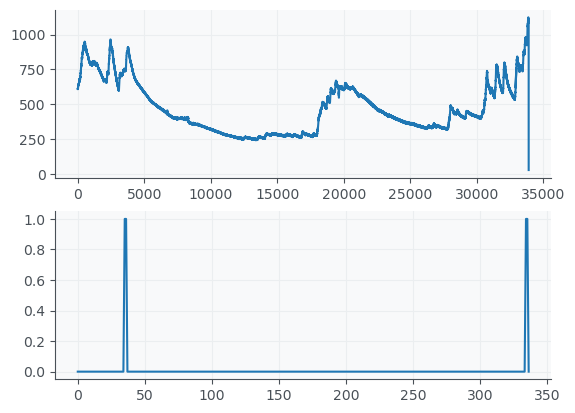

In [159]:
X = np.column_stack((relative_mean , relative_max , relative_min , relative_peaks_numb , relative_peaks_mean  ))
X.shape
features_array = X

predictions = svm_model.predict( features_array )
print(predictions)

plt.subplot(2,1,1)
plt.plot(predict)
plt.subplot(2,1,2)
plt.plot(predictions)

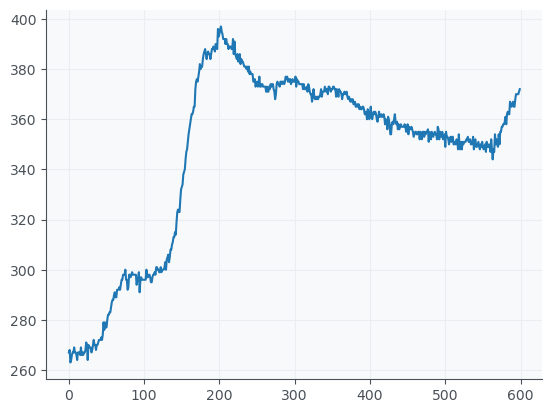

In [156]:
plt.plot(predict[0:10*1*60])

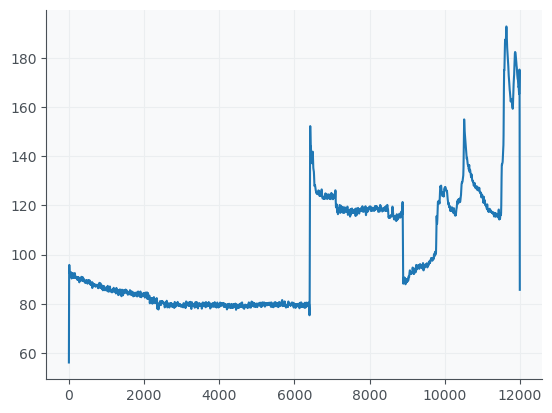

In [19]:
Fs = 10
x  = Get_dataFromTextFile( 'MentalWorkLoad/watching_AI_lecture_part2.txt')
x = apply_low_pass_filter_on_a_signal( 50 , 1/Fs , x ) # Filtering signal

plt.plot(x)